# Issue 2: Analysis of new data from various aspects

In [119]:
import xarray as xr
import xarray.ufuncs as xrf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

xr.set_options(keep_attrs = True, display_style = 'html')  # Attributes of DataArrays will be kept through operations.

## Definition of functions

In [121]:
def read_group(gruppe,loc):
    station = loc #ersten Buchstaben bitte bitte groß schreiben
    
    if loc=='RioGrande':
        timestart = '2008-02-01'
        timeend = '2020-12-31'
    elif loc == 'Leipzig':
        timestart =  '2004-08-01'
        timeend =  '2020-12-31'
    elif loc=='CMOR':
        timestart = '2002-01-01'
        timeend = '2020-12-31'
    elif loc=='Davis':
        timestart = '2005-01-01'
        timeend ='2020-12-31'
    elif loc=='Andenes_Kiruna':
        timestart = '1999-08-01'
        timeend ='2020-12-31'
    elif loc=='Sodankyla_Kiruna':
        timestart = '1999-08-01'
        timeend ='2020-12-31'
    elif loc=='Andenes':
        timestart = '2002-06-01'
        timeend ='2020-12-31'
    elif loc=='Esrange':
        timestart = '1999-08-01'
        timeend ='2020-12-31'
    elif loc=='Juliusruh':
        timestart = '2002-01-01'
        timeend ='2020-12-31'
    elif loc=='Sodankyla':
        timestart = '2008-10-01'
        timeend ='2020-12-31'
    
    infiles = f'{root_path}{station}_solar_cycle.h5'
    
    ds_info = xr.open_dataset(f'{root_path}{station}_solar_cycle.h5', group = 'info')
    ds_info = ds_info.rename({'phony_dim_7': 'alt'})
    
    
    if gruppe == 'wind':
        ds = xr.open_dataset(f'{root_path}{station}_solar_cycle.h5', group = 'wind')
        ds = ds.rename({'phony_dim_10': 'time', 'phony_dim_11': 'alt'})
    elif gruppe == 'waves':
        ds = xr.open_dataset(f'{root_path}{station}_solar_cycle.h5', group = 'waves')
        ds = ds.rename({'phony_dim_8': 'time', 'phony_dim_9': 'alt'})

    s_year = int(ds_info['year'].values[0][0])
    s_month = int(ds_info['month'].values[0][0])
    s_day = int(ds_info['day'].values[0][0])

    ds = ds.assign_coords({"alt": ds_info['alt'].squeeze(), 
                   "time": pd.date_range(f'{s_year}-{s_month}-{s_day}', freq = 'D', periods = ds.time.shape[0])})
    ds['alt'].attrs['units'] = 'km'     #dimension 'alt' gets unit 'km'
    ds['alt'].attrs['long_name'] = 'altitude' #displayed name of dimension 'alt' (e.g. in plots) will now be 'altitude'
    
    return ds

In [3]:
def read_var(gruppe, var):
        varout = gruppe[var]
        return varout

In [4]:
def hwind(u,v):
    return np.sqrt(u**2+v**2)

In [5]:
def time_mean(step,var):
    return var.resample(time='1'+step).mean('time') #Immer nur D oder M oder H oder Y eintragen! Mit Anführungszeichen!

In [6]:
def anomalie(step,var):
    string = "time."+step   
    climatology = var.groupby(string).mean("time")
    anomalies = var.groupby(string) - climatology
    
    return anomalies

In [7]:
def grav_waves(wind_component,loc): # Beides muss schon als String reingegeben werden! 
    ds = read_group('wind',loc)
    gw = read_var(ds,wind_component) - read_var(ds,wind_component+'_fil')
    return gw

In [8]:
def grav_waves_gaia(wind_component,loc_array): # Windkomponente muss schon als String reingegeben werden! 
    gw = read_var(loc_array,wind_component) - read_var(loc_array,wind_component+'_fil')
    return gw

In [9]:
def kin_energy_grav_waves(loc):
    kin_energy = 0.5*((grav_waves('u',loc))**2 + (grav_waves('v',loc))**2)
    return kin_energy

In [10]:
def kin_energy_grav_waves_gaia(loc_array):
    kin_energy = 0.5*((grav_waves_gaia('u',loc_array))**2 + (grav_waves_gaia('v',loc_array))**2)
    return kin_energy

#### Superposed Epoch Analysis

In [171]:
def sea(days_period,station,var):
    df_dates = pd.read_csv('ssw_dates_without_final_warmings_'+station+'.csv') # you can load SSWs from a csv file like attached
    dates = df_dates.set_index('BeginDate')

    xa_ls = []
    max_lag = days_period
    for il, days in enumerate(range(-max_lag,max_lag+1)):  
        sel_dates = pd.to_datetime(dates.index) + pd.Timedelta(str(days)+' days')
        mask = np.in1d(var.time.dt.floor('1D'),sel_dates)
        comp_m = var.sel(time = mask).mean('time')
        comp_s = var.sel(time = mask).std('time')
        comp_m.name=f'{var.name}_mean' #Variable Mittelwert umbenennen
        comp_s.name=f'{var.name}_std' #Variable Standardabweichung umbenennen

        #print(comp_m, comp_s)
        xa_ls.append(xr.merge([comp_m, comp_s]))  #Merge arrays of mean and standard deviation in one data array
   
    xa_comp = xr.concat(xa_ls, dim = 'days')
    xa_comp['days'] = range(-max_lag, max_lag+1)

    # print(xa_comp)
    return xa_comp

In [12]:
alt = [70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, \
       106, 108, 110, 112, 114, 116, 118, 120]
root_path = '/home/gemeinsam_tmp/UA_students/data/PW_GW_analysis/'

## Wind measurements

### Leipzig

In [172]:
ds_col = read_group('wind','Leipzig')
u_col = read_var(ds_col,'u0')
v_col = read_var(ds_col,'v0')

u_col_anomalie = anomalie('day',u_col)
# u_col_anomalie.plot(x='time',robust=True)

v_col_anomalie = anomalie('day',v_col)

sea_u_col = sea(30,'Leipzig',u_col)
sea_u_col_anomalie = sea(30,'Leipzig',u_col_anomalie)

sea_v_col = sea(30,'Leipzig',v_col)
sea_v_col_anomalie = sea(30,'Leipzig',v_col_anomalie)

#u_col_anomalie.sel(time=slice('2016-02-15', '2016-04-15')).plot(x='time',size=10,robust=True)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [173]:
sea_v_col

<xarray.Dataset>
Dimensions:  (alt: 26, days: 61)
Coordinates:
  * alt      (alt) float64 70.0 72.0 74.0 76.0 78.0 ... 114.0 116.0 118.0 120.0
  * days     (days) int64 -30 -29 -28 -27 -26 -25 -24 ... 24 25 26 27 28 29 30
Data variables:
    v0_mean  (days, alt) float64 nan nan 0.285 -2.665 ... nan nan nan nan
    v0_std   (days, alt) float64 nan nan 0.0 11.04 4.955 ... nan nan nan nan nan

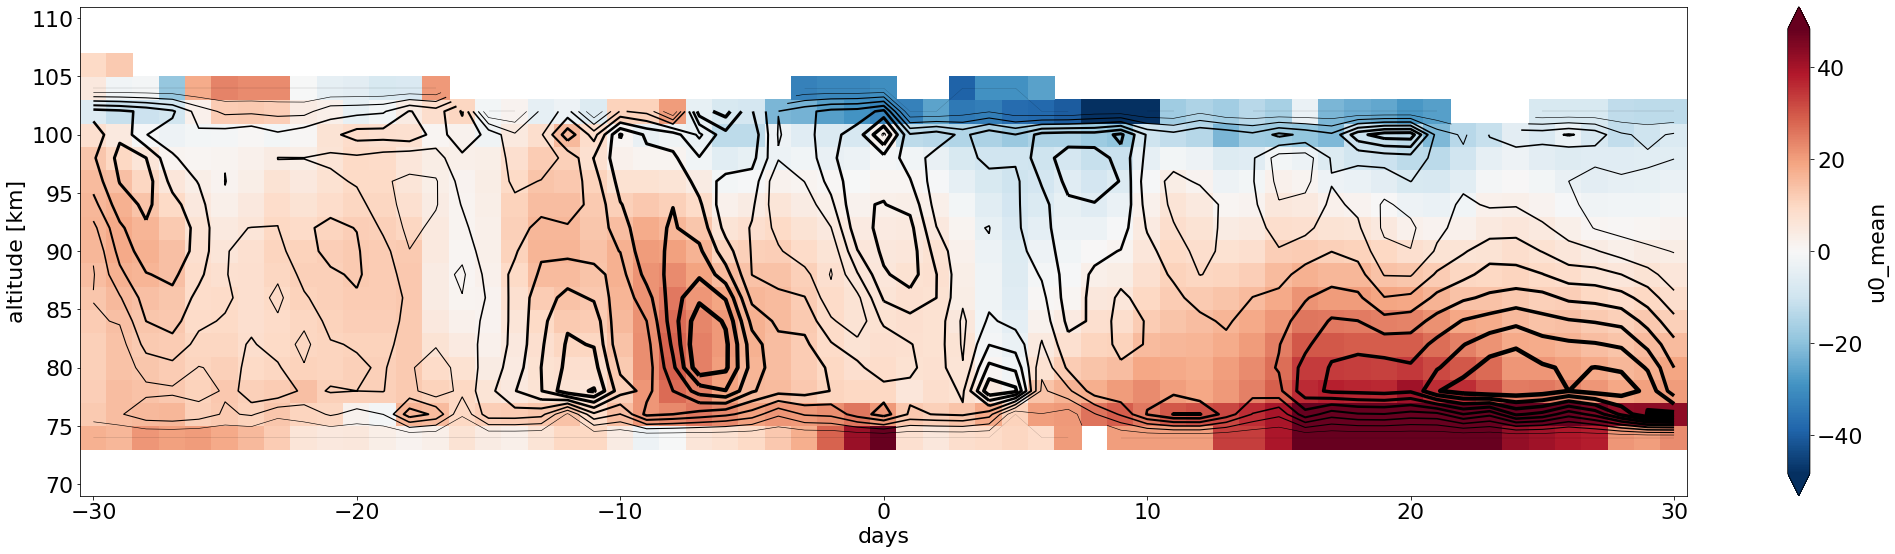

In [179]:
p = sea_u_col['u0_mean'].sel(alt = slice(70,110)).plot(x='days',robust=True, size = 9, aspect=4)
ax = p.axes
nl = 11
ax1 = sea_u_col['u0_std'].sel(alt = slice(70,110)).plot.contour(x='days',robust=True, levels = nl,
                                                                colors ='k', ax = ax, linewidths=np.linspace(0.1,5,nl))

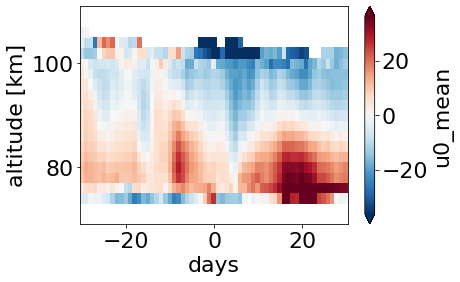

In [180]:
ax2 = sea_u_col_anomalie['u0_mean'].sel(alt = slice(70,110)).plot(x='days',robust=True)

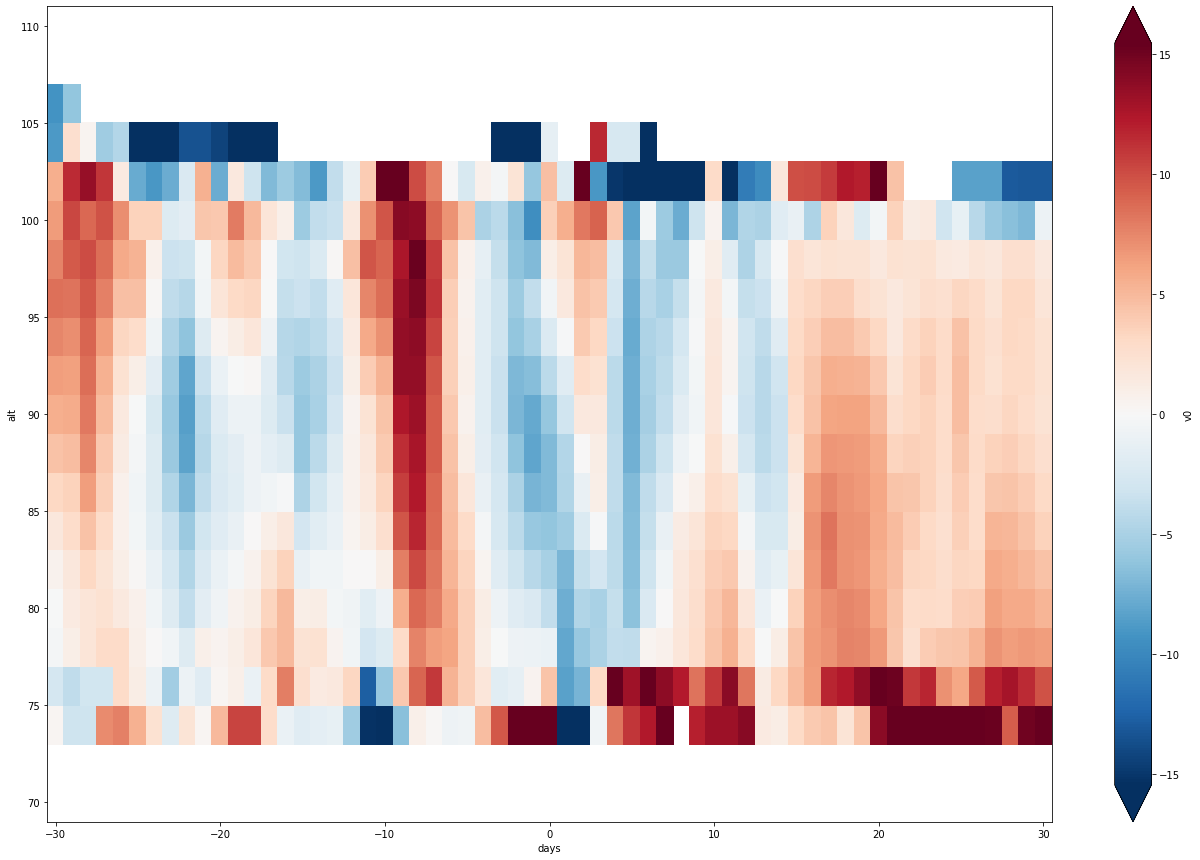

In [16]:
ax3 = sea_v_col.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

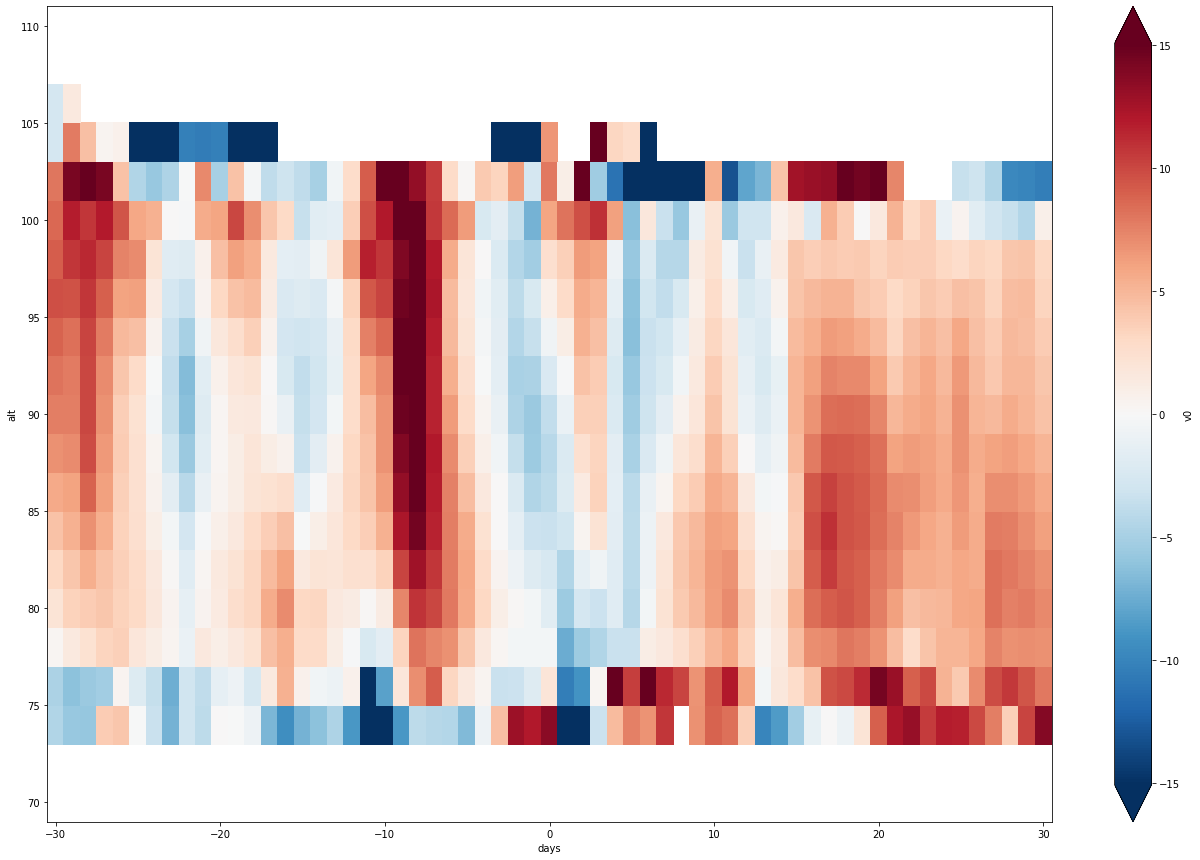

In [17]:
ax4 = sea_v_col_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Andenes

In [18]:
ds_and = read_group('wind','Andenes')
u_and = read_var(ds_and,'u0')
v_and = read_var(ds_and,'v0')

u_and_anomalie = anomalie('day',u_and)
# u_col_anomalie.plot(x='time',robust=True)

v_and_anomalie = anomalie('day',v_and)

sea_u_and = sea(30,'Andenes',u_and)
sea_u_and_anomalie = sea(30,'Andenes',u_and_anomalie)

sea_v_and = sea(30,'Andenes',v_and)
sea_v_and_anomalie = sea(30,'Andenes',v_and_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


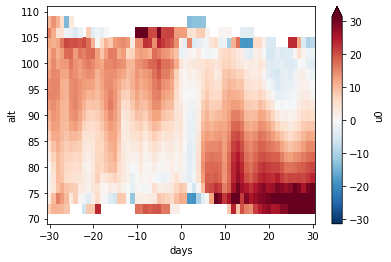

In [19]:
ax5 = sea_u_and.sel(alt = slice(70,110)).plot(x='days',robust=True)

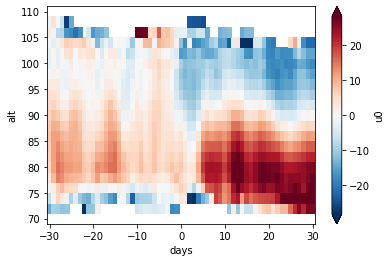

In [20]:
ax6 = sea_u_and_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

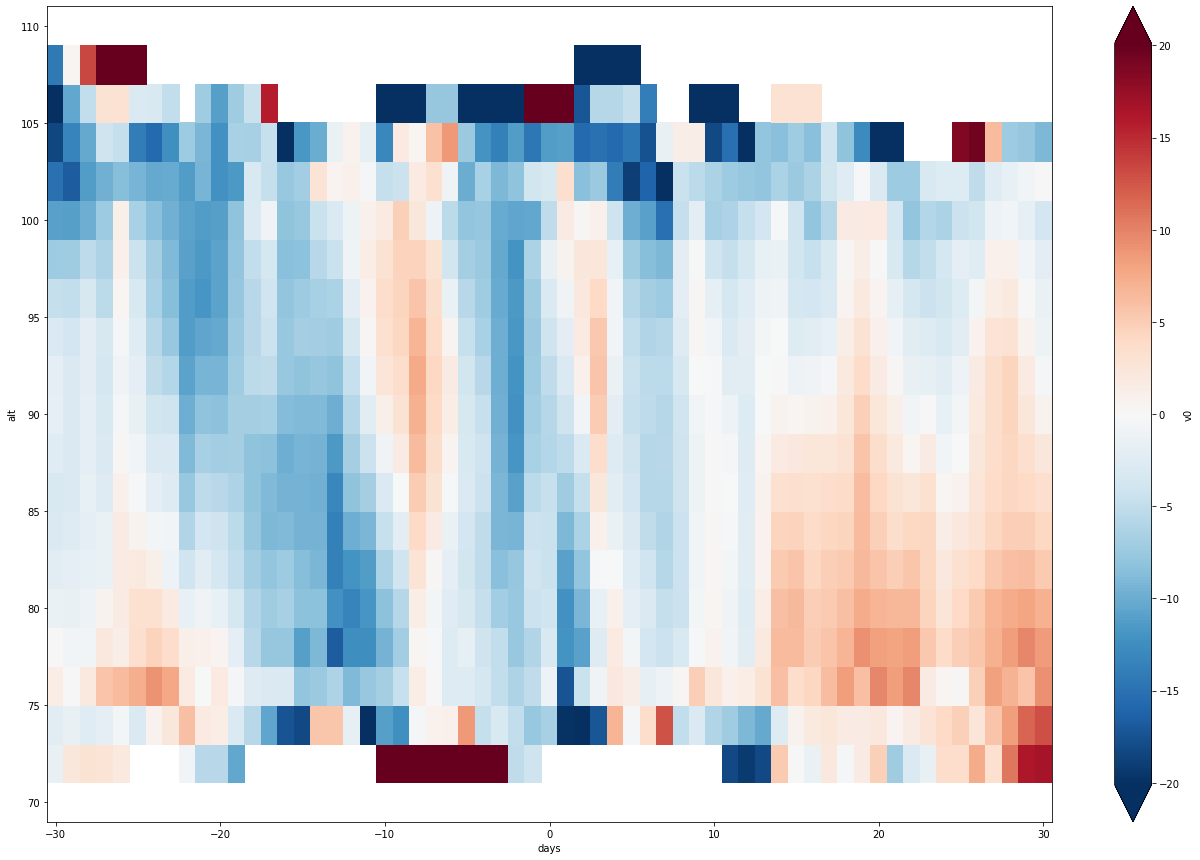

In [21]:
ax7 = sea_v_and.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

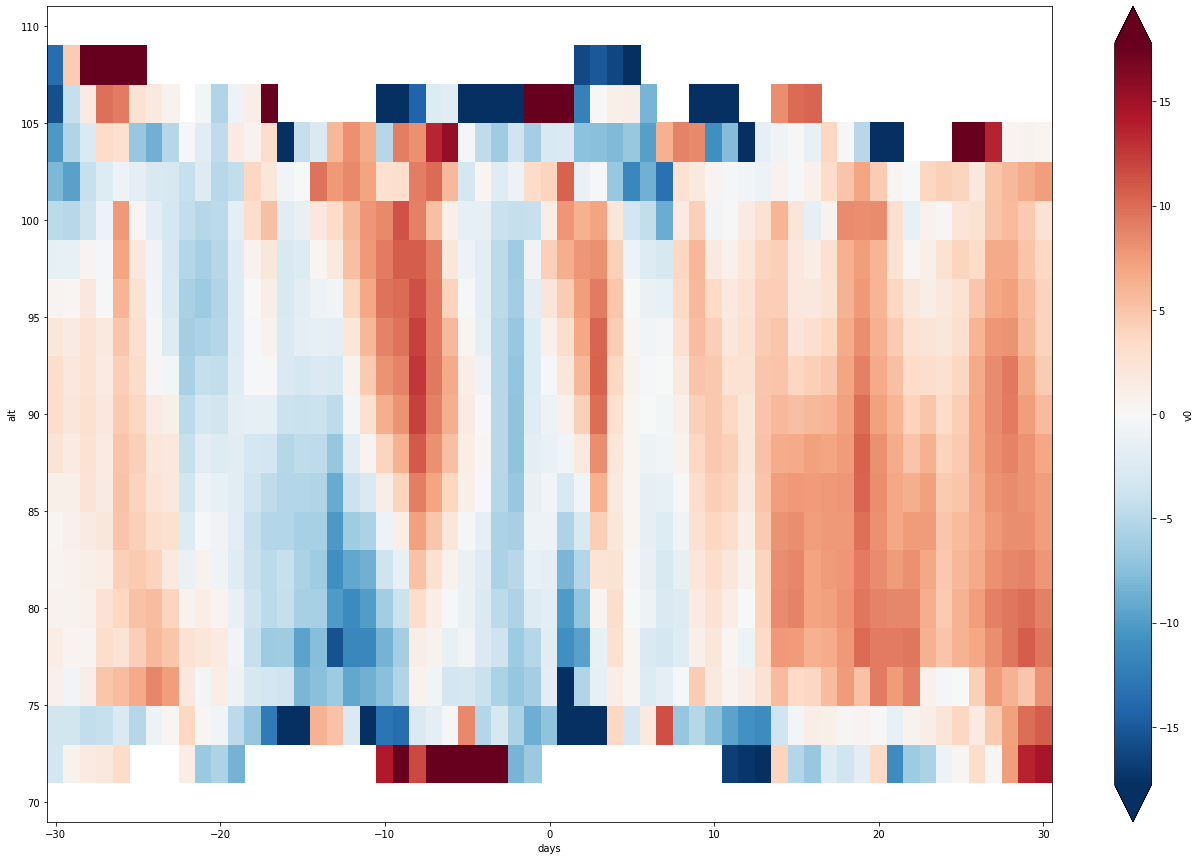

In [22]:
ax8 = sea_v_and_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Andenes/Kiruna

In [23]:
ds_and_kir = read_group('wind','Andenes_Kiruna')
u_and_kir = read_var(ds_and_kir,'u0')
v_and_kir = read_var(ds_and_kir,'v0')

u_and_kir_anomalie = anomalie('day',u_and_kir)
# u_col_anomalie.plot(x='time',robust=True)

v_and_kir_anomalie = anomalie('day',v_and_kir)

sea_u_and_kir = sea(30,'Andenes_Kiruna',u_and_kir)
sea_u_and_kir_anomalie = sea(30,'Andenes_Kiruna',u_and_kir_anomalie)

sea_v_and_kir = sea(30,'Andenes_Kiruna',v_and_kir)
sea_v_and_kir_anomalie = sea(30,'Andenes_Kiruna',v_and_kir_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


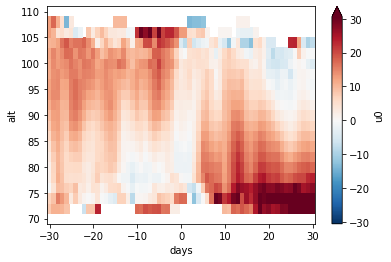

In [24]:
ax9 = sea_u_and_kir.sel(alt = slice(70,110)).plot(x='days',robust=True)

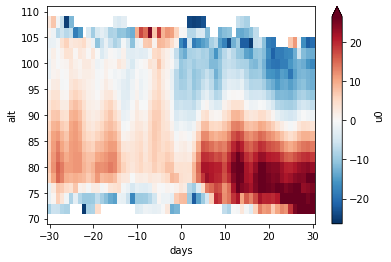

In [25]:
ax10 = sea_u_and_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

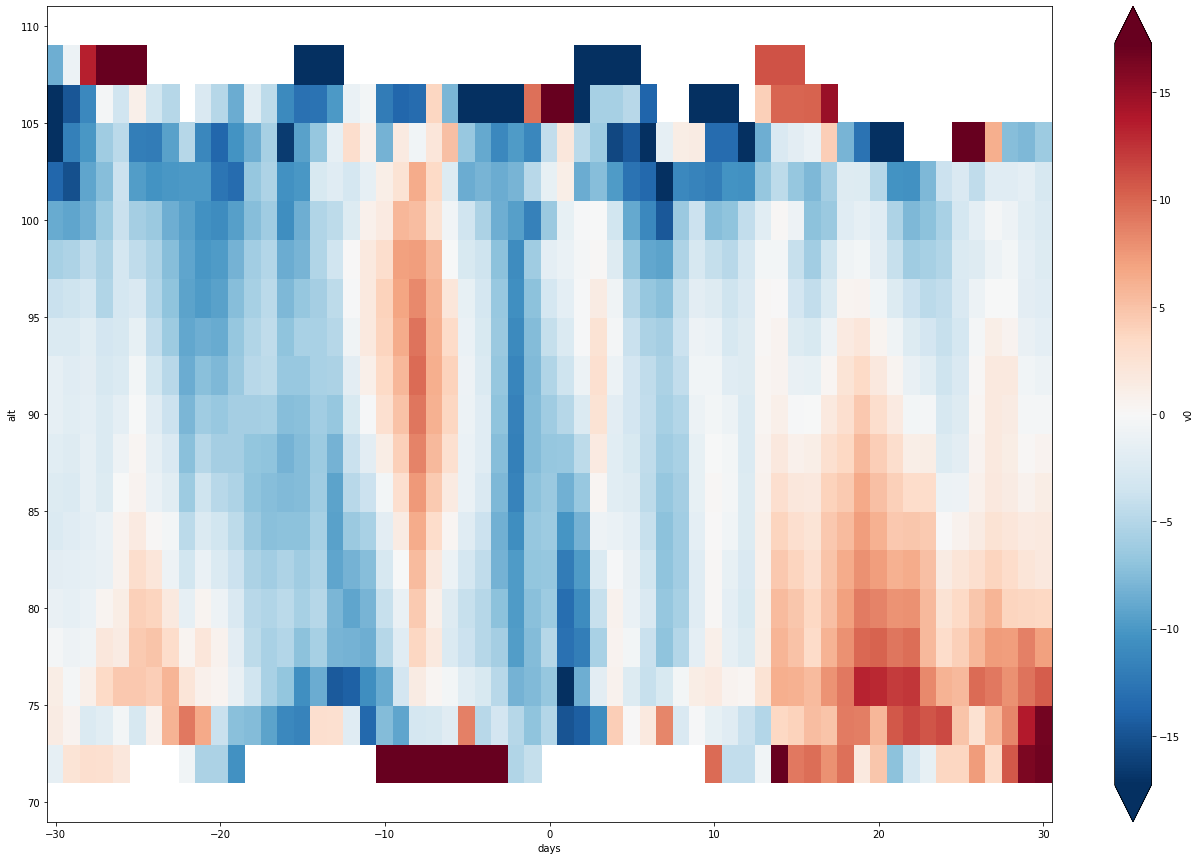

In [26]:
ax11 = sea_v_and_kir.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

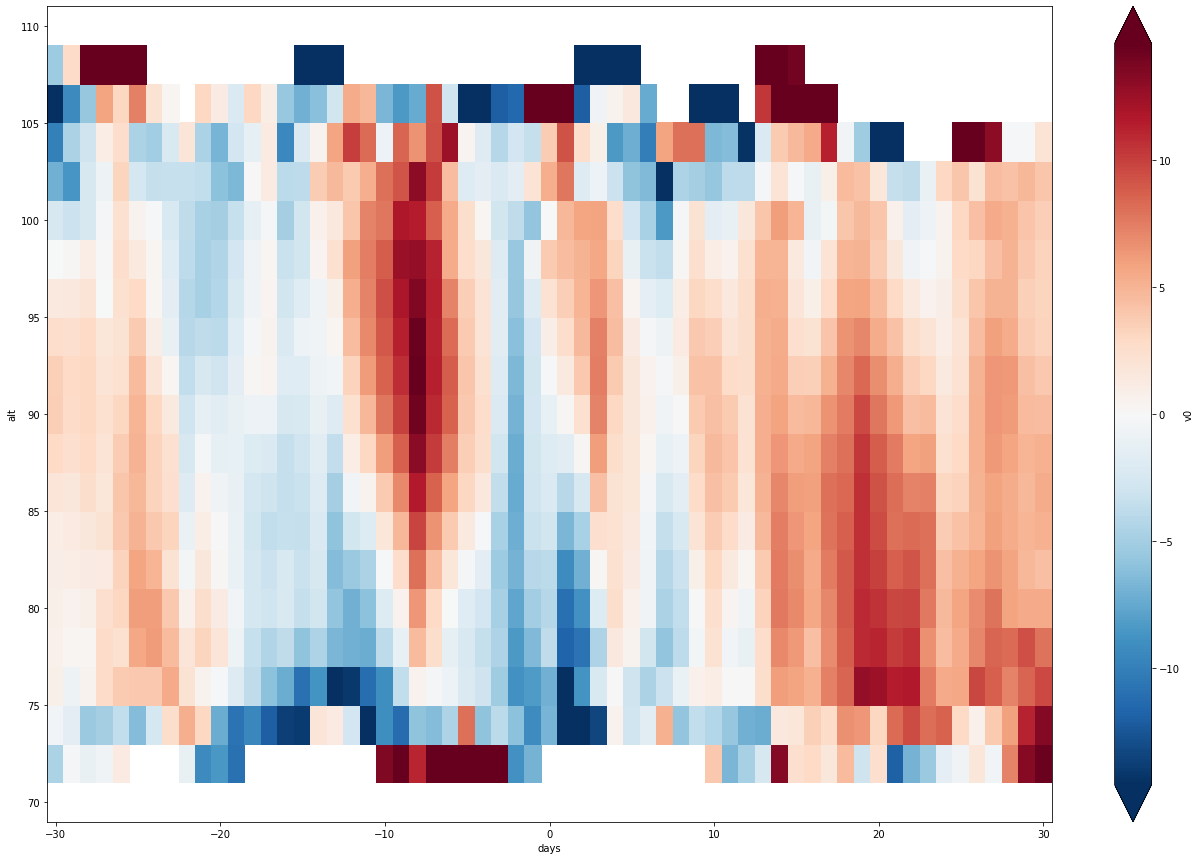

In [27]:
ax12 = sea_v_and_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Sodankyla/Kiruna

In [28]:
ds_sod_kir = read_group('wind','Sodankyla_Kiruna')
u_sod_kir = read_var(ds_sod_kir,'u0')
v_sod_kir = read_var(ds_sod_kir,'v0')

u_sod_kir_anomalie = anomalie('day',u_sod_kir)
# u_col_anomalie.plot(x='time',robust=True)

v_sod_kir_anomalie = anomalie('day',v_sod_kir)

sea_u_sod_kir = sea(30,'Sodankyla_Kiruna',u_sod_kir)
sea_u_sod_kir_anomalie = sea(30,'Sodankyla_Kiruna',u_sod_kir_anomalie)

sea_v_sod_kir = sea(30,'Sodankyla_Kiruna',v_sod_kir)
sea_v_sod_kir_anomalie = sea(30,'Sodankyla_Kiruna',v_sod_kir_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


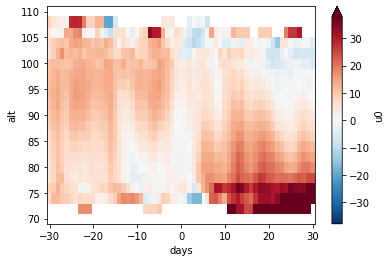

In [29]:
ax13 = sea_u_sod_kir.sel(alt = slice(70,110)).plot(x='days',robust=True)

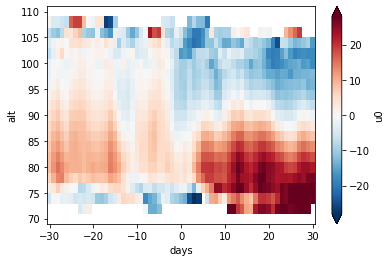

In [30]:
ax14 = sea_u_sod_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

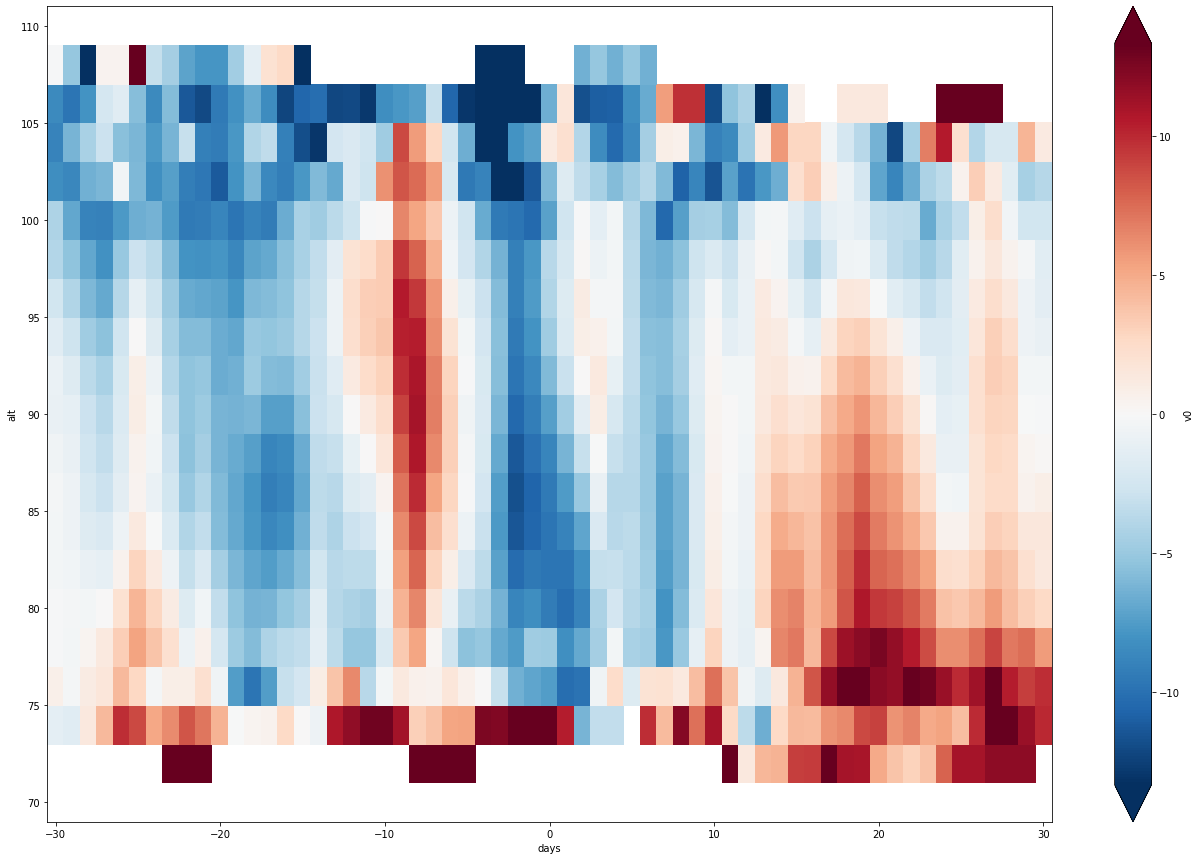

In [31]:
ax15 = sea_v_sod_kir.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

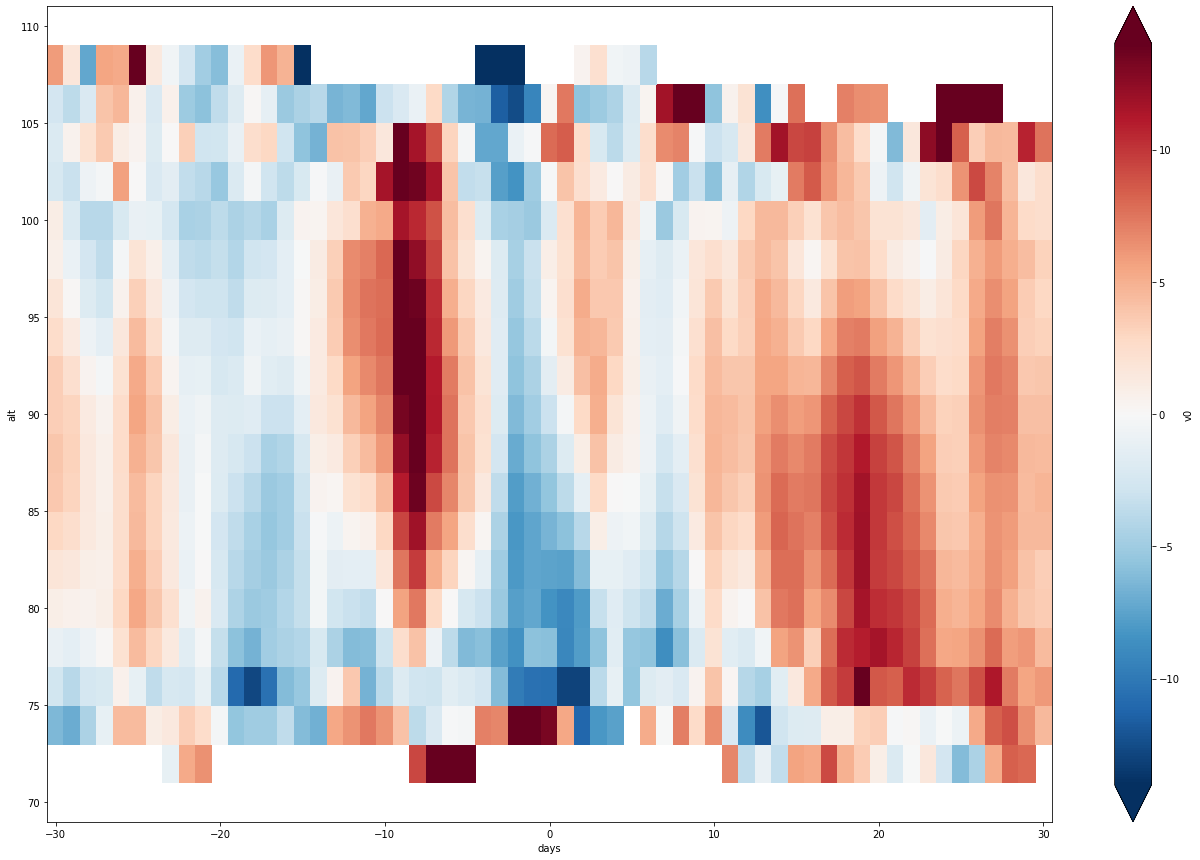

In [32]:
ax16 = sea_v_sod_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Sodankyla

In [33]:
ds_sod = read_group('wind','Sodankyla')
u_sod = read_var(ds_sod,'u0')
v_sod = read_var(ds_sod,'v0')

u_sod_anomalie = anomalie('day',u_sod)
# u_col_anomalie.plot(x='time',robust=True)

v_sod_anomalie = anomalie('day',v_sod)

sea_u_sod = sea(30,'Sodankyla',u_sod)
sea_u_sod_anomalie = sea(30,'Sodankyla',u_sod_anomalie)

sea_v_sod = sea(30,'Sodankyla',v_sod)
sea_v_sod_anomalie = sea(30,'Sodankyla',v_sod_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


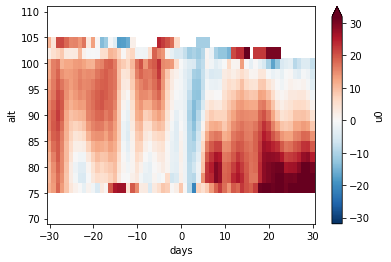

In [34]:
ax17 = sea_u_sod.sel(alt = slice(70,110)).plot(x='days',robust=True)

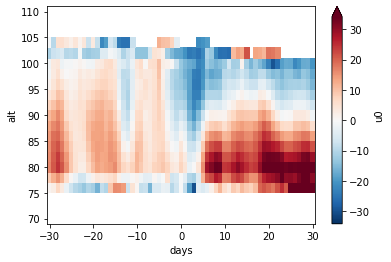

In [35]:
ax18 = sea_u_sod_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

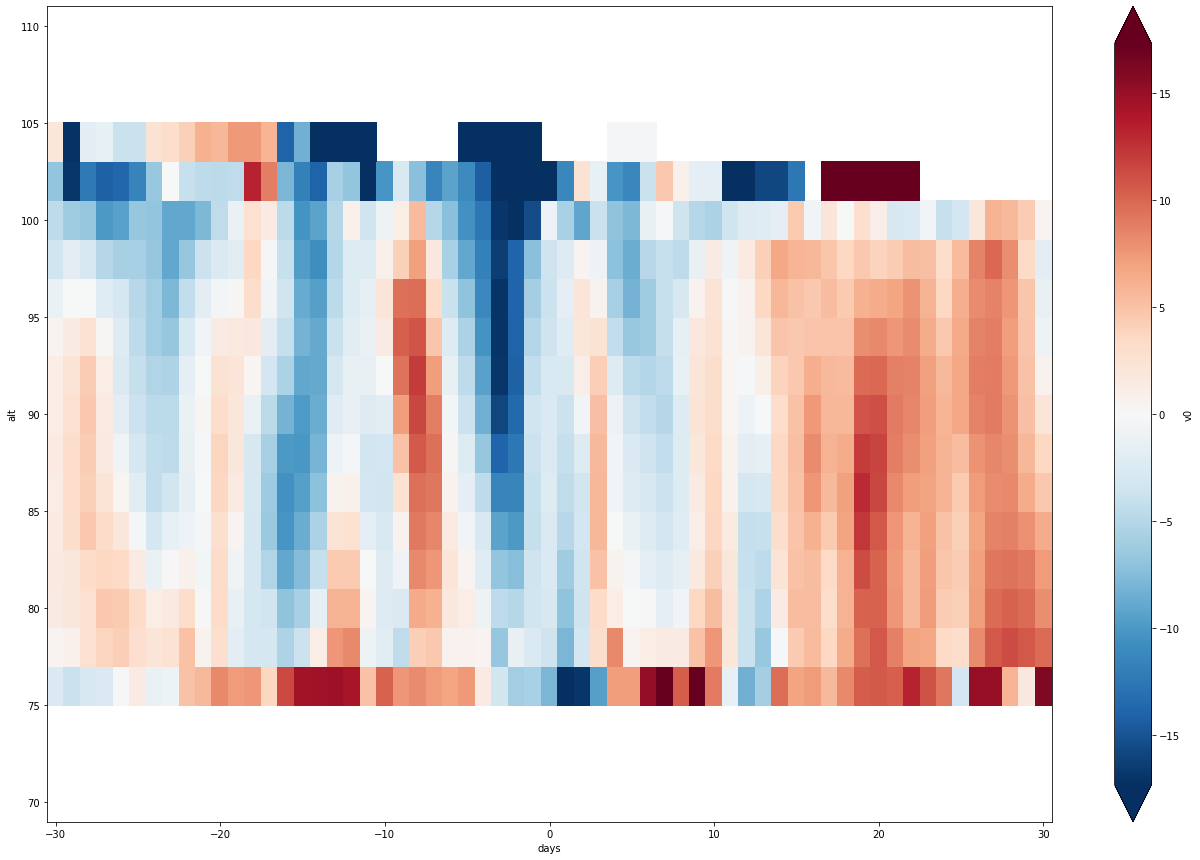

In [36]:
ax19 = sea_v_sod.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

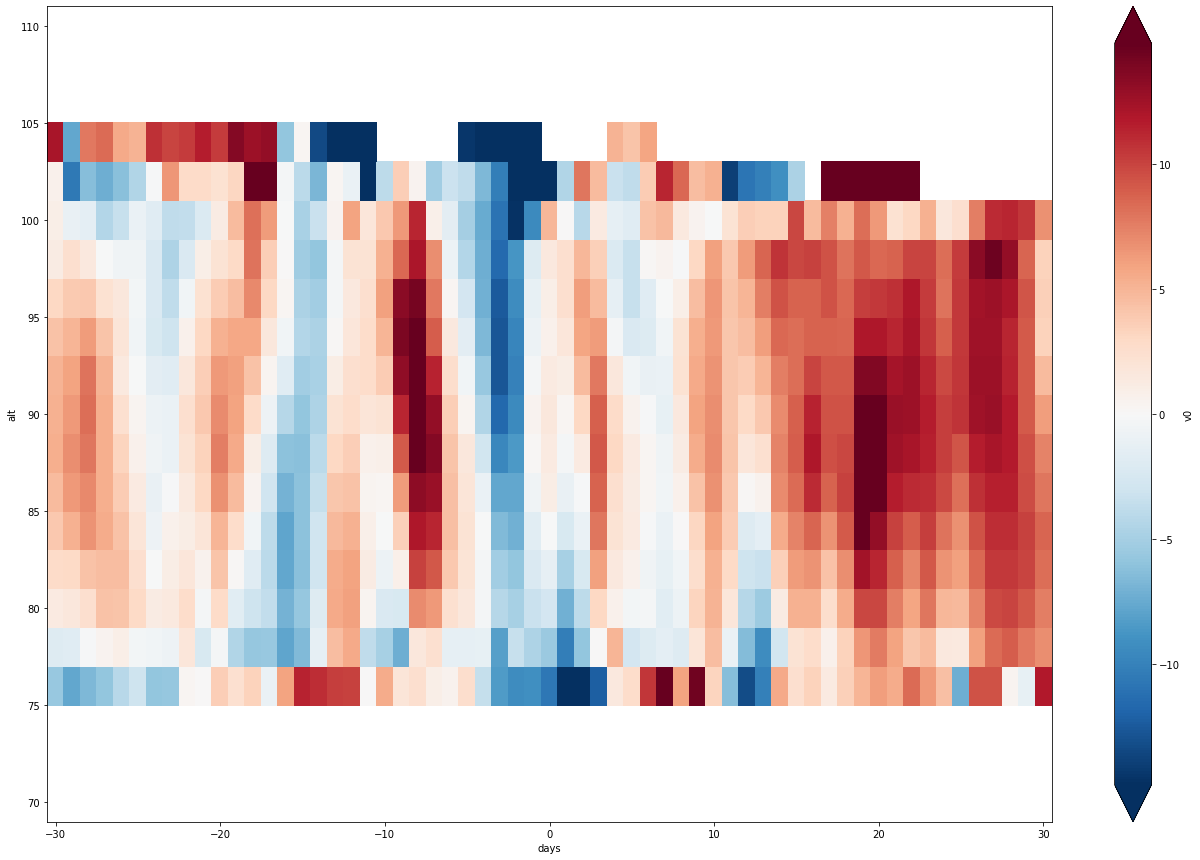

In [37]:
ax20 = sea_v_sod_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Davis

In [38]:
ds_dav = read_group('wind','Davis')
u_dav = read_var(ds_dav,'u0')
v_dav = read_var(ds_dav,'v0')

u_dav_anomalie = anomalie('day',u_dav)
# u_col_anomalie.plot(x='time',robust=True)

v_dav_anomalie = anomalie('day',v_dav)

sea_u_dav = sea(30,'Davis',u_dav)
sea_u_dav_anomalie = sea(30,'Davis',u_dav_anomalie)

sea_v_dav = sea(30,'Davis',v_dav)
sea_v_dav_anomalie = sea(30,'Davis',v_dav_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


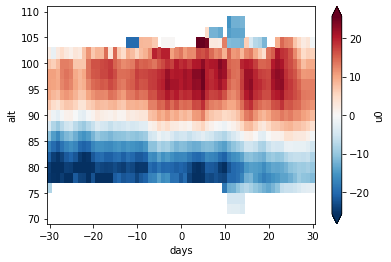

In [39]:
ax21 = sea_u_dav.sel(alt = slice(70,110)).plot(x='days',robust=True)

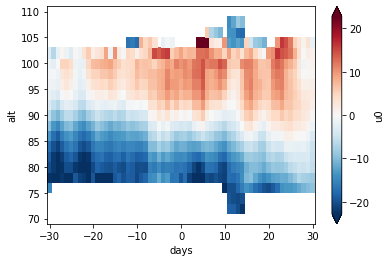

In [40]:
ax22 = sea_u_dav_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

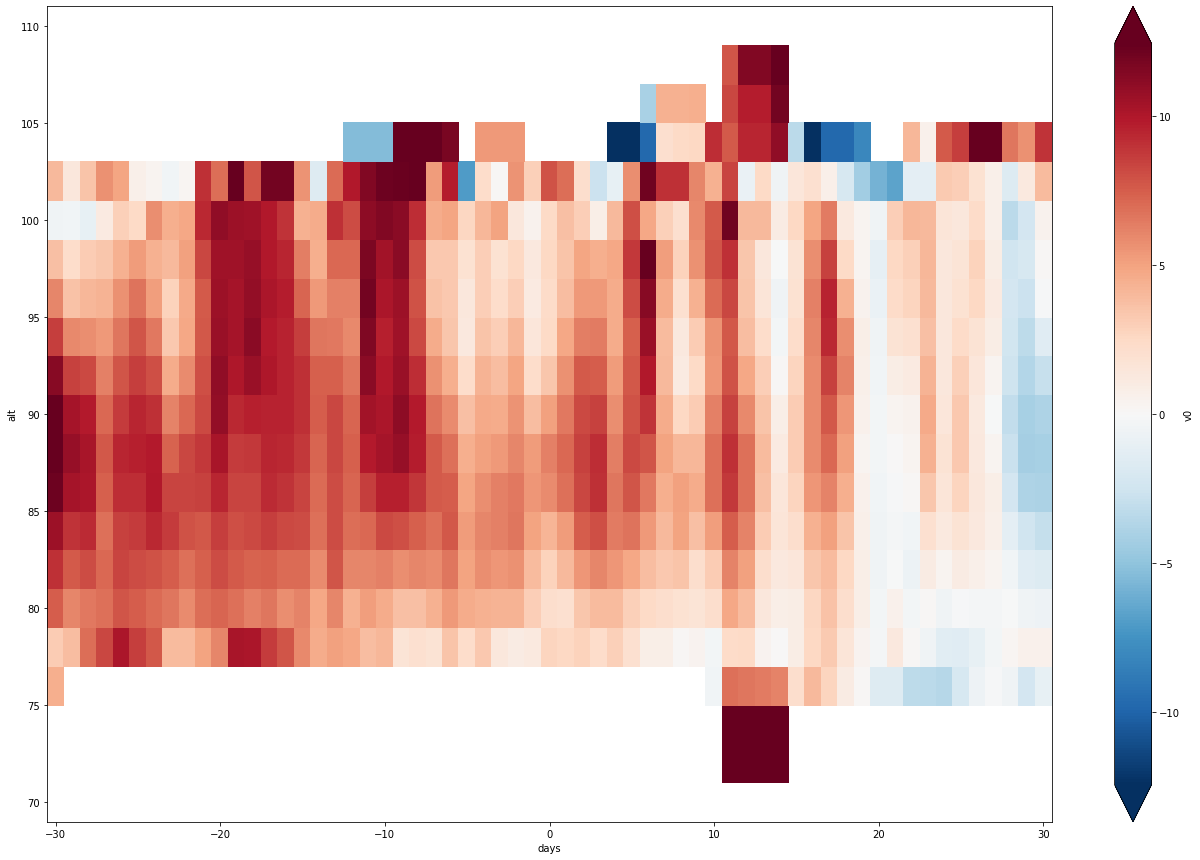

In [41]:
ax23 = sea_v_dav.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

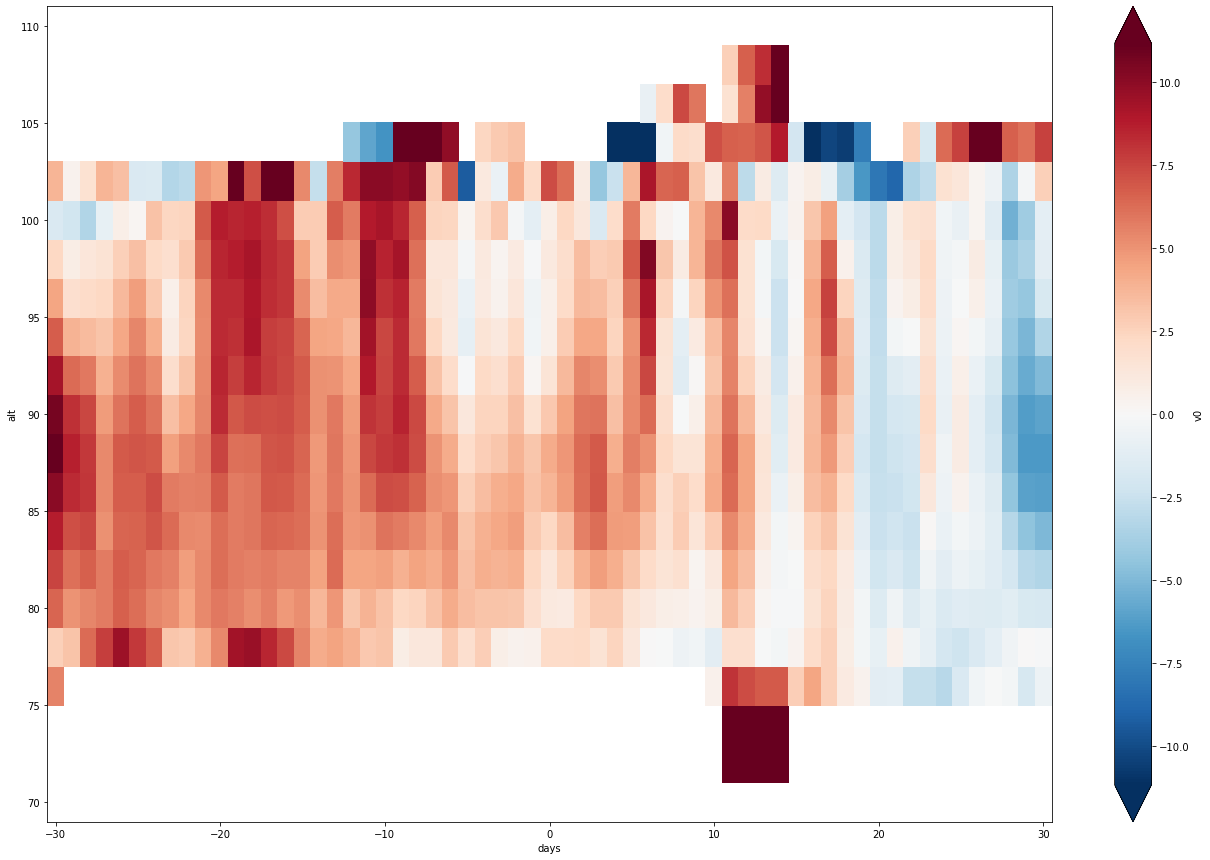

In [42]:
ax24 = sea_v_dav_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Esrange

In [43]:
ds_esr = read_group('wind','Esrange')
u_esr = read_var(ds_esr,'u0')
v_esr = read_var(ds_esr,'v0')

u_esr_anomalie = anomalie('day',u_esr)
# u_col_anomalie.plot(x='time',robust=True)

v_esr_anomalie = anomalie('day',v_esr)

sea_u_esr = sea(30,'Esrange',u_esr)
sea_u_esr_anomalie = sea(30,'Esrange',u_esr_anomalie)

sea_v_esr = sea(30,'Esrange',v_esr)
sea_v_esr_anomalie = sea(30,'Esrange',v_esr_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


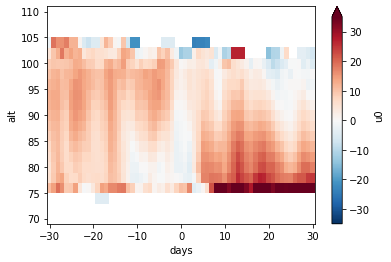

In [44]:
ax25 = sea_u_esr.sel(alt = slice(70,110)).plot(x='days',robust=True)

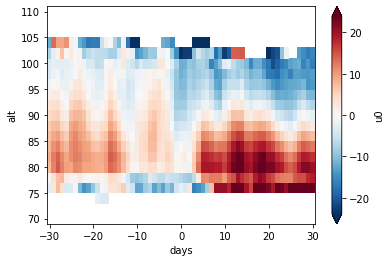

In [45]:
ax26 = sea_u_esr_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

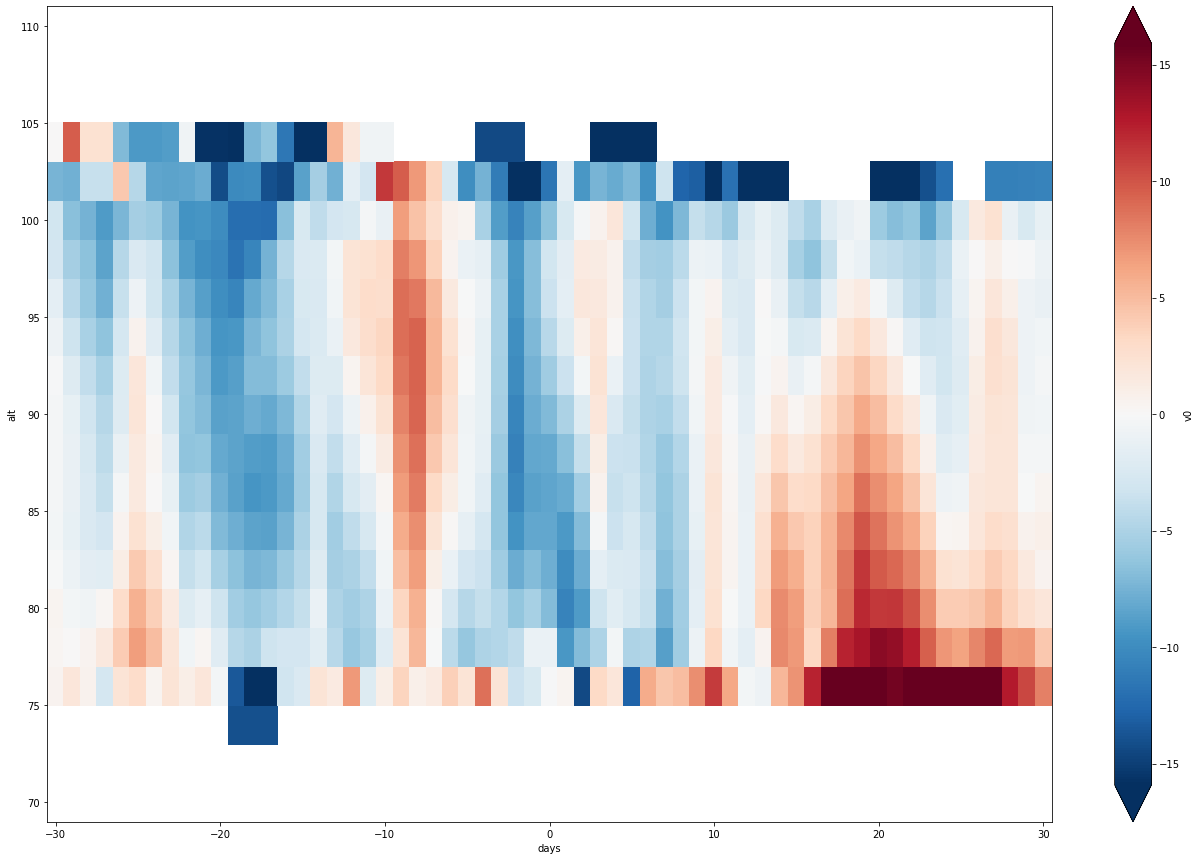

In [46]:
ax27 = sea_v_esr.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

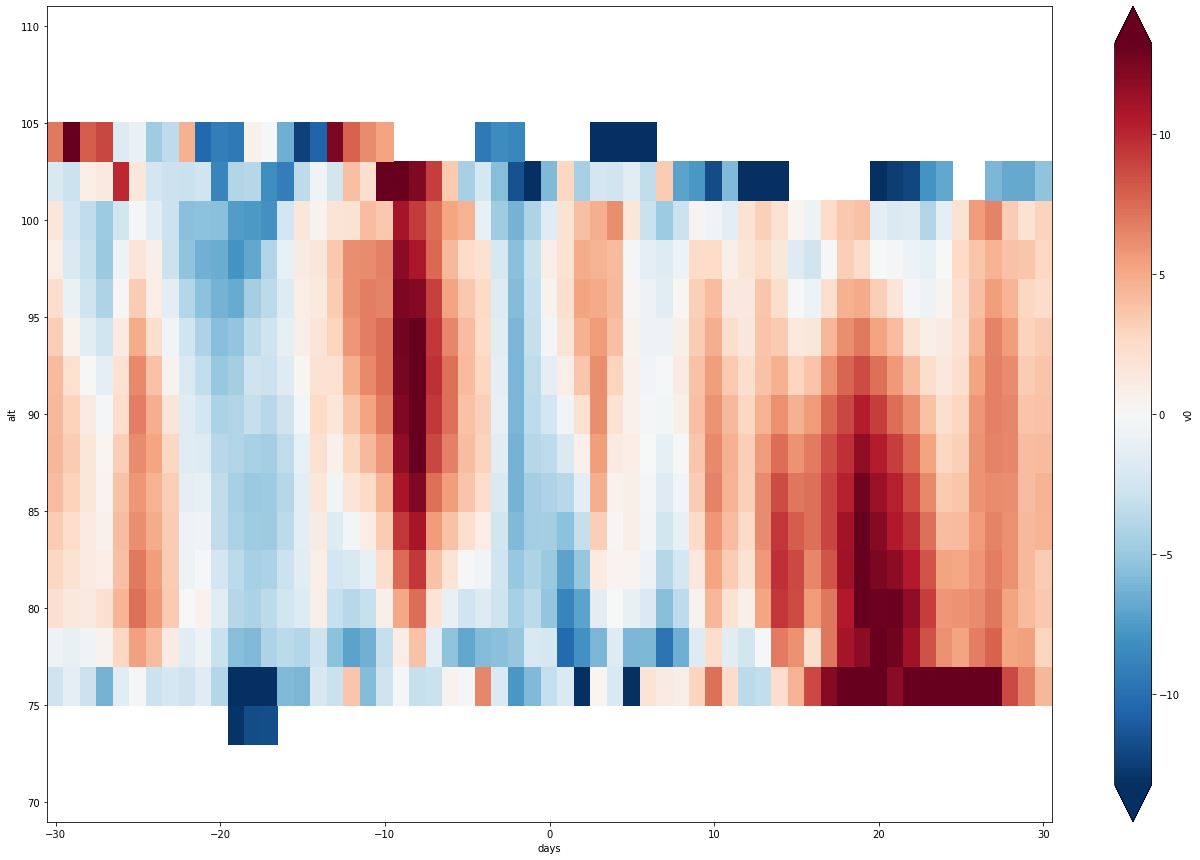

In [47]:
ax28 = sea_v_esr_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Juliusruh

In [48]:
ds_jul = read_group('wind','Juliusruh')
u_jul = read_var(ds_jul,'u0')
v_jul = read_var(ds_jul,'v0')

u_jul_anomalie = anomalie('day',u_jul)
# u_col_anomalie.plot(x='time',robust=True)

v_jul_anomalie = anomalie('day',v_jul)

sea_u_jul = sea(30,'Juliusruh',u_jul)
sea_u_jul_anomalie = sea(30,'Juliusruh',u_jul_anomalie)

sea_v_jul = sea(30,'Juliusruh',v_jul)
sea_v_jul_anomalie = sea(30,'Juliusruh',v_jul_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


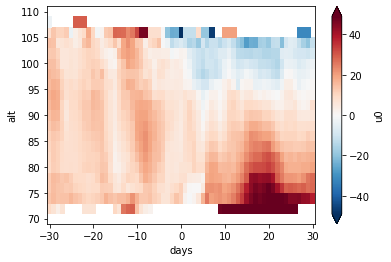

In [49]:
ax29 = sea_u_jul.sel(alt = slice(70,110)).plot(x='days',robust=True)

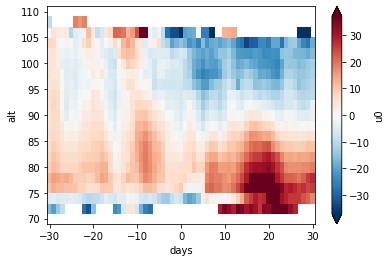

In [50]:
ax30 = sea_u_jul_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

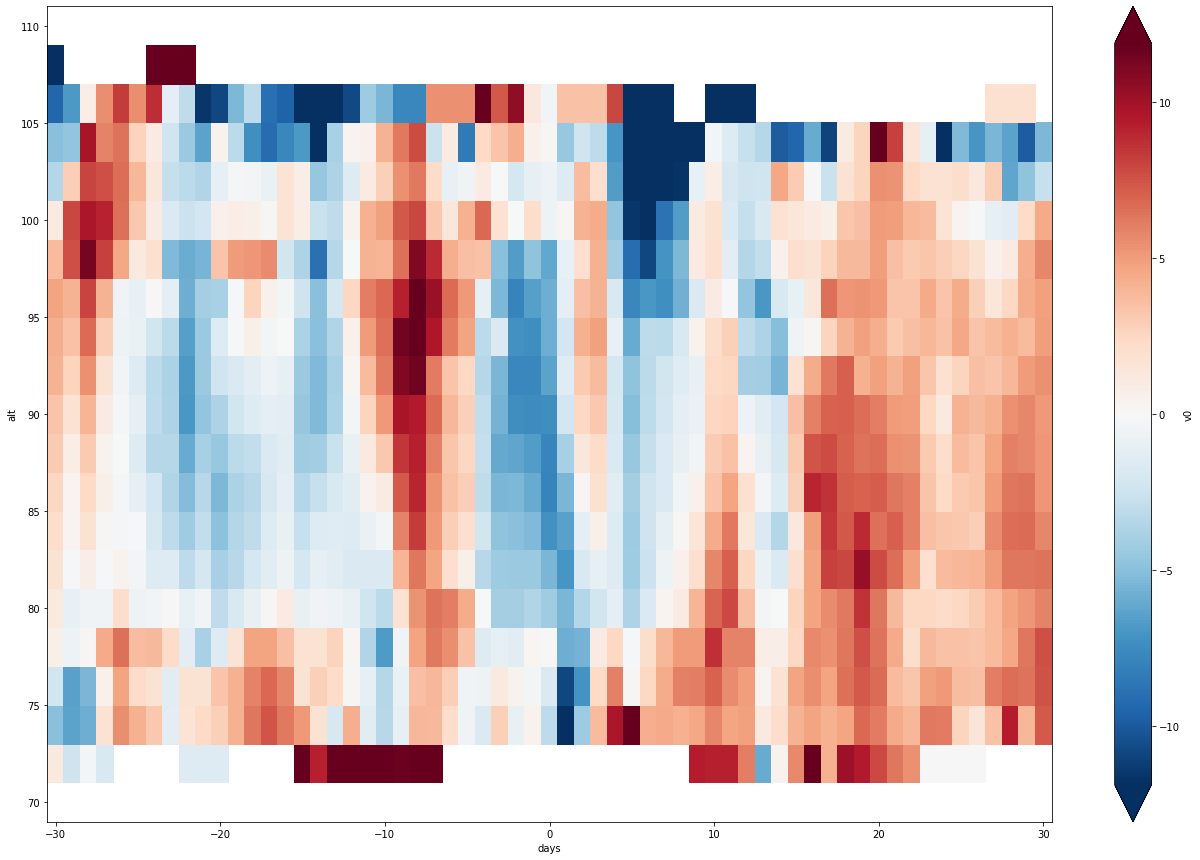

In [51]:
ax31 = sea_v_jul.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

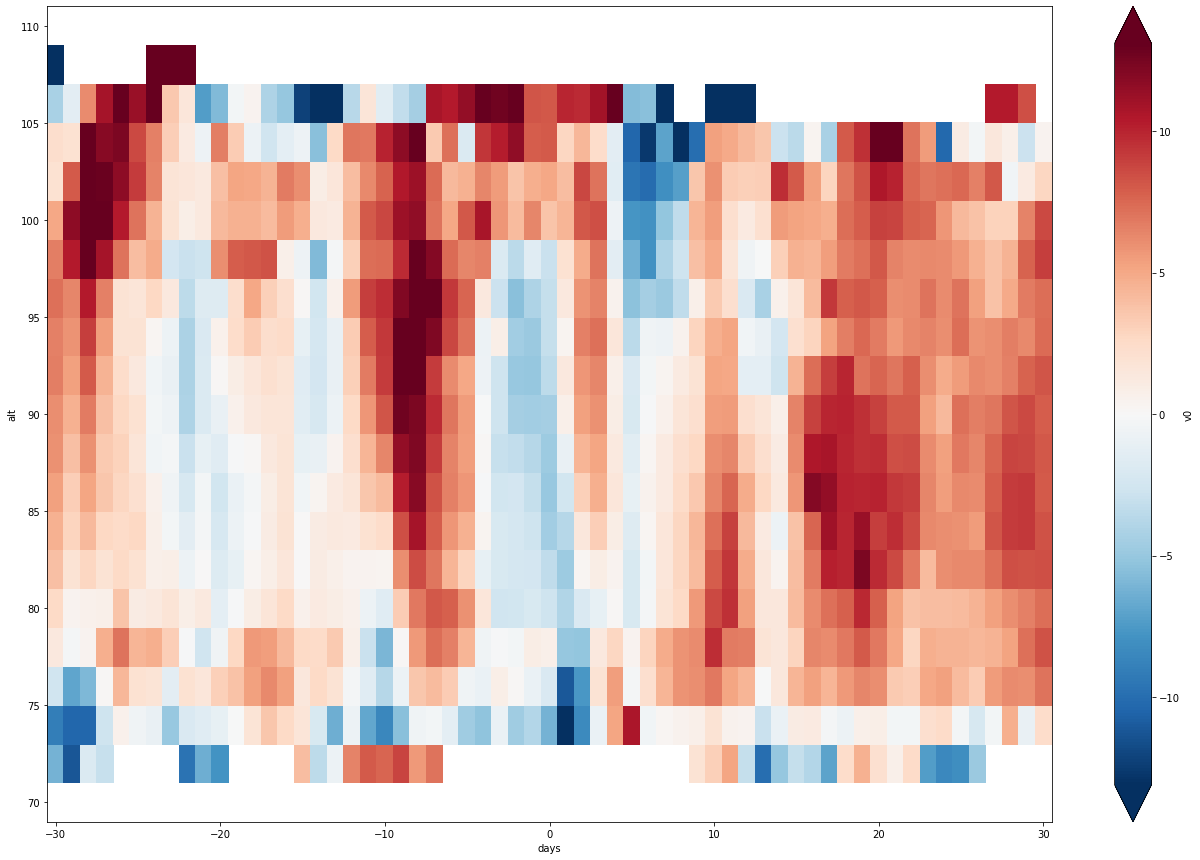

In [52]:
ax32 = sea_v_jul_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Rio Grande

In [53]:
ds_rio = read_group('wind','RioGrande')
u_rio = read_var(ds_rio,'u0')
v_rio = read_var(ds_rio,'v0')

u_rio_anomalie = anomalie('day',u_rio)
# u_col_anomalie.plot(x='time',robust=True)

v_rio_anomalie = anomalie('day',v_rio)

sea_u_rio = sea(30,'RioGrande',u_rio)
sea_u_rio_anomalie = sea(30,'RioGrande',u_rio_anomalie)

sea_v_rio = sea(30,'RioGrande',v_rio)
sea_v_rio_anomalie = sea(30,'RioGrande',v_rio_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


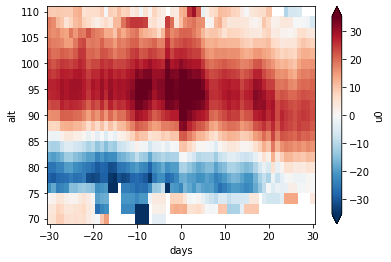

In [54]:
ax33 = sea_u_rio.sel(alt = slice(70,110)).plot(x='days',robust=True)

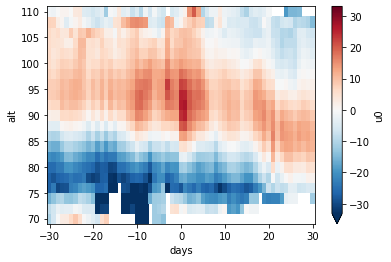

In [55]:
ax34 = sea_u_rio_anomalie.sel(alt = slice(70,110)).plot(x='days',robust=True)

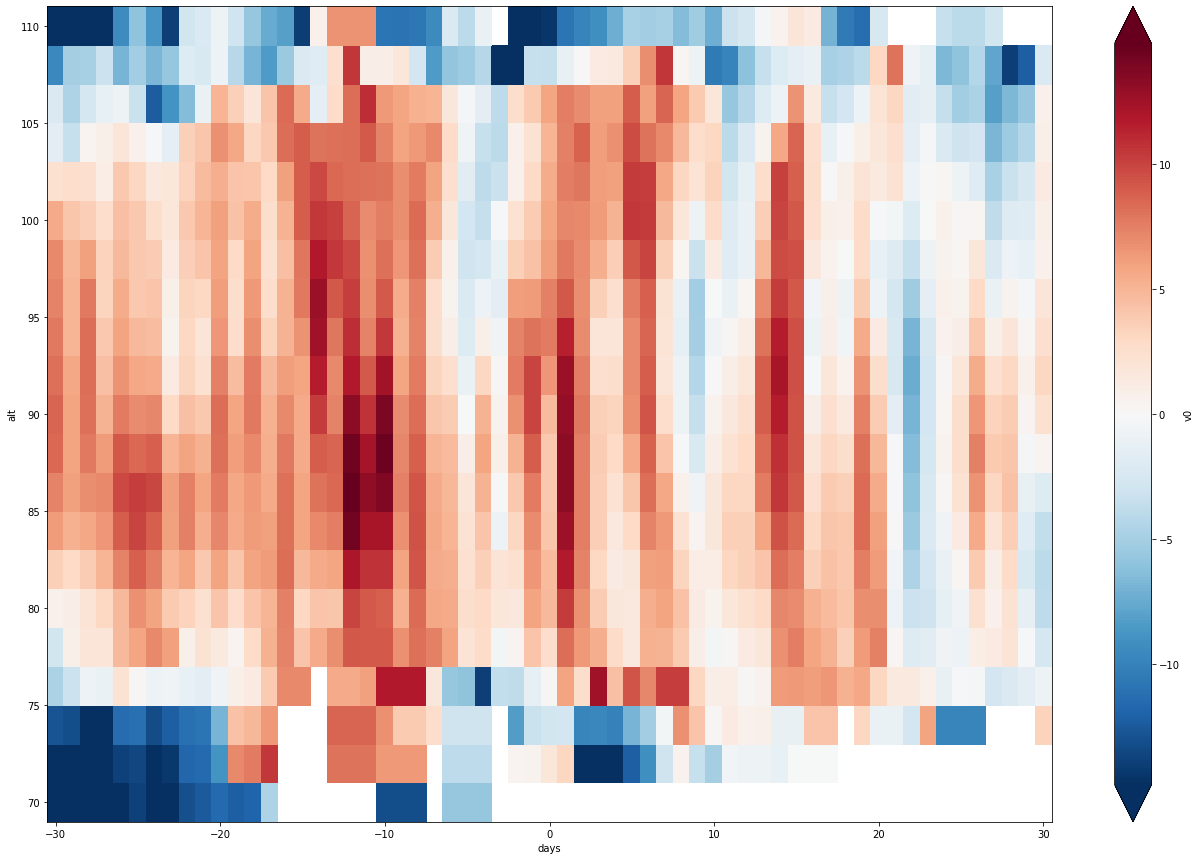

In [56]:
ax35 = sea_v_rio.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

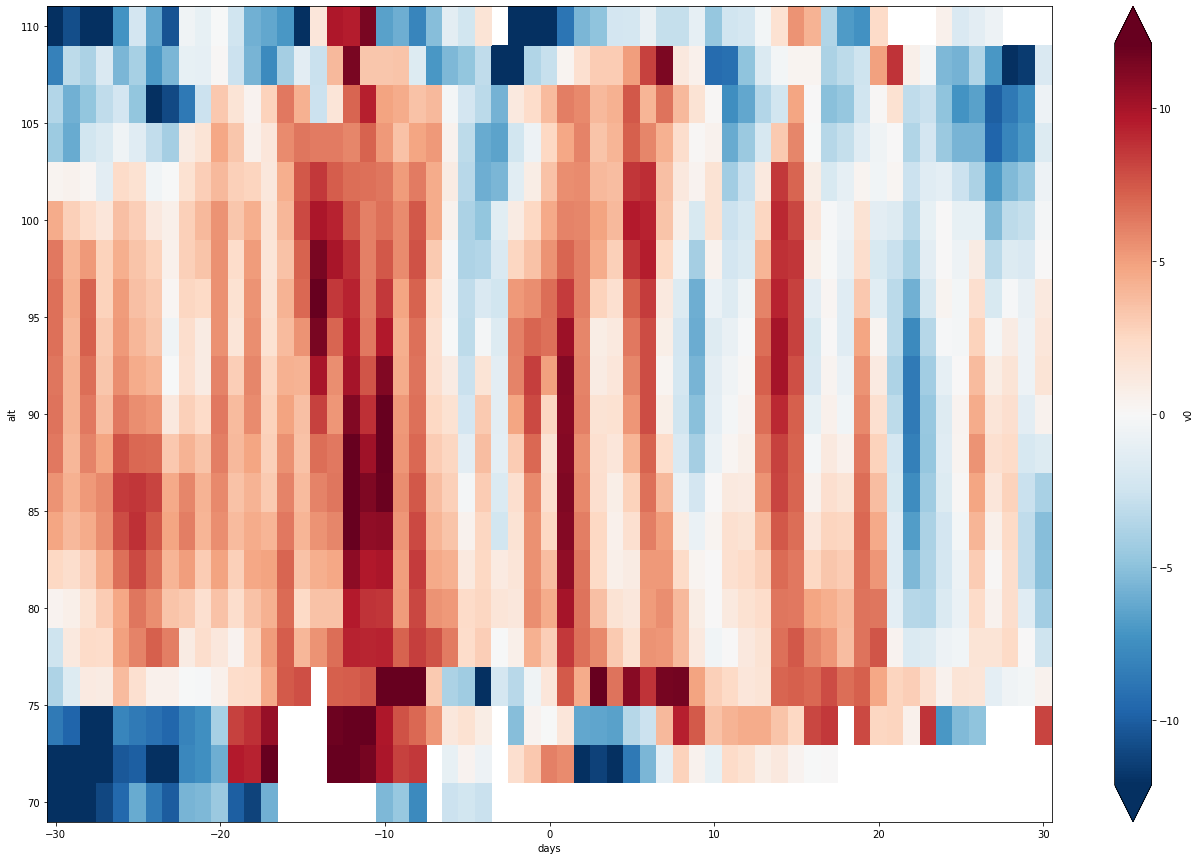

In [57]:
ax36 = sea_v_rio_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### CMA

In [58]:
ds_cma = read_group('wind','CMOR')
u_cma = read_var(ds_cma,'u0')
v_cma = read_var(ds_cma,'v0')

u_cma_anomalie = anomalie('day',u_cma)
# u_col_anomalie.plot(x='time',robust=True)

v_cma_anomalie = anomalie('day',v_cma)

sea_u_cma = sea(30,'CMOR',u_cma)
sea_u_cma_anomalie = sea(30,'CMOR',u_cma_anomalie)

sea_v_cma = sea(30,'CMOR',v_cma)
sea_v_cma_anomalie = sea(30,'CMOR',v_cma_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


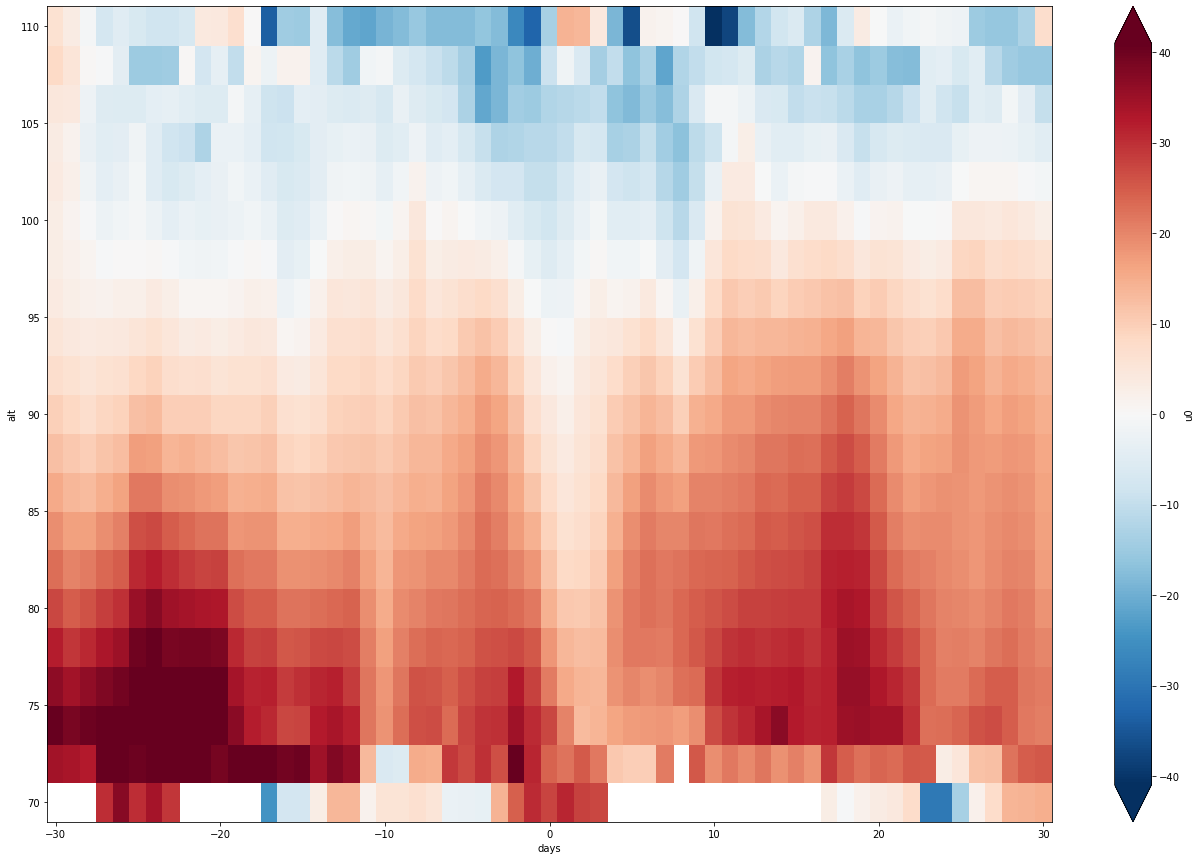

In [59]:
ax37 = sea_u_cma.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

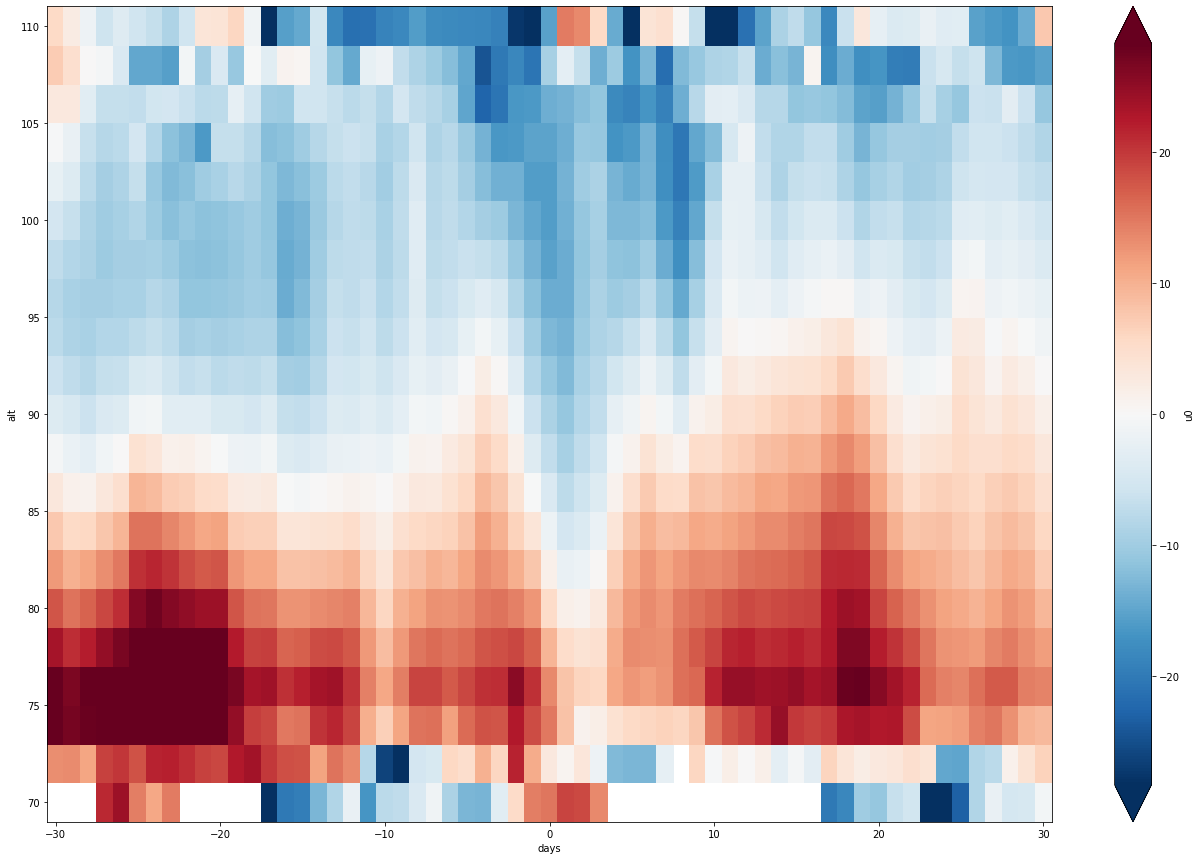

In [60]:
ax38 = sea_u_cma_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

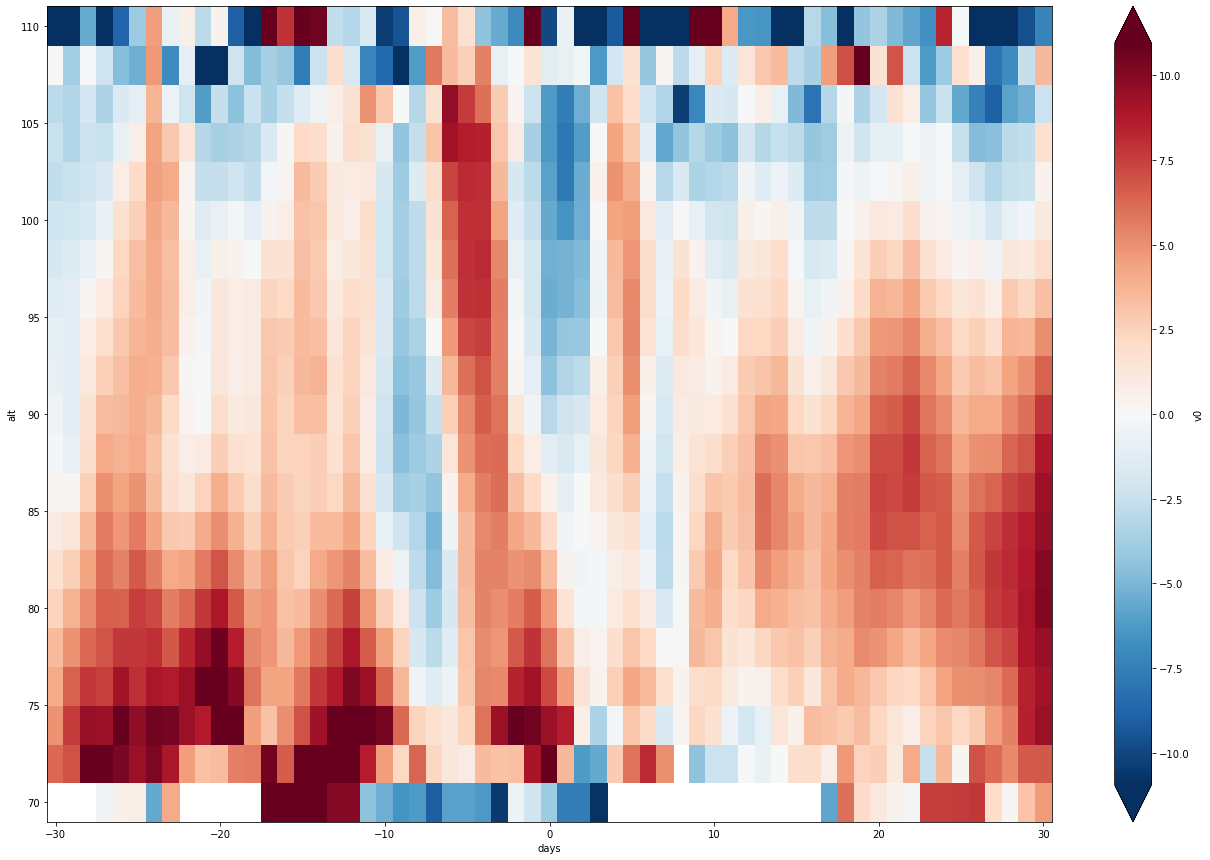

In [61]:
ax39 = sea_v_cma.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

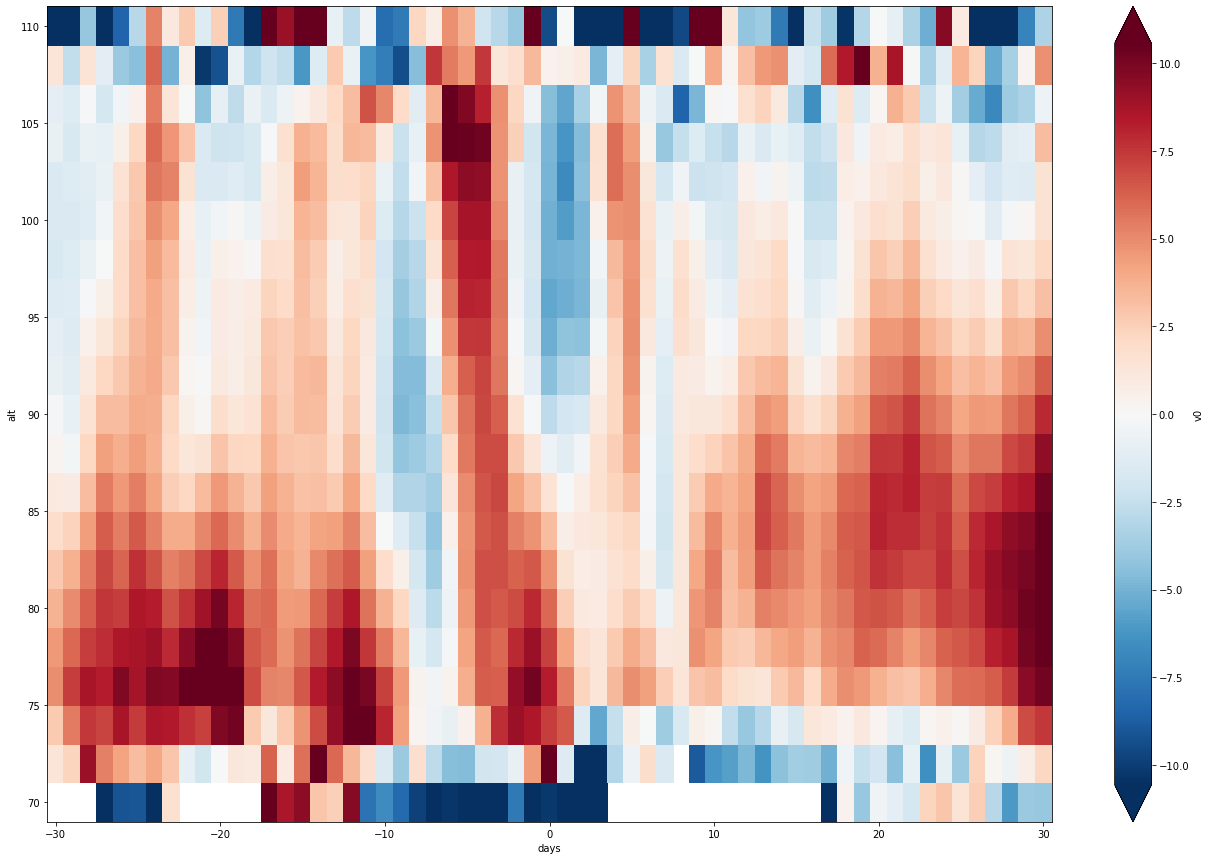

In [62]:
ax40 = sea_v_cma_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

## Waves

### Leipzig

In [113]:
waves_col = read_group('waves','Leipzig')
gw_col = read_var(waves_col,'GW')
pw_col = read_var(waves_col,'PW')

gw_col_anomalie = anomalie('day',gw_col)
# u_col_anomalie.plot(x='time',robust=True)

pw_col_anomalie = anomalie('day',pw_col)

sea_gw_col = sea(60,'Leipzig',gw_col)
sea_gw_col_anomalie = sea(60,'Leipzig',gw_col_anomalie)

sea_pw_col = sea(60,'Leipzig',pw_col)
sea_pw_col_anomalie = sea(60,'Leipzig',pw_col_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


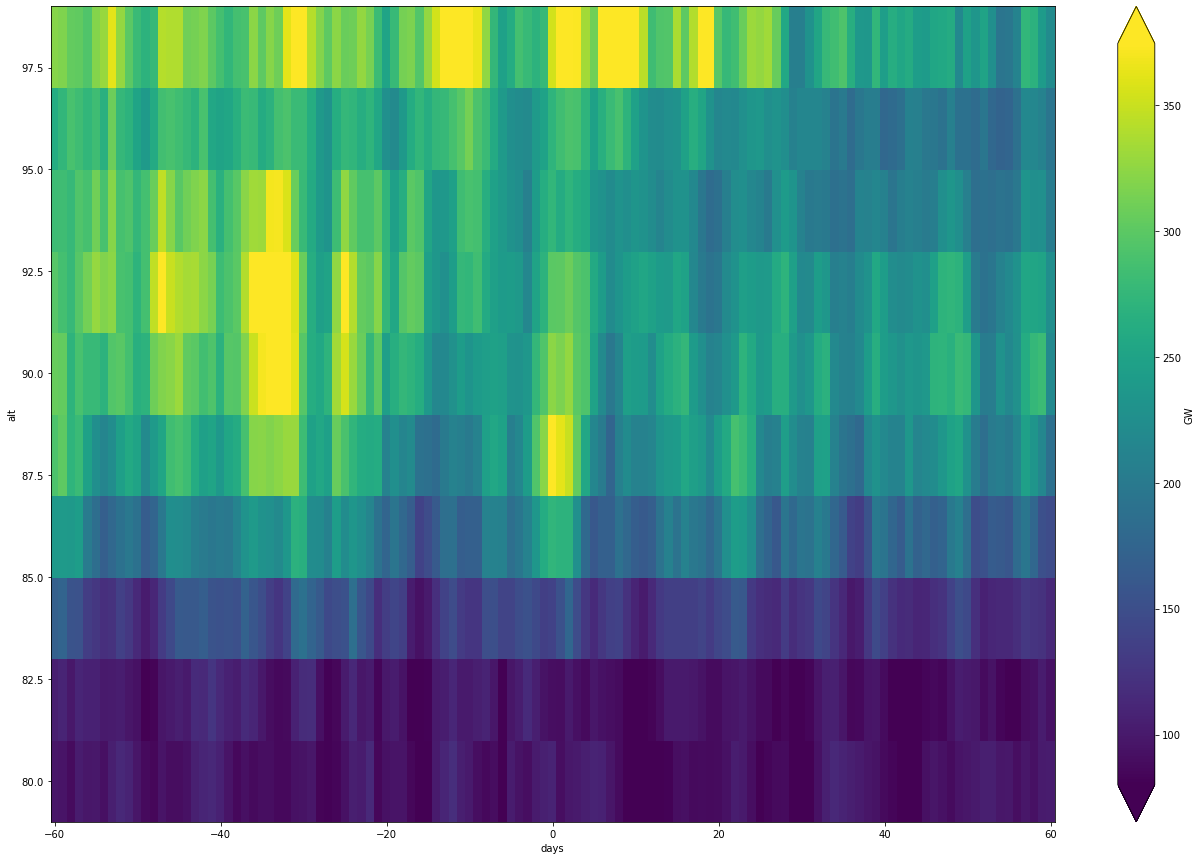

In [117]:
ax41 = sea_gw_col.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

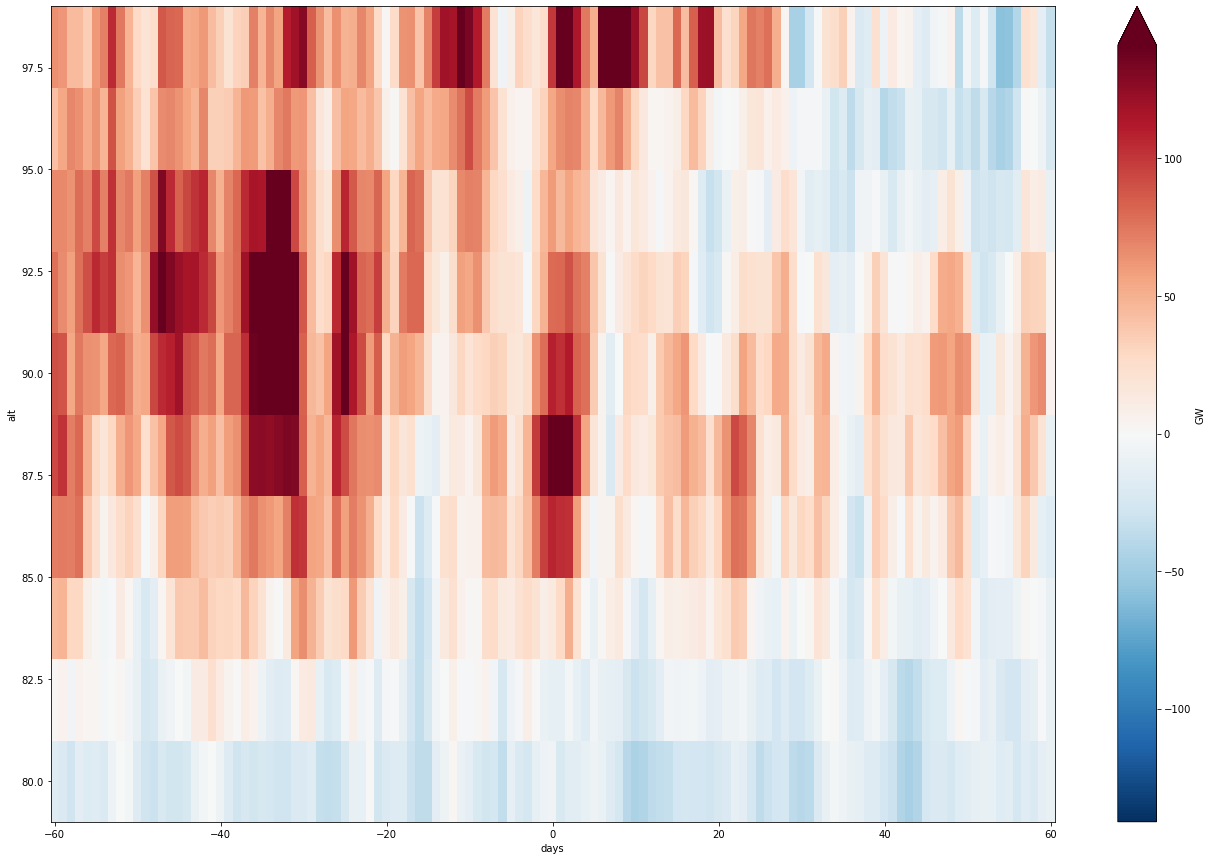

In [118]:
ax42 = sea_gw_col_anomalie.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

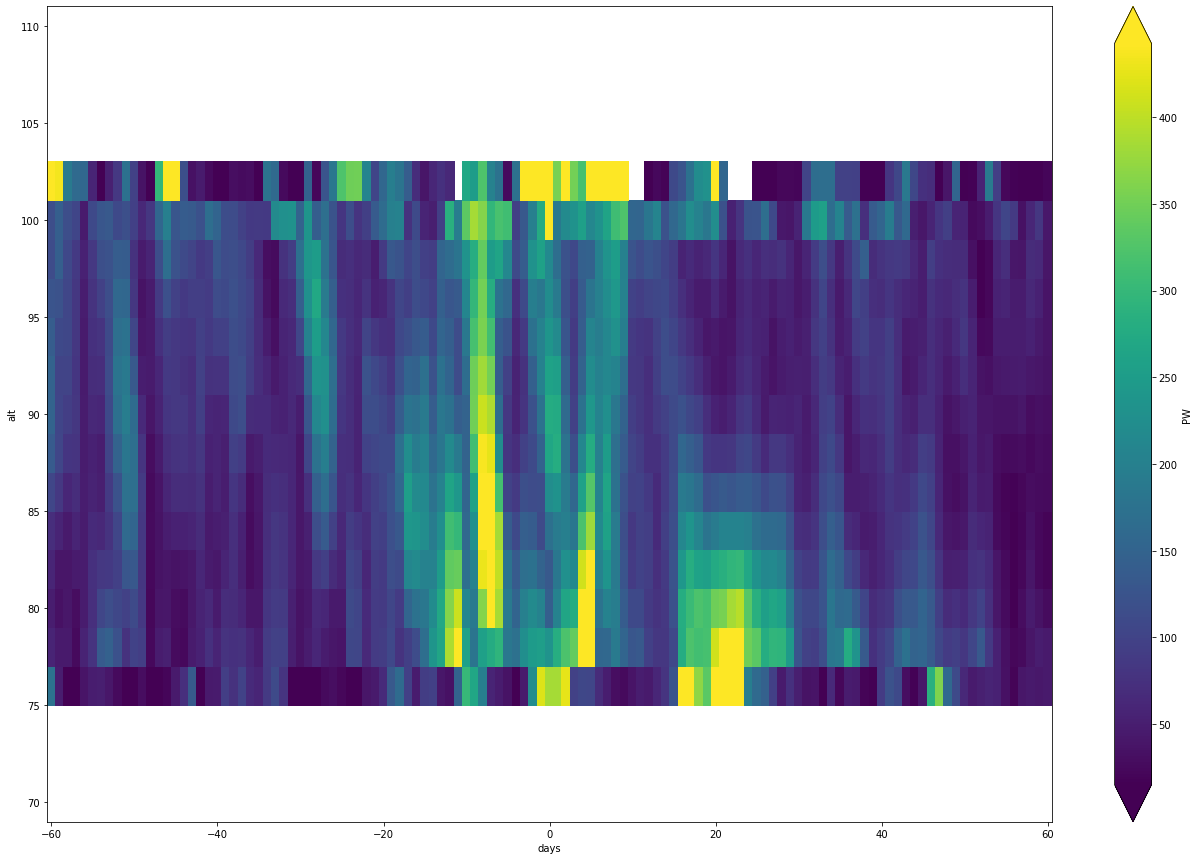

In [66]:
ax43 = sea_pw_col.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

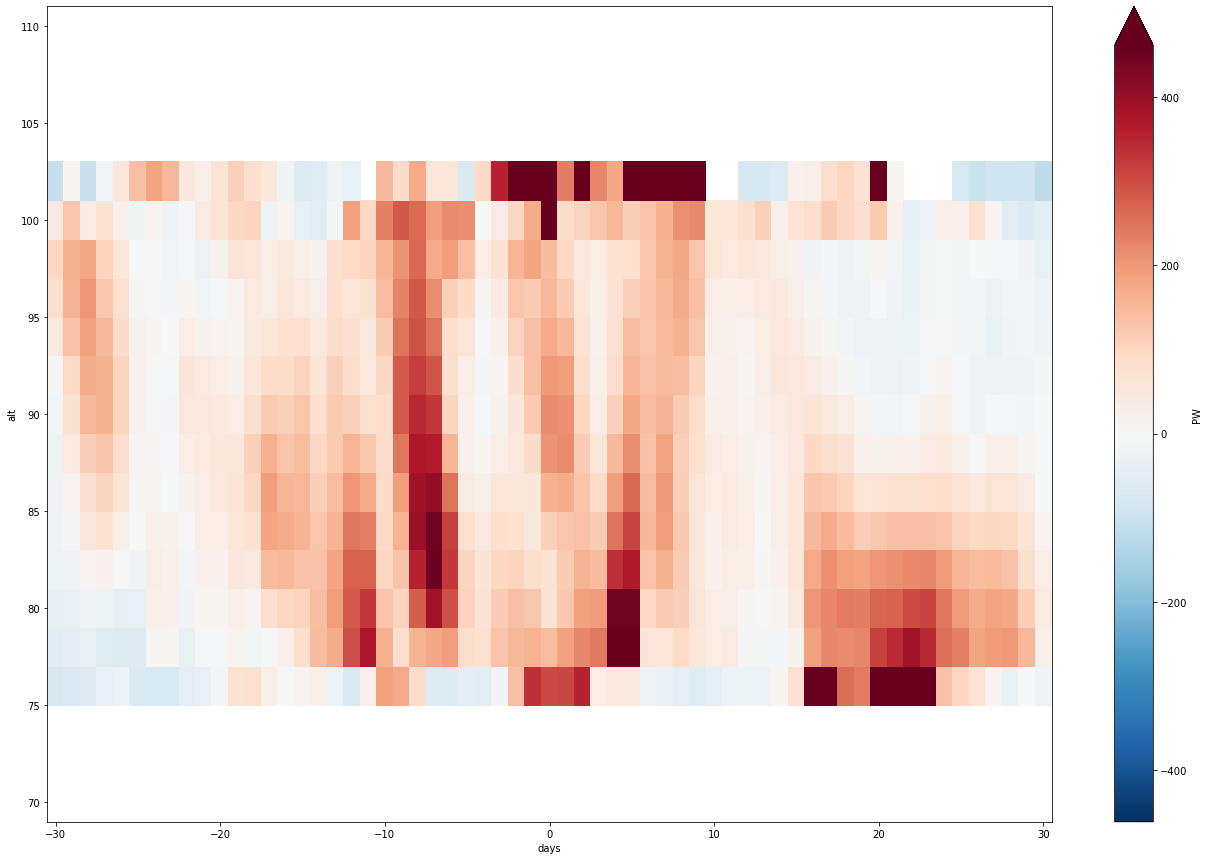

In [67]:
ax44 = sea_pw_col_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Andenes

In [123]:
waves_and = read_group('waves','Andenes')
gw_and = read_var(waves_and,'GW')
pw_and = read_var(waves_and,'PW')

gw_and_anomalie = anomalie('day',gw_and)

pw_and_anomalie = anomalie('day',pw_and)

sea_gw_and = sea(60,'Andenes',gw_and)
sea_gw_and_anomalie = sea(60,'Andenes',gw_and_anomalie)

sea_pw_and = sea(60,'Andenes',pw_and)
sea_pw_and_anomalie = sea(60,'Andenes',pw_and_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


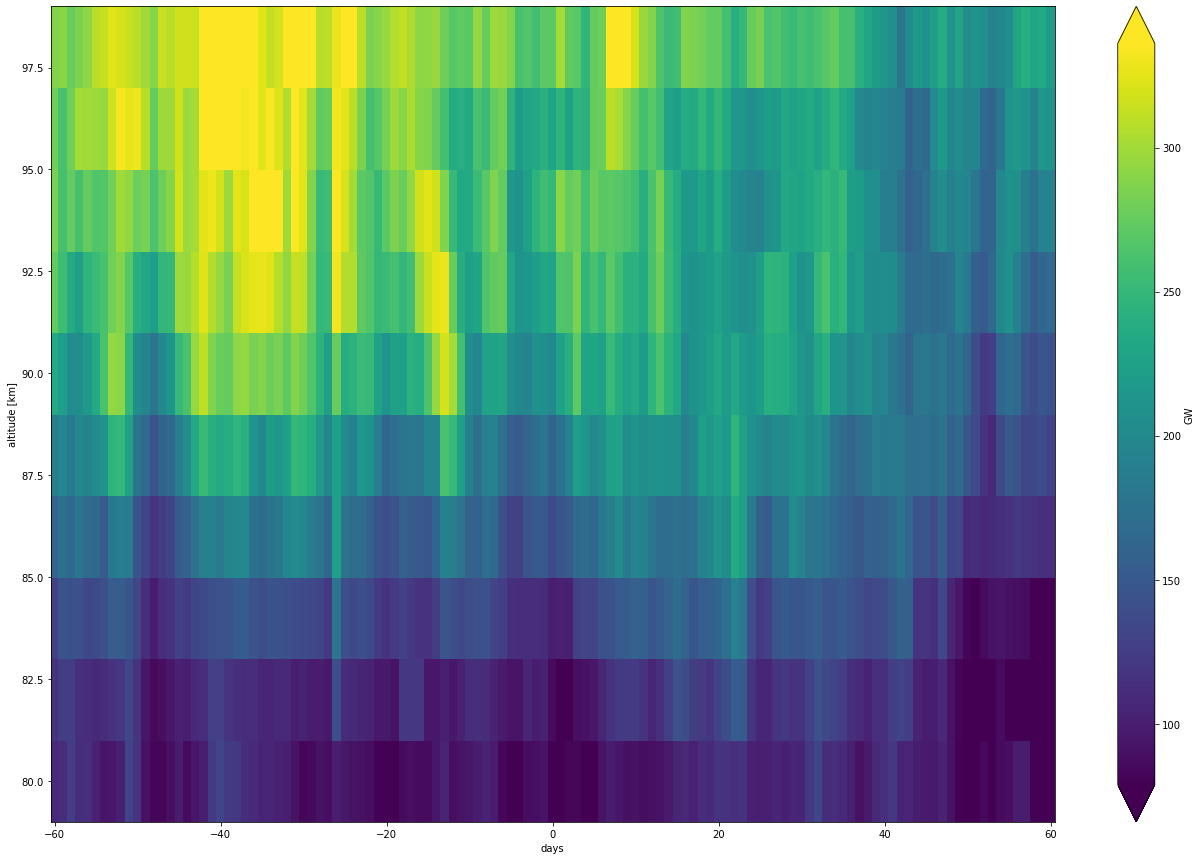

In [124]:
ax45 = sea_gw_and.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

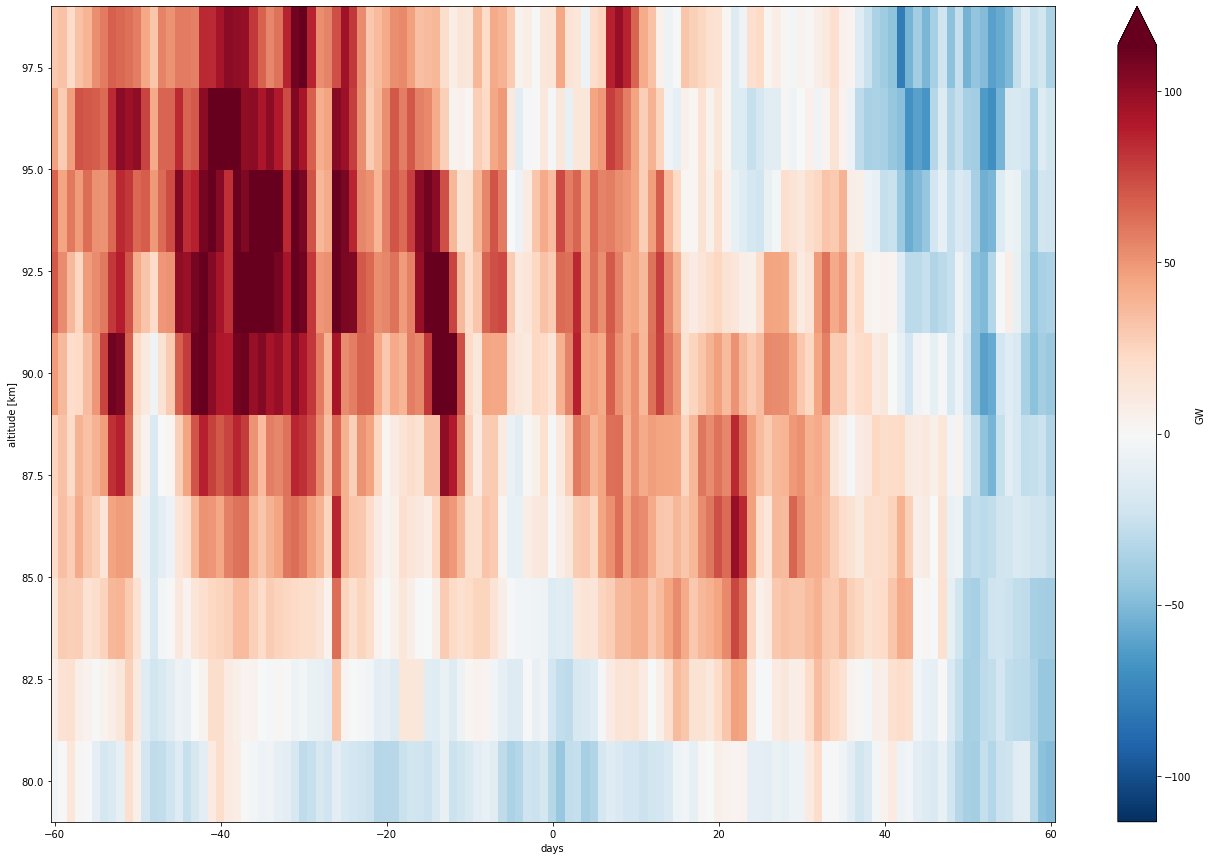

In [126]:
ax46 = sea_gw_and_anomalie.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

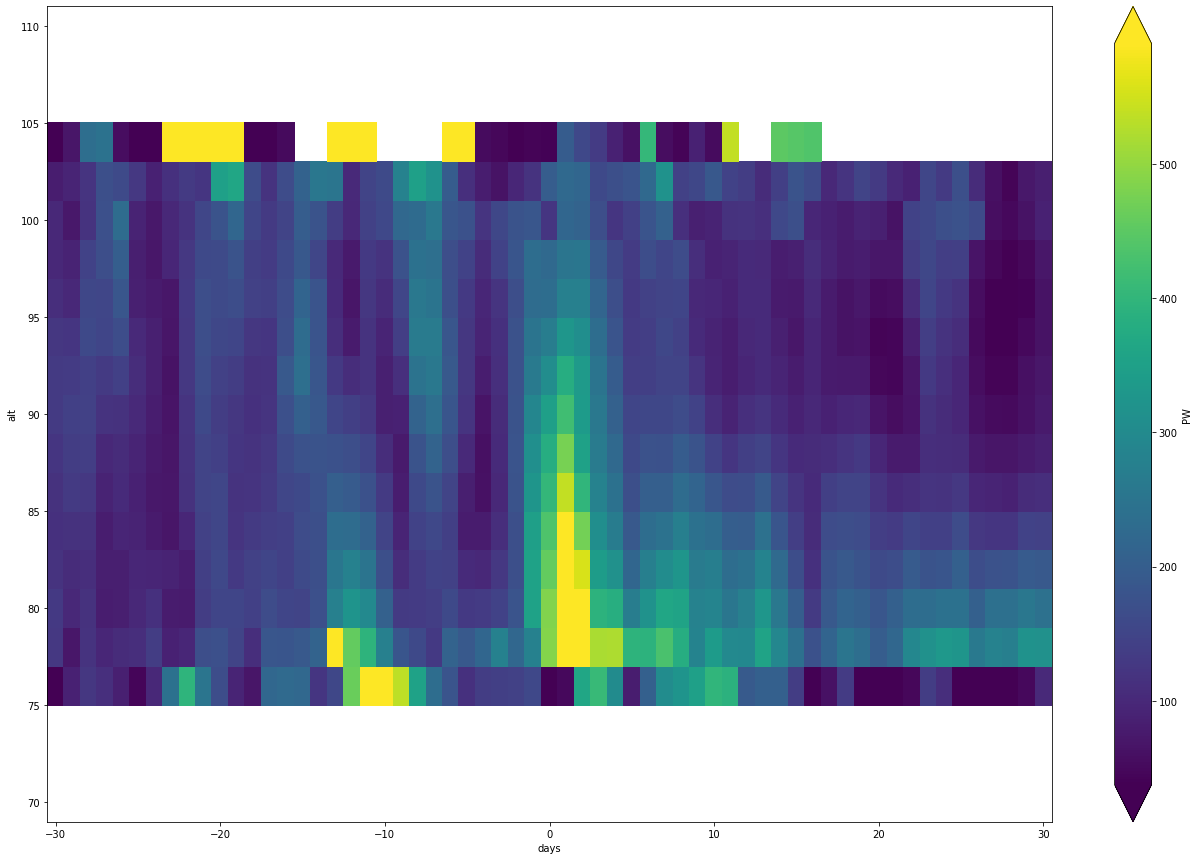

In [71]:
ax47 = sea_pw_and.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

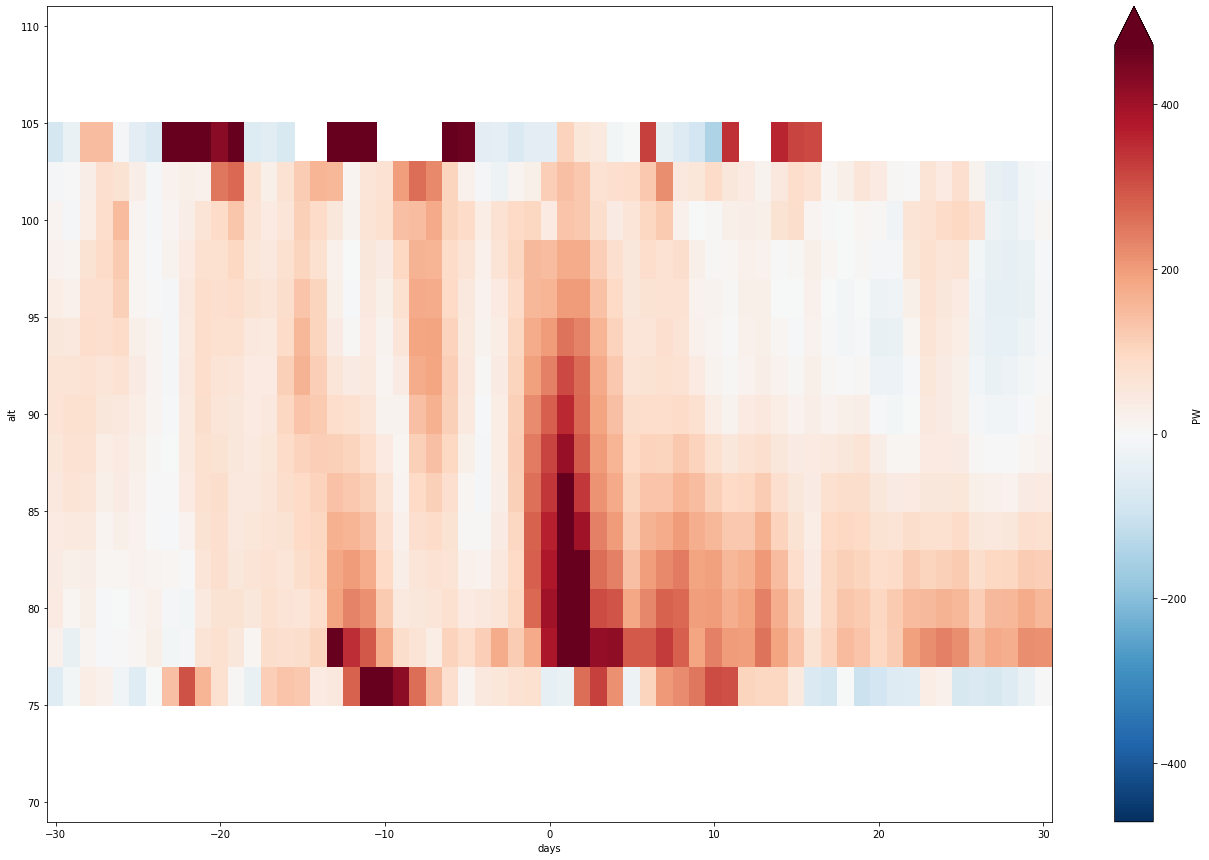

In [72]:
ax48 = sea_pw_and_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Andenes/Kiruna

In [127]:
waves_and_kir = read_group('waves','Andenes_Kiruna')
gw_and_kir = read_var(waves_and_kir,'GW')
pw_and_kir = read_var(waves_and_kir,'PW')

gw_and_kir_anomalie = anomalie('day',gw_and_kir)

pw_and_kir_anomalie = anomalie('day',pw_and_kir)

sea_gw_and_kir = sea(60,'Andenes_Kiruna',gw_and_kir)
sea_gw_and_kir_anomalie = sea(60,'Andenes_Kiruna',gw_and_kir_anomalie)

sea_pw_and_kir = sea(60,'Andenes_Kiruna',pw_and_kir)
sea_pw_and_kir_anomalie = sea(60,'Andenes_Kiruna',pw_and_kir_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


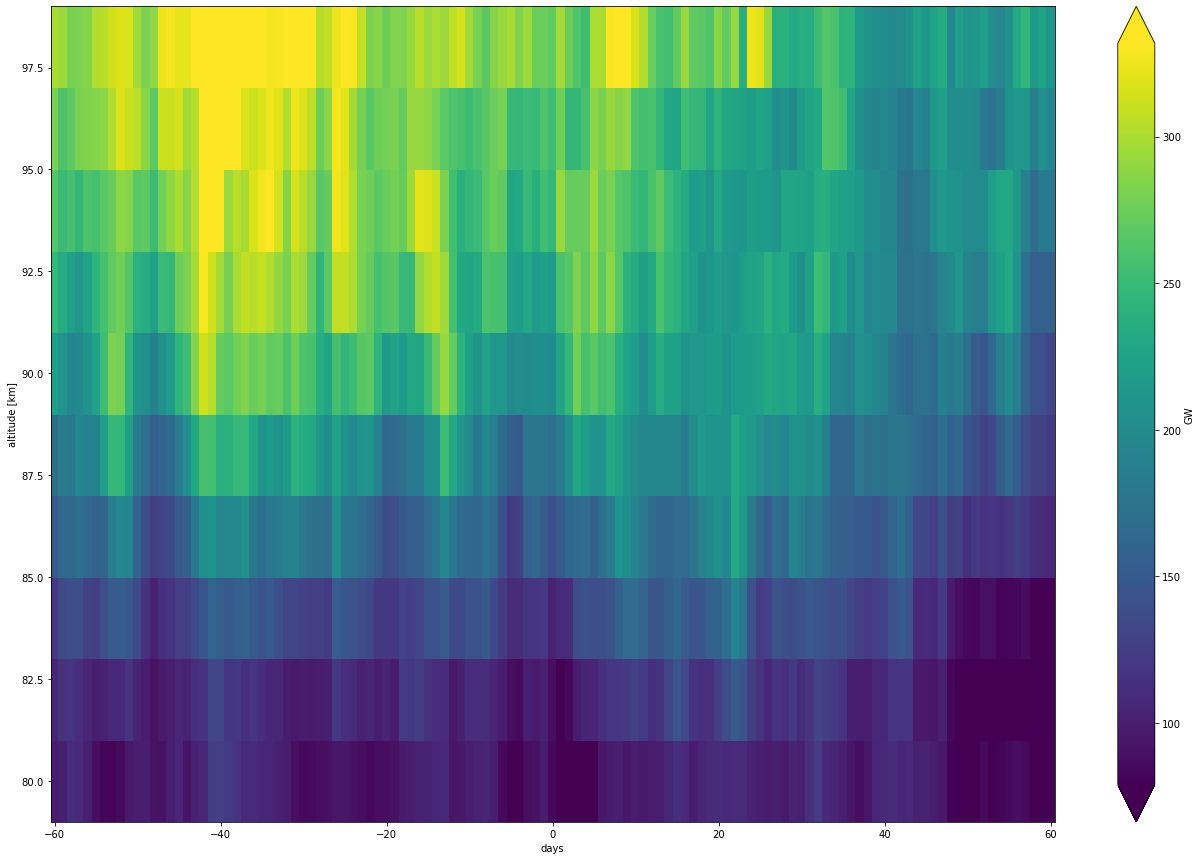

In [128]:
ax49 = sea_gw_and_kir.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

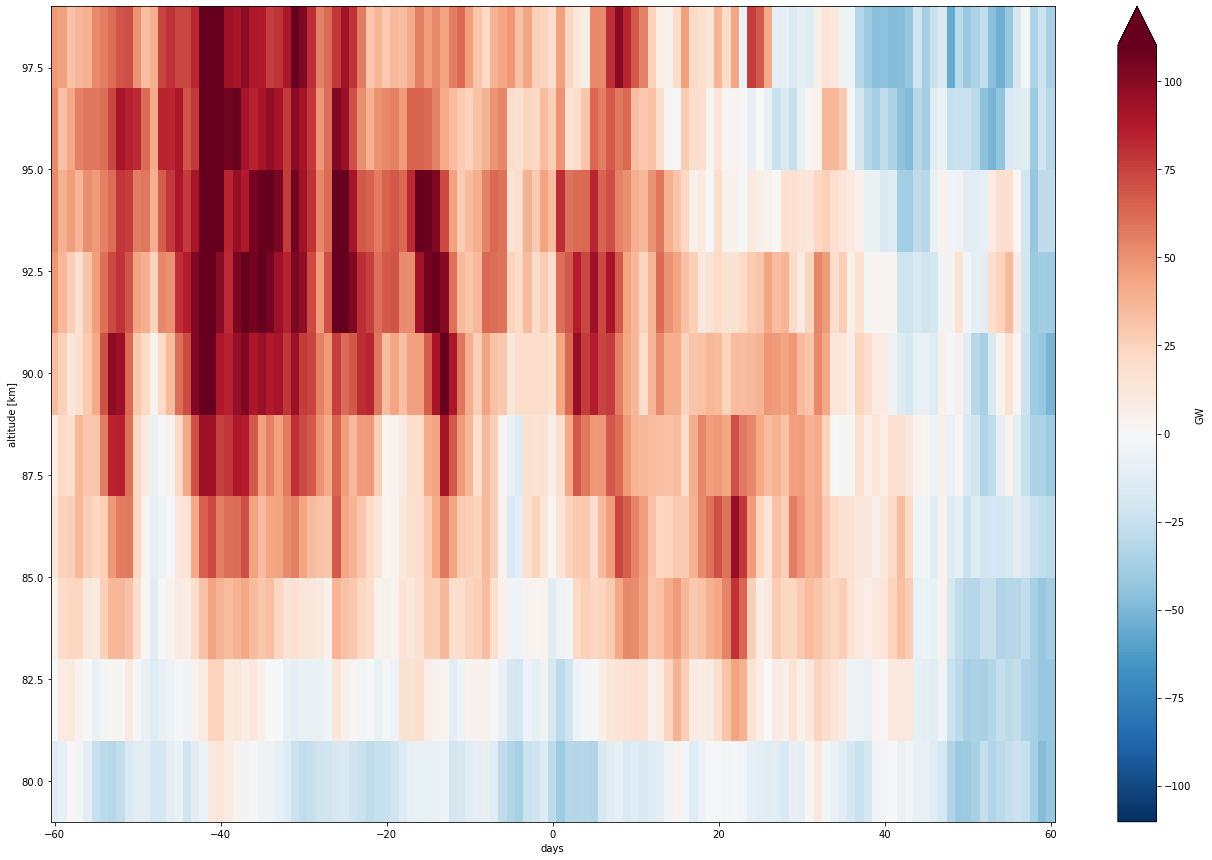

In [129]:
ax50 = sea_gw_and_kir_anomalie.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

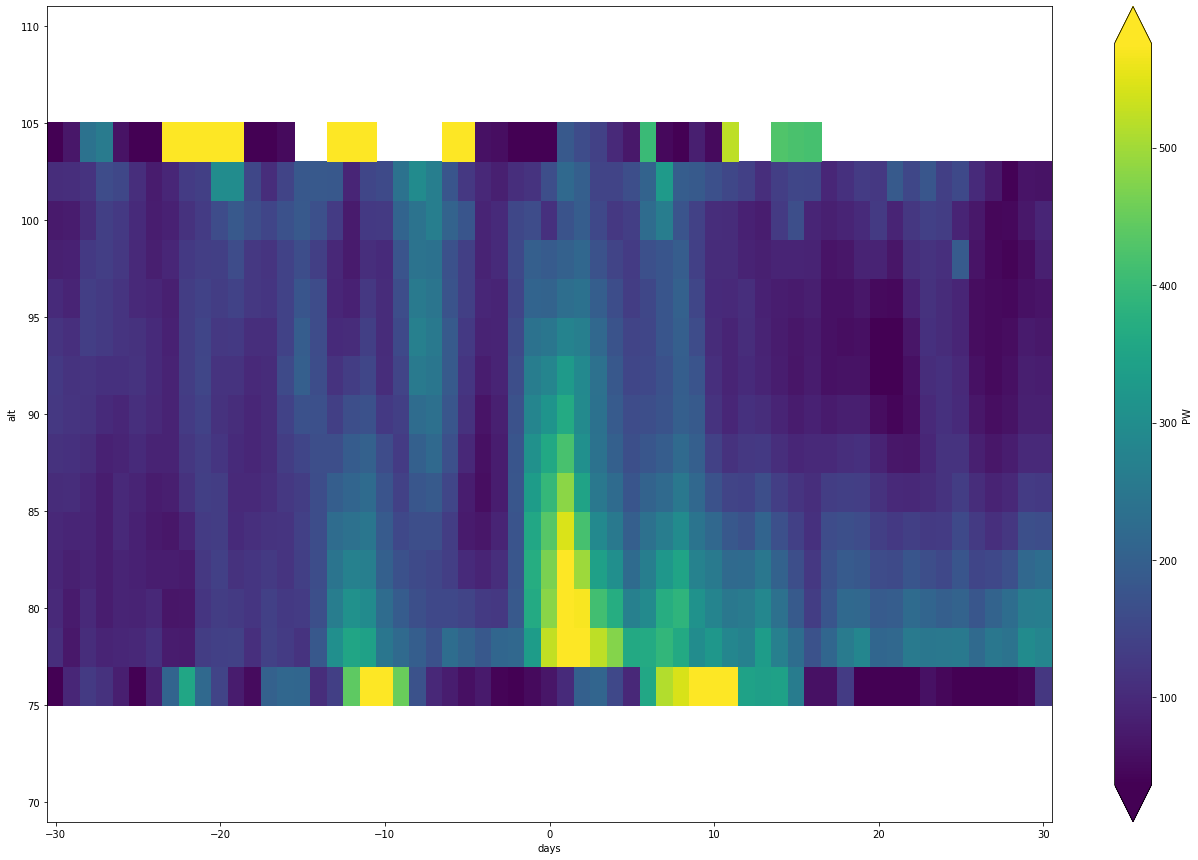

In [76]:
ax51 = sea_pw_and_kir.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

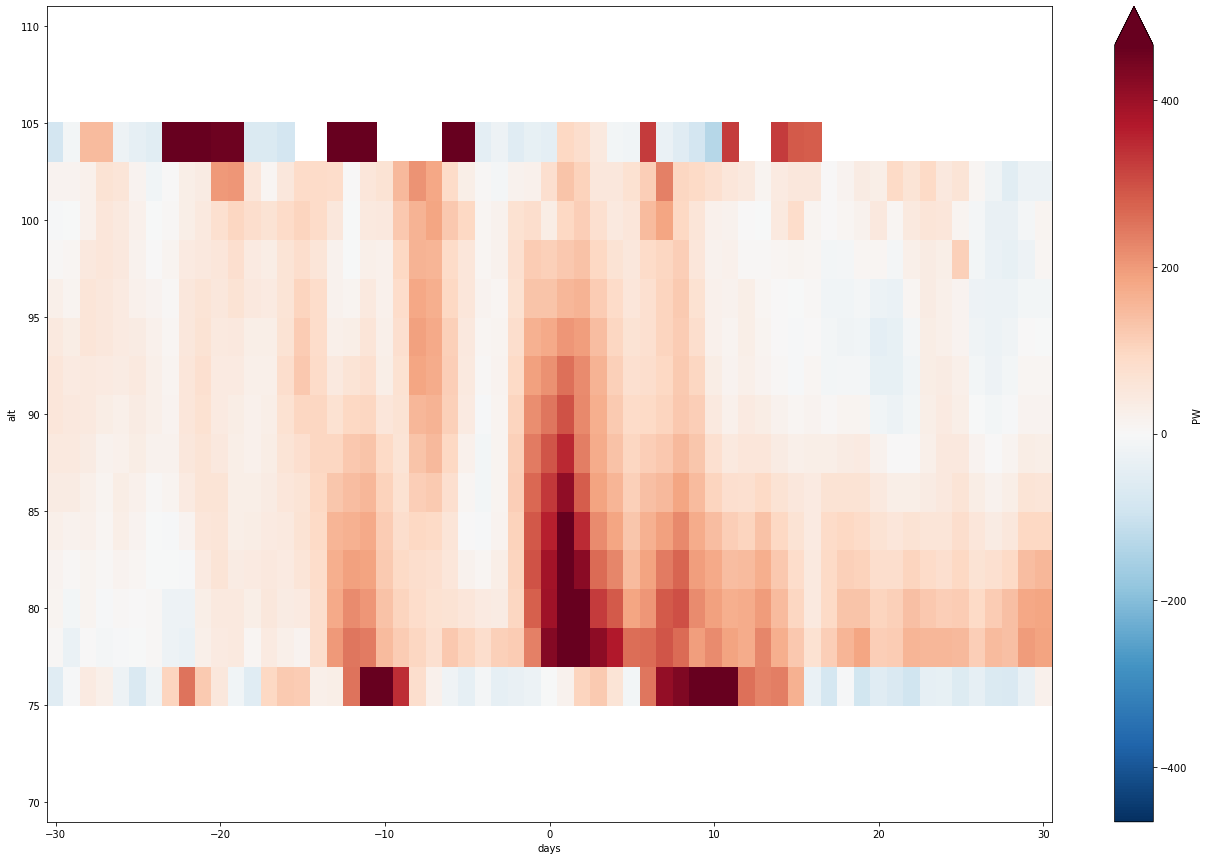

In [77]:
ax52 = sea_pw_and_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Sodankyla/Kiruna

In [130]:
waves_sod_kir = read_group('waves','Sodankyla_Kiruna')
gw_sod_kir = read_var(waves_sod_kir,'GW')
pw_sod_kir = read_var(waves_sod_kir,'PW')

gw_sod_kir_anomalie = anomalie('day',gw_sod_kir)

pw_sod_kir_anomalie = anomalie('day',pw_sod_kir)

sea_gw_sod_kir = sea(60,'Sodankyla_Kiruna',gw_sod_kir)
sea_gw_sod_kir_anomalie = sea(60,'Sodankyla_Kiruna',gw_sod_kir_anomalie)

sea_pw_sod_kir = sea(60,'Sodankyla_Kiruna',pw_sod_kir)
sea_pw_sod_kir_anomalie = sea(60,'Sodankyla_Kiruna',pw_sod_kir_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


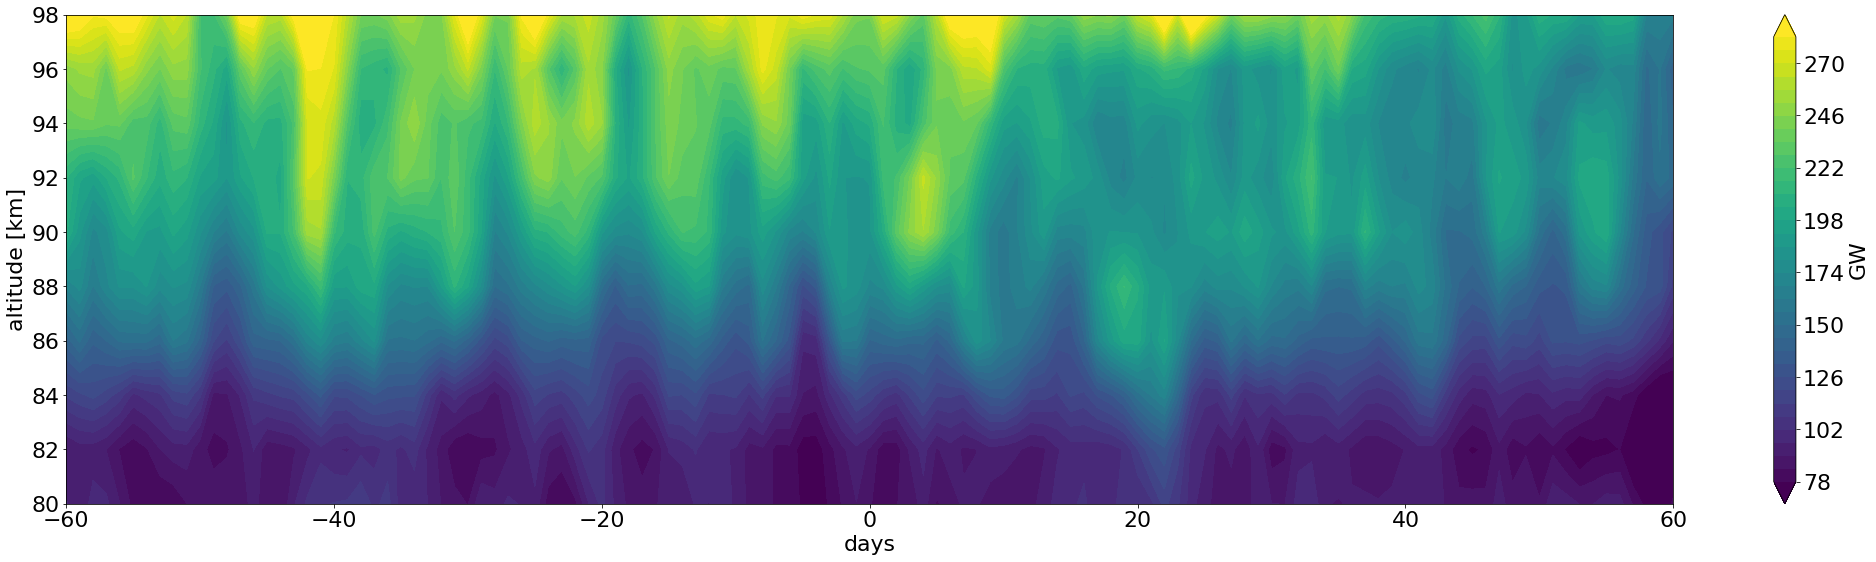

In [139]:
ax53 = sea_gw_sod_kir.sel(alt = slice(79,99)).plot.contourf(x='days',size=9,robust=True, levels =41, aspect=4)

In [137]:
plt.rcParams['font.size'] = '22'

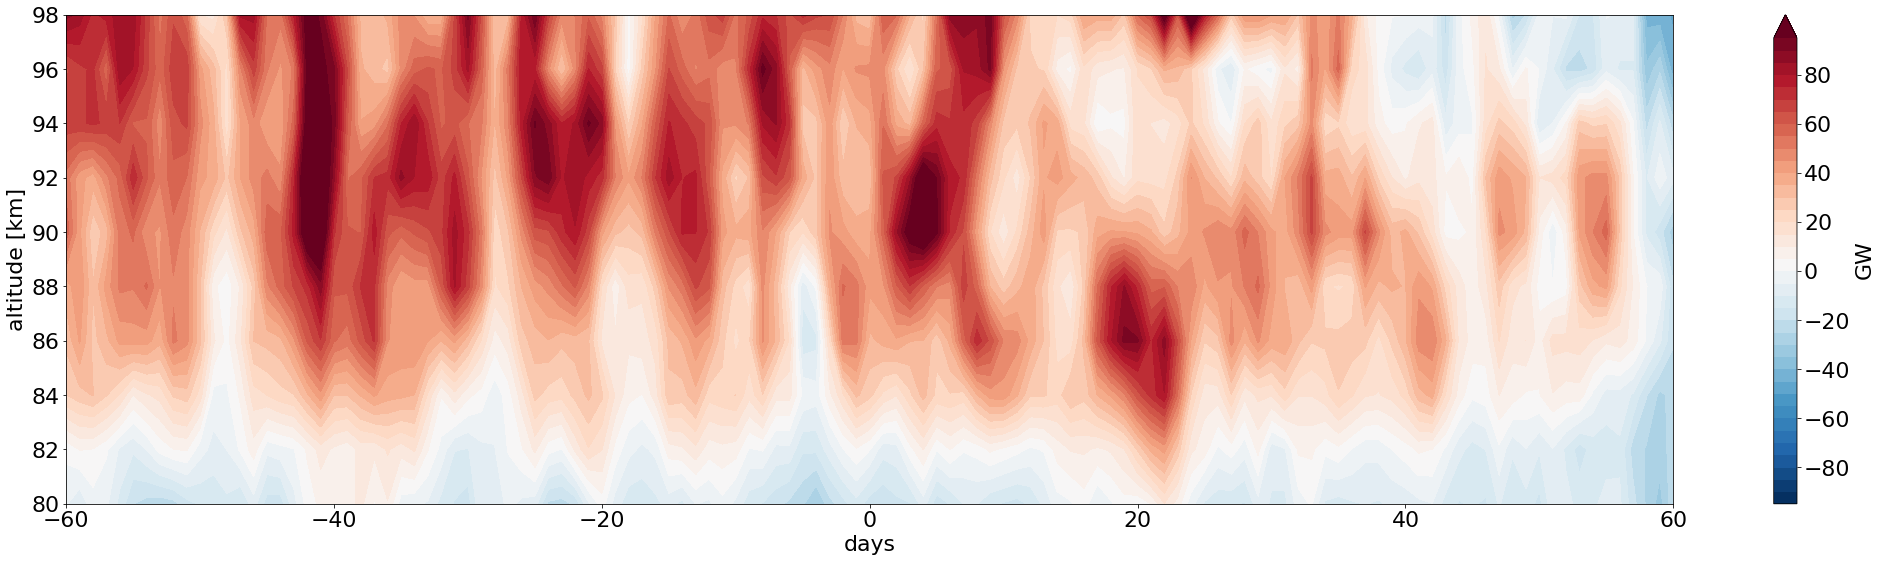

In [138]:
ax54 = sea_gw_sod_kir_anomalie.sel(alt = slice(79,99)).plot.contourf(x='days',size=9,robust=True, levels =41, aspect=4)

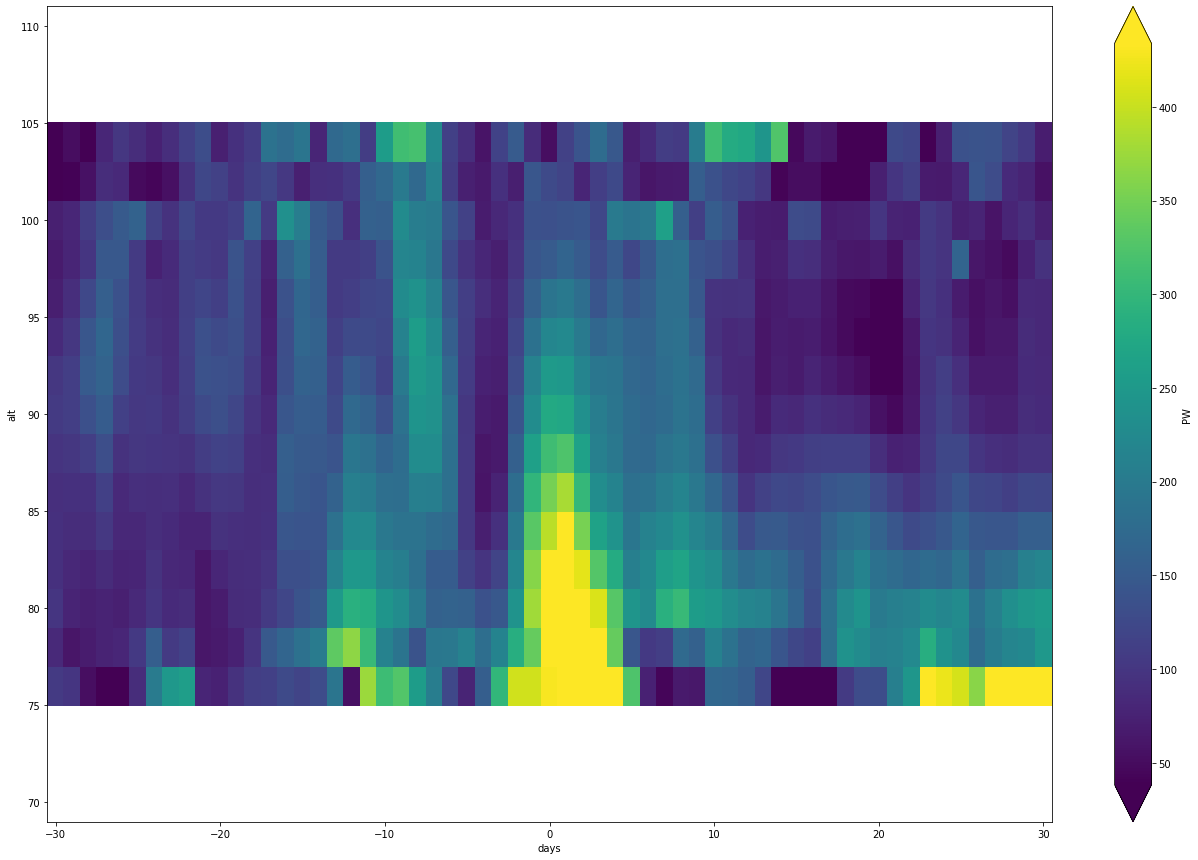

In [81]:
ax55 = sea_pw_sod_kir.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

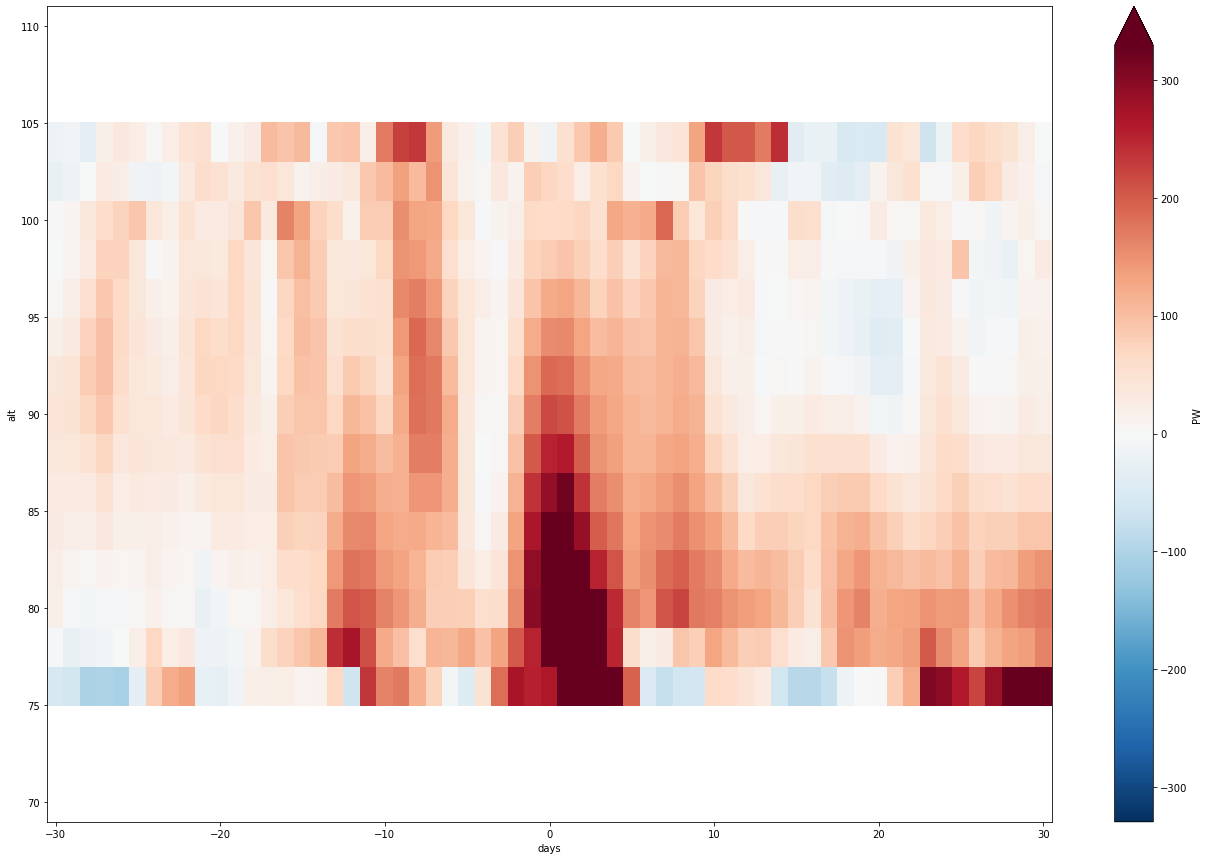

In [82]:
ax56 = sea_pw_sod_kir_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Sodankyla

In [83]:
waves_sod = read_group('waves','Sodankyla')
gw_sod = read_var(waves_sod,'GW')
pw_sod = read_var(waves_sod,'PW')

gw_sod_anomalie = anomalie('day',gw_sod)

pw_sod_anomalie = anomalie('day',pw_sod)

sea_gw_sod = sea(30,'Sodankyla',gw_sod)
sea_gw_sod_anomalie = sea(30,'Sodankyla',gw_sod_anomalie)

sea_pw_sod = sea(30,'Sodankyla',pw_sod)
sea_pw_sod_anomalie = sea(30,'Sodankyla',pw_sod_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


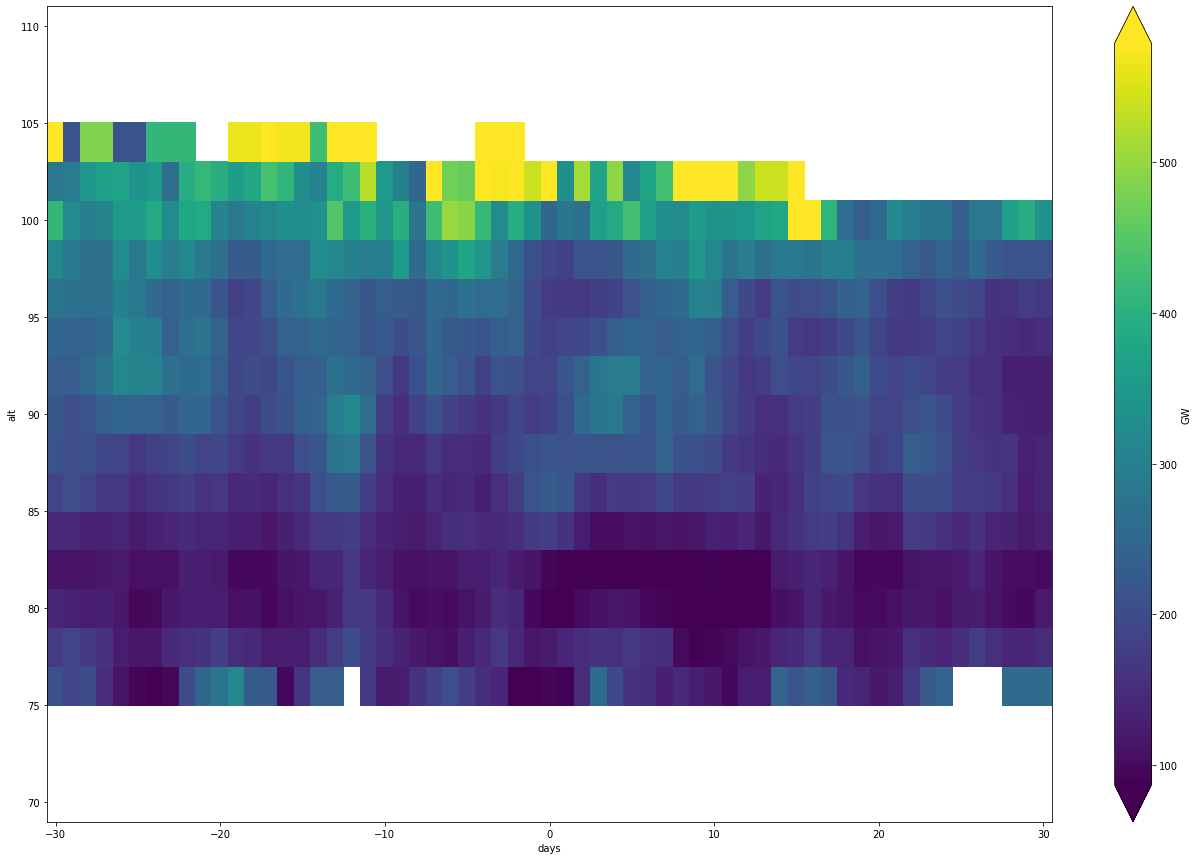

In [84]:
ax57 = sea_gw_sod.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

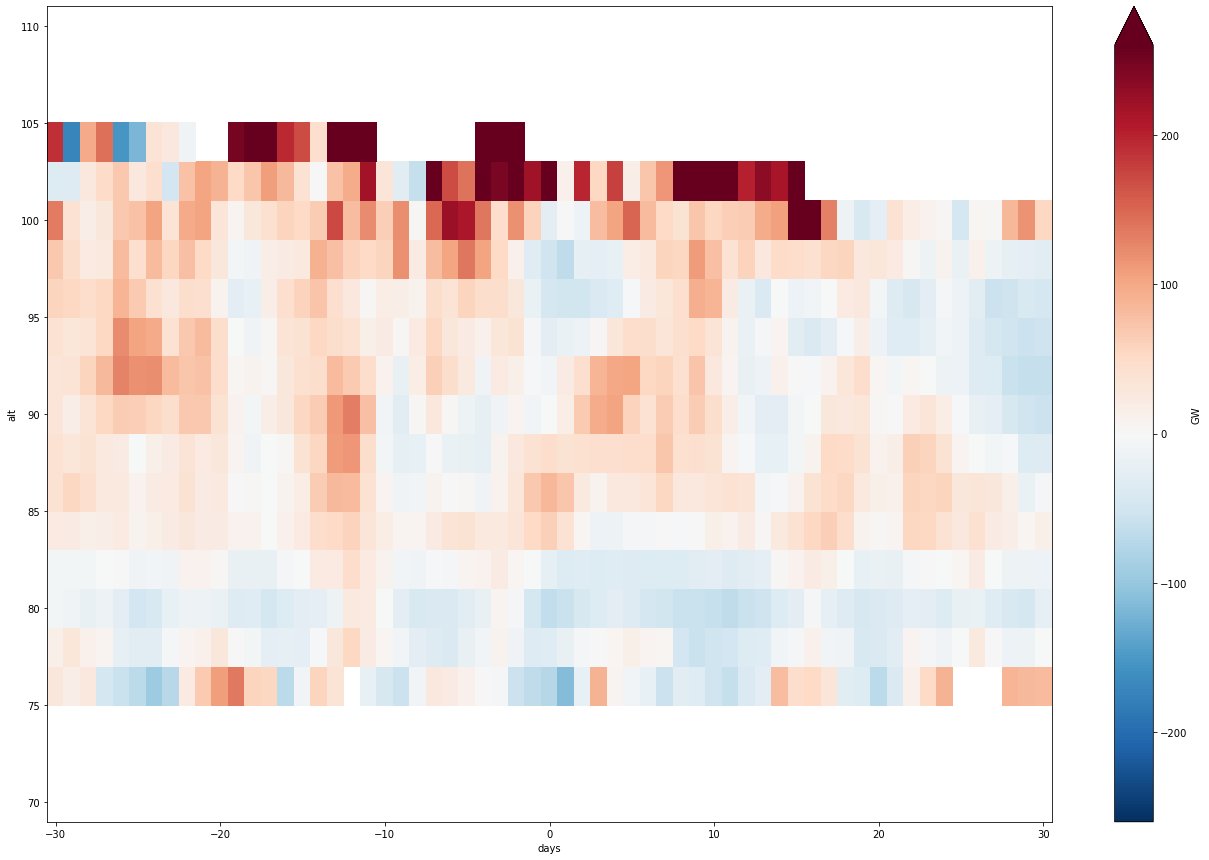

In [85]:
ax58 = sea_gw_sod_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

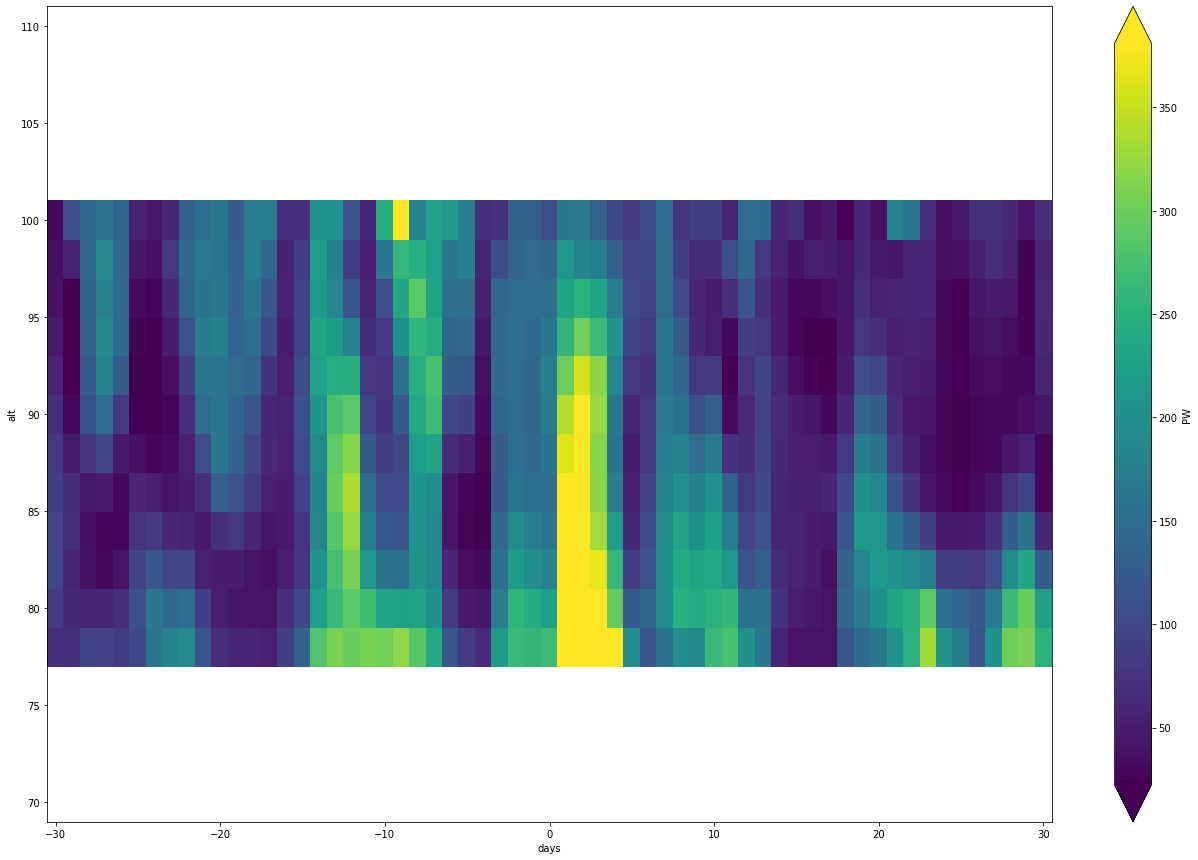

In [86]:
ax59 = sea_pw_sod.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

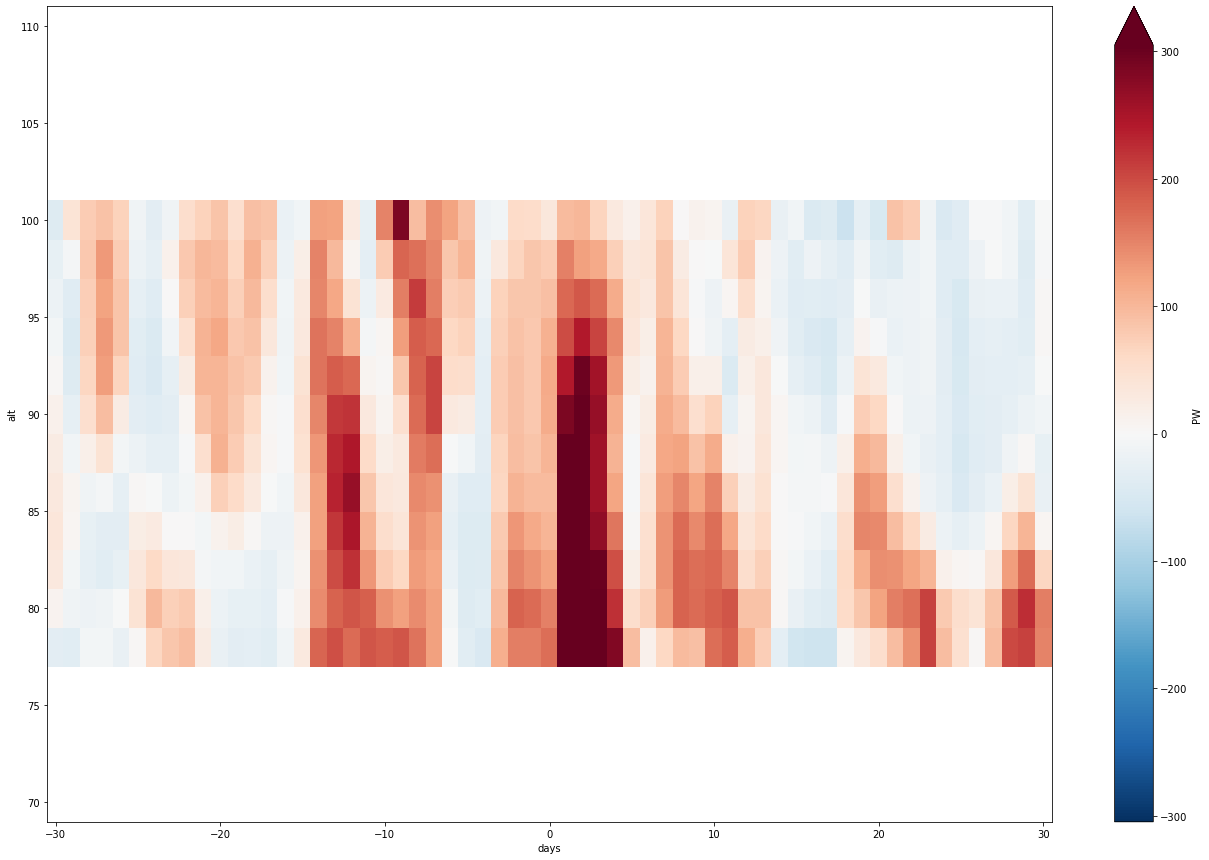

In [87]:
ax60 = sea_pw_sod_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Esrange (Kiruna)

In [88]:
waves_esr = read_group('waves','Esrange')
gw_esr = read_var(waves_esr,'GW')
pw_esr = read_var(waves_esr,'PW')

gw_esr_anomalie = anomalie('day',gw_esr)

pw_esr_anomalie = anomalie('day',pw_esr)

sea_gw_esr = sea(30,'Esrange',gw_esr)
sea_gw_esr_anomalie = sea(30,'Esrange',gw_esr_anomalie)

sea_pw_esr = sea(30,'Esrange',pw_esr)
sea_pw_esr_anomalie = sea(30,'Esrange',pw_esr_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


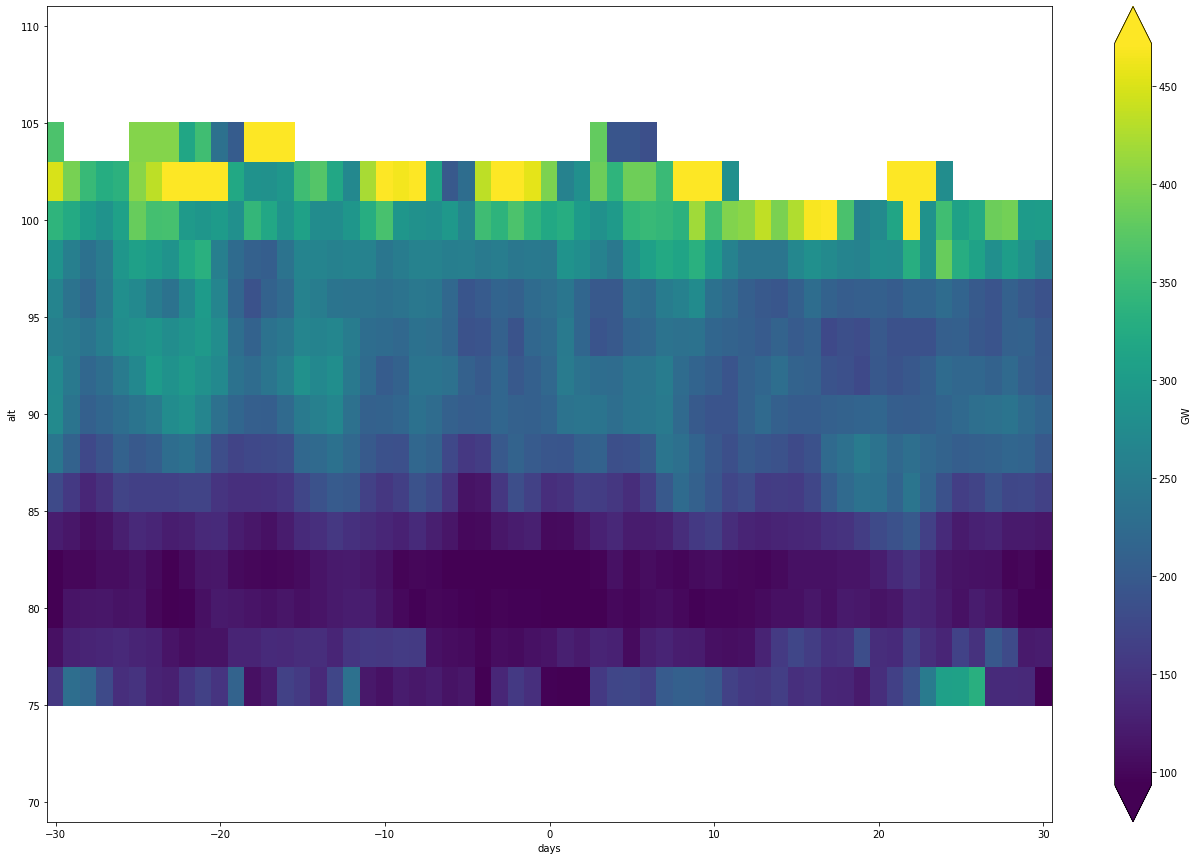

In [89]:
ax61 = sea_gw_esr.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

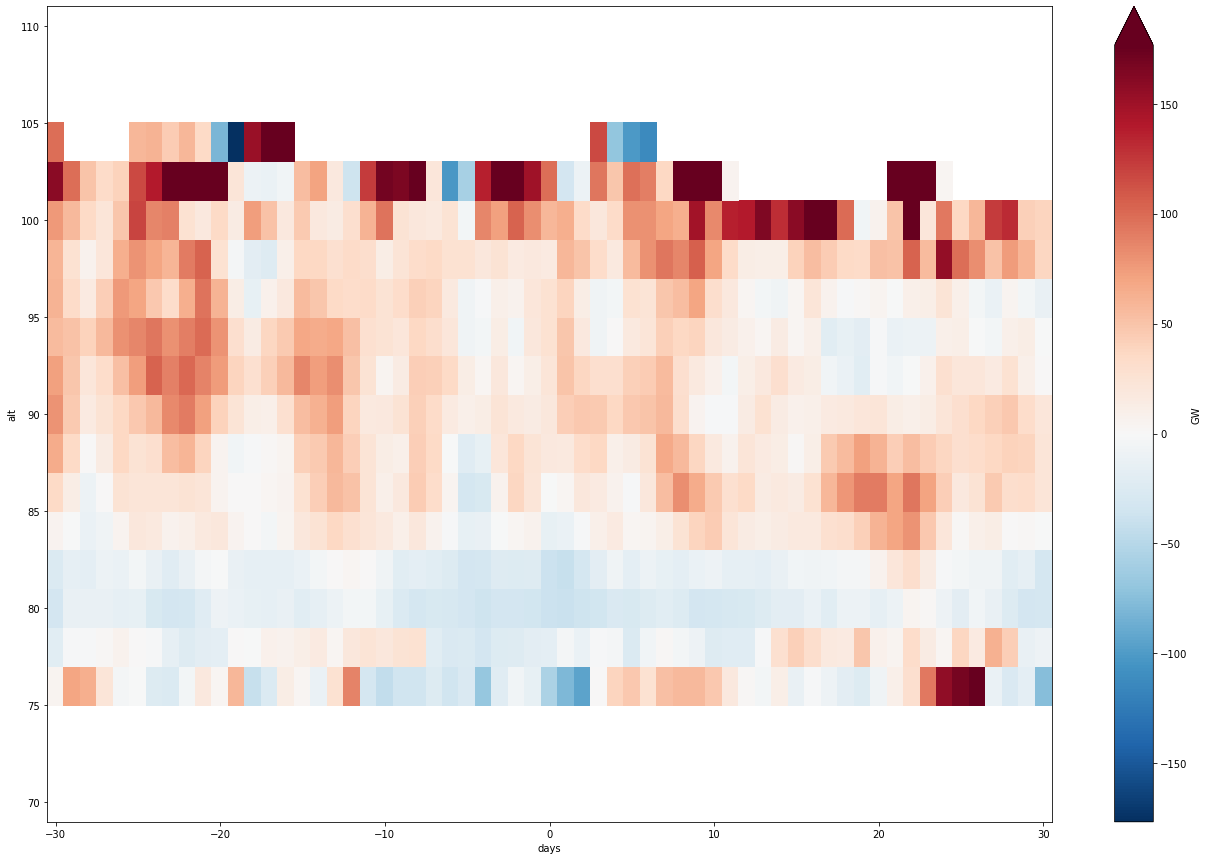

In [90]:
ax62 = sea_gw_esr_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

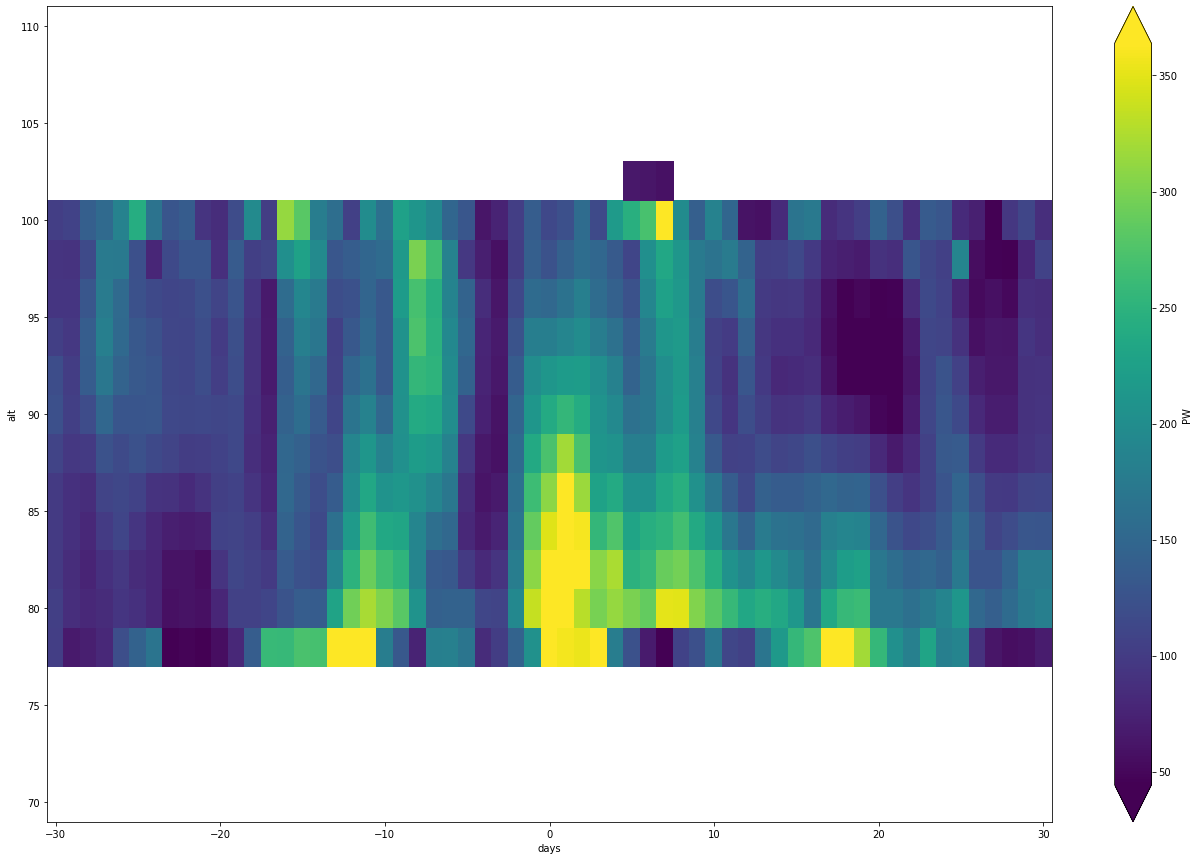

In [91]:
ax63 = sea_pw_esr.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

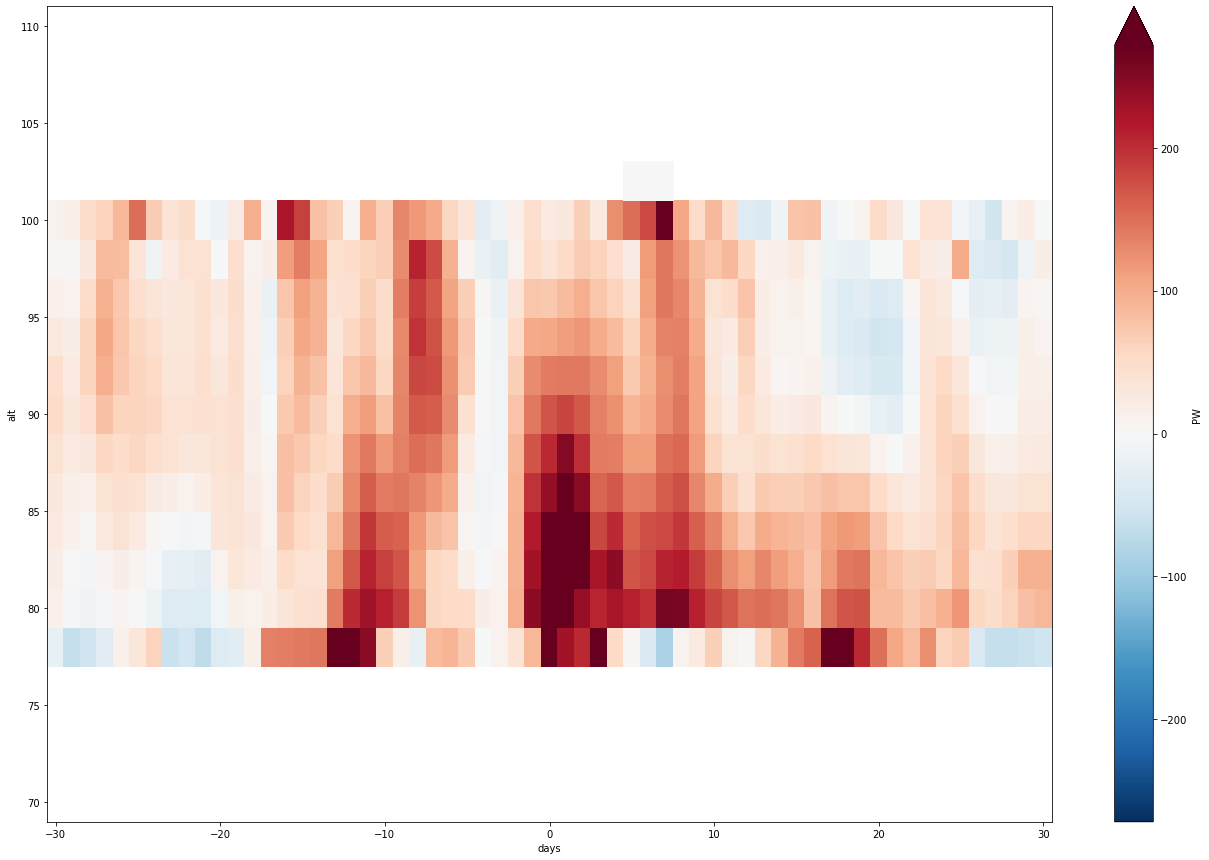

In [92]:
ax64 = sea_pw_esr_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Davis

In [93]:
waves_dav = read_group('waves','Davis')
gw_dav = read_var(waves_dav,'GW')
pw_dav = read_var(waves_dav,'PW')

gw_dav_anomalie = anomalie('day',gw_dav)

pw_dav_anomalie = anomalie('day',pw_dav)

sea_gw_dav = sea(30,'Davis',gw_dav)
sea_gw_dav_anomalie = sea(30,'Davis',gw_dav_anomalie)

sea_pw_dav = sea(30,'Davis',pw_dav)
sea_pw_dav_anomalie = sea(30,'Davis',pw_dav_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


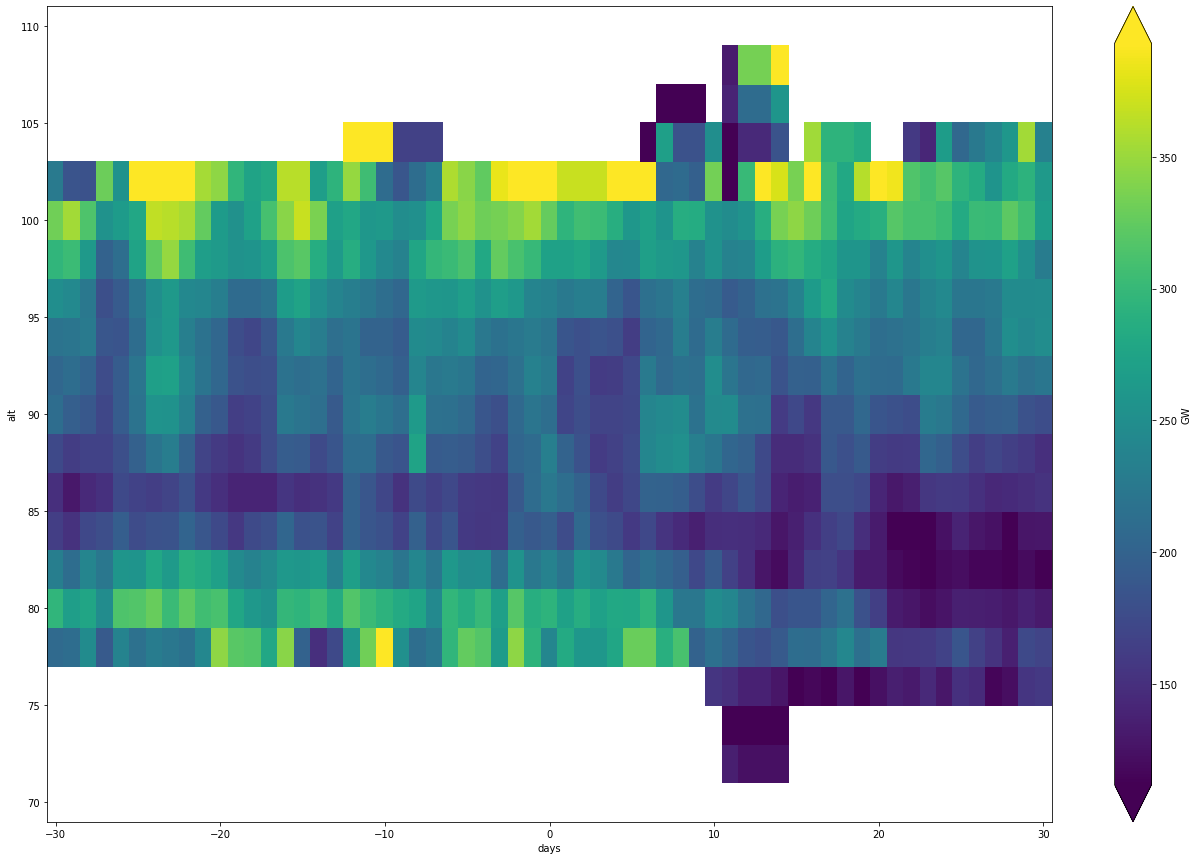

In [94]:
ax65 = sea_gw_dav.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

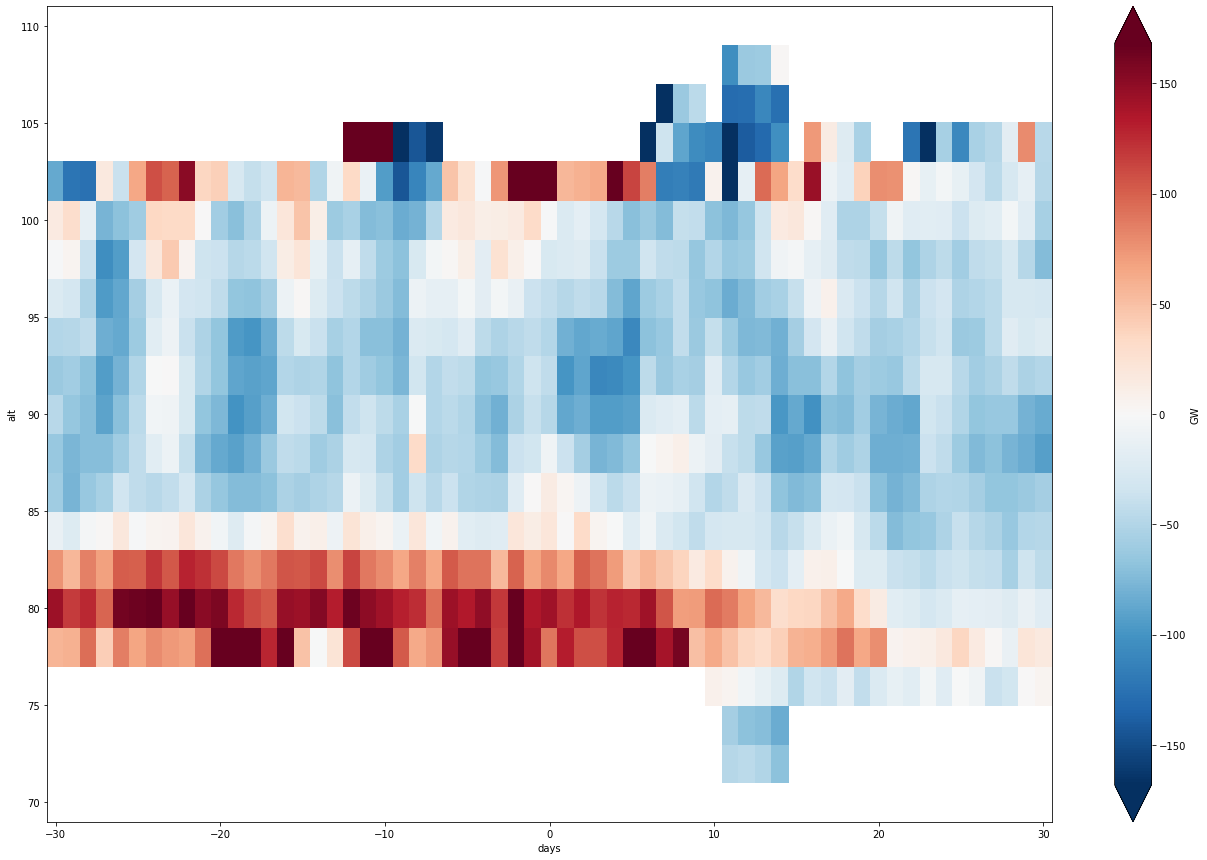

In [95]:
ax66 = sea_gw_dav_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

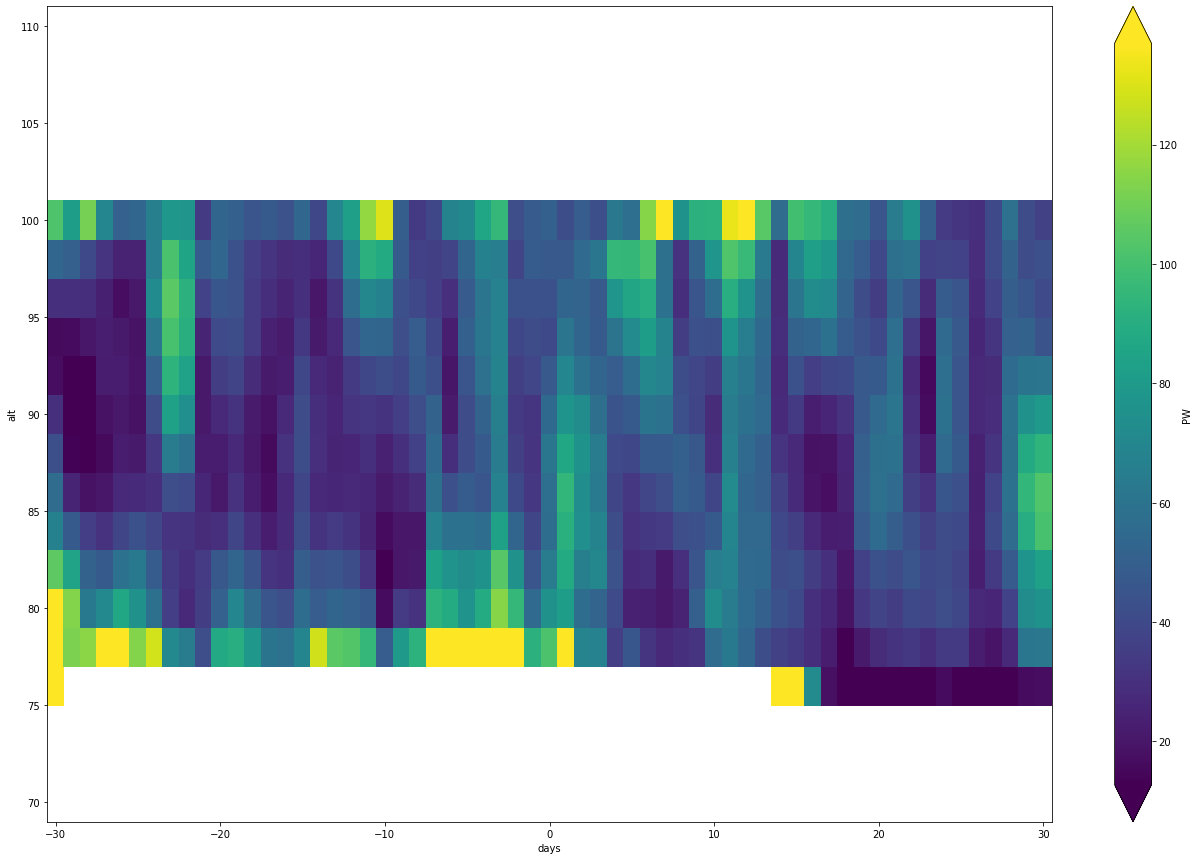

In [96]:
ax67 = sea_pw_dav.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

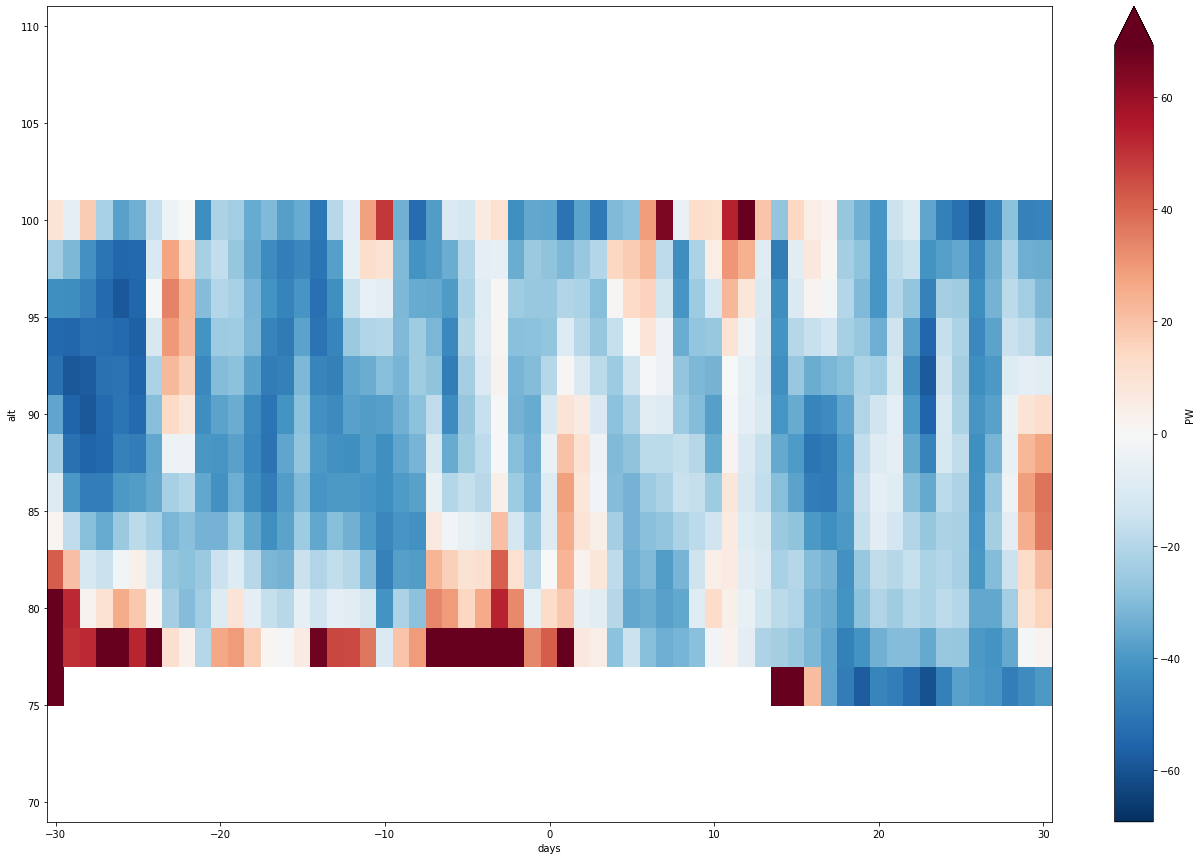

In [97]:
ax68 = sea_pw_dav_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Juliusruh

In [140]:
waves_jul = read_group('waves','Juliusruh')
gw_jul = read_var(waves_jul,'GW')
pw_jul = read_var(waves_jul,'PW')

gw_jul_anomalie = anomalie('day',gw_jul)

pw_jul_anomalie = anomalie('day',pw_jul)

sea_gw_jul = sea(60,'Juliusruh',gw_jul)
sea_gw_jul_anomalie = sea(60,'Juliusruh',gw_jul_anomalie)

sea_pw_jul = sea(60,'Juliusruh',pw_jul)
sea_pw_jul_anomalie = sea(60,'Juliusruh',pw_jul_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


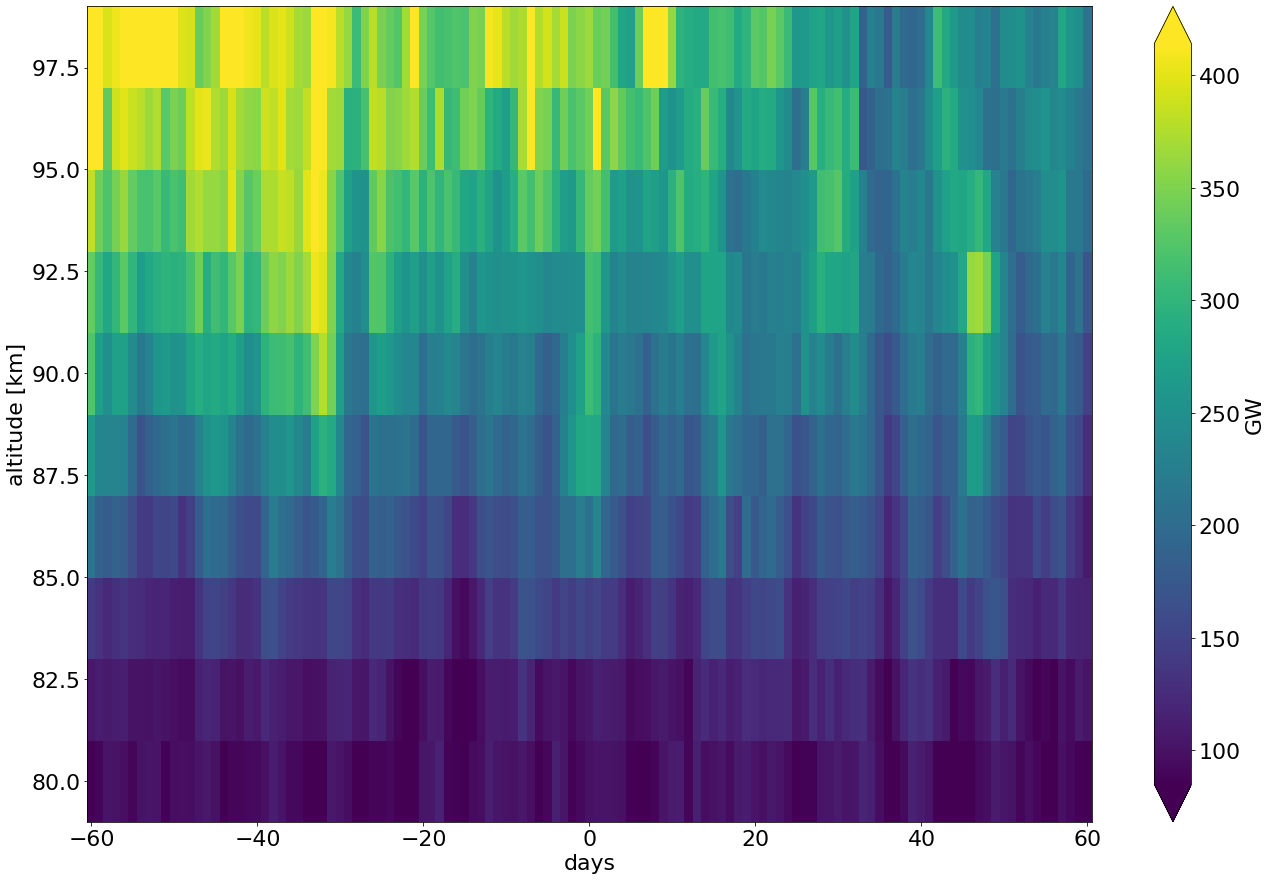

In [141]:
ax69 = sea_gw_jul.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)

In [144]:
ax70.axes

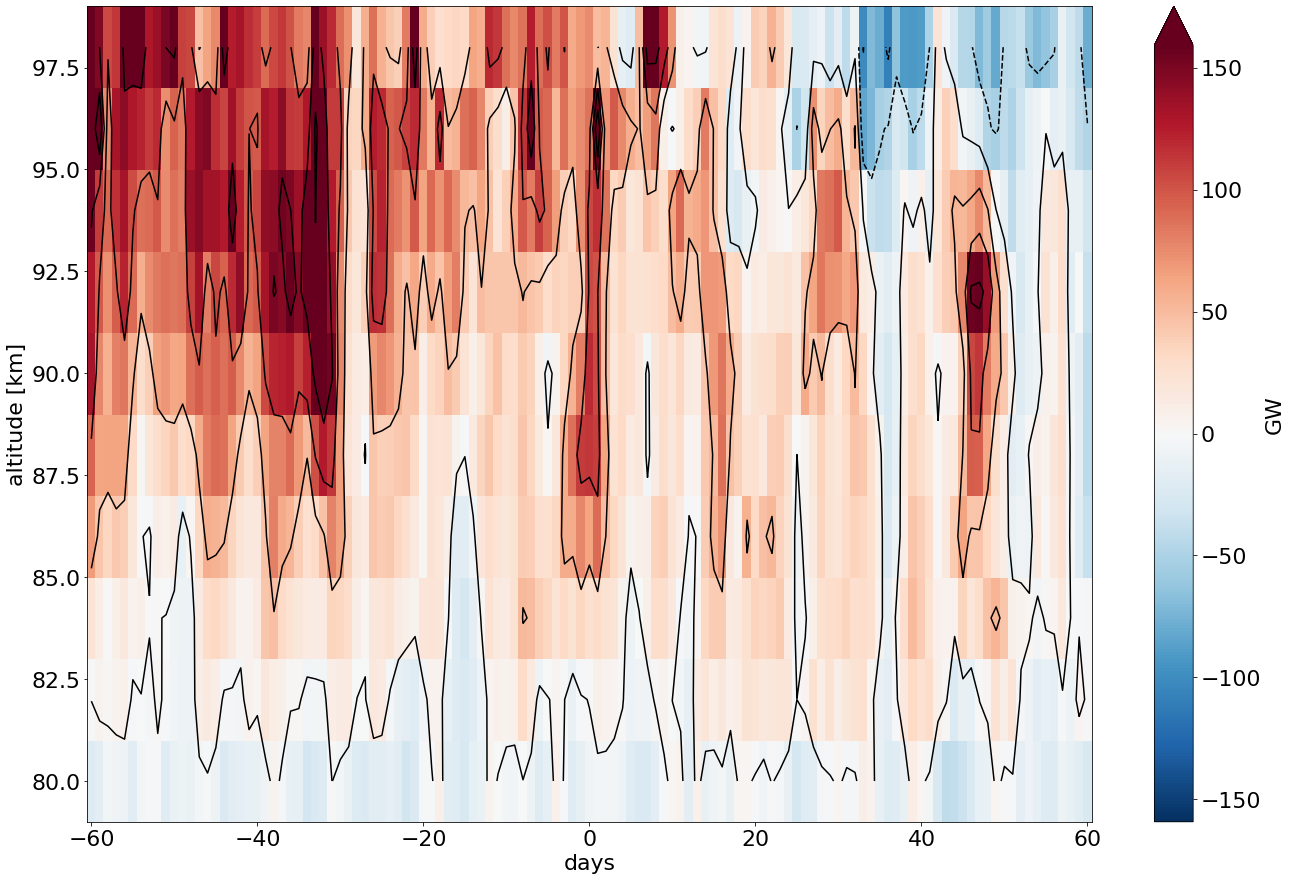

In [146]:
ax70 = sea_gw_jul_anomalie.sel(alt = slice(79,99)).plot(x='days',size=15,robust=True)
ax = ax70.axes
sea_gw_jul_anomalie.sel(alt = slice(79,99)).plot.contour(x='days', colors ='k', ax = ax, levels = 11)

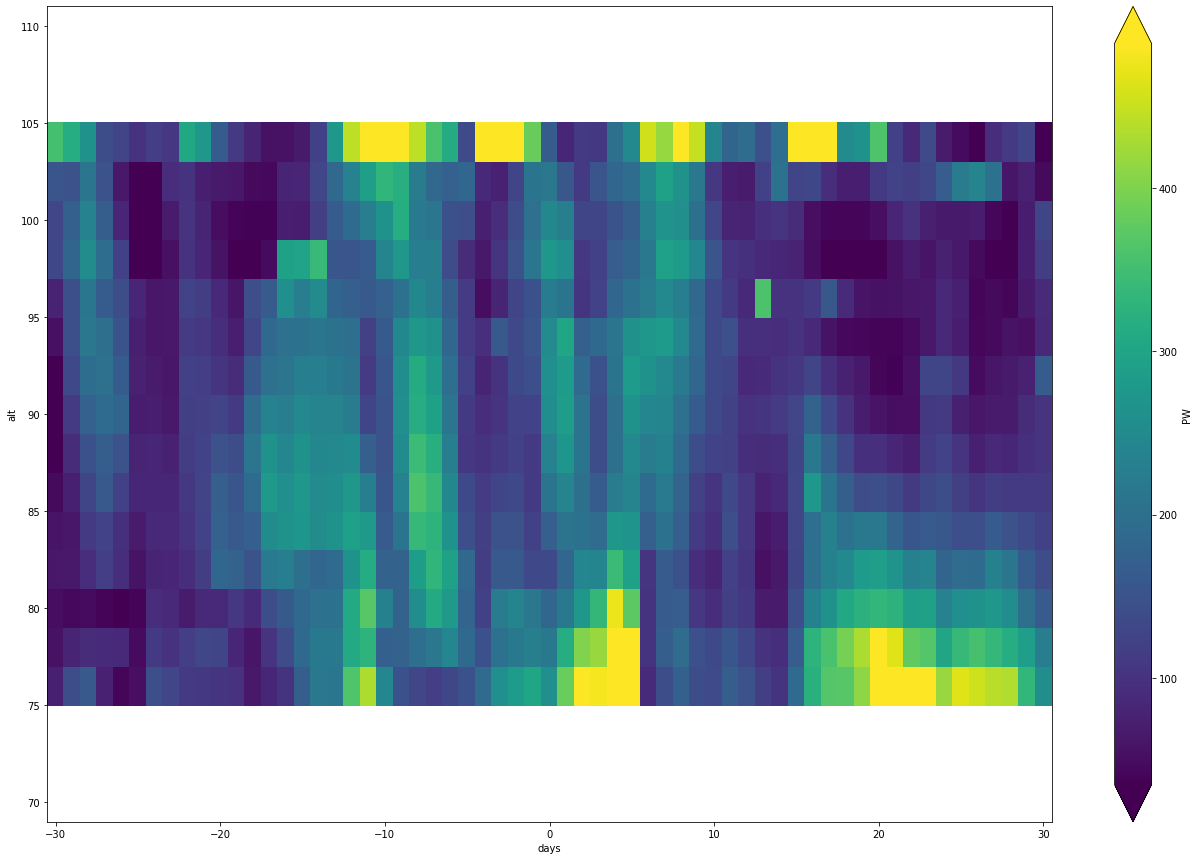

In [101]:
ax71 = sea_pw_jul.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

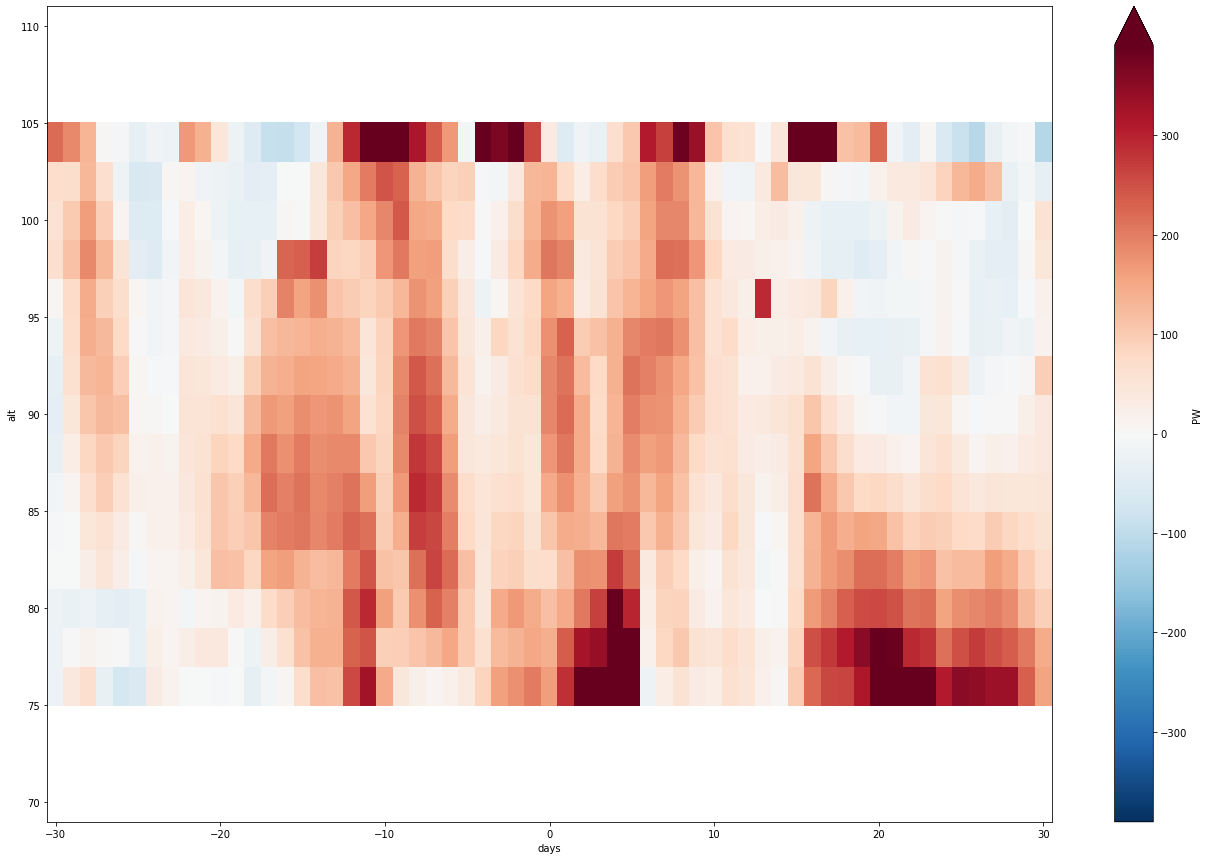

In [102]:
ax72 = sea_pw_jul_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### Rio Grande

In [103]:
waves_rio = read_group('waves','RioGrande')
gw_rio = read_var(waves_rio,'GW')
pw_rio = read_var(waves_rio,'PW')

gw_rio_anomalie = anomalie('day',gw_rio)

pw_rio_anomalie = anomalie('day',pw_rio)

sea_gw_rio = sea(30,'RioGrande',gw_rio)
sea_gw_rio_anomalie = sea(30,'RioGrande',gw_rio_anomalie)

sea_pw_rio = sea(30,'RioGrande',pw_rio)
sea_pw_rio_anomalie = sea(30,'RioGrande',pw_rio_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


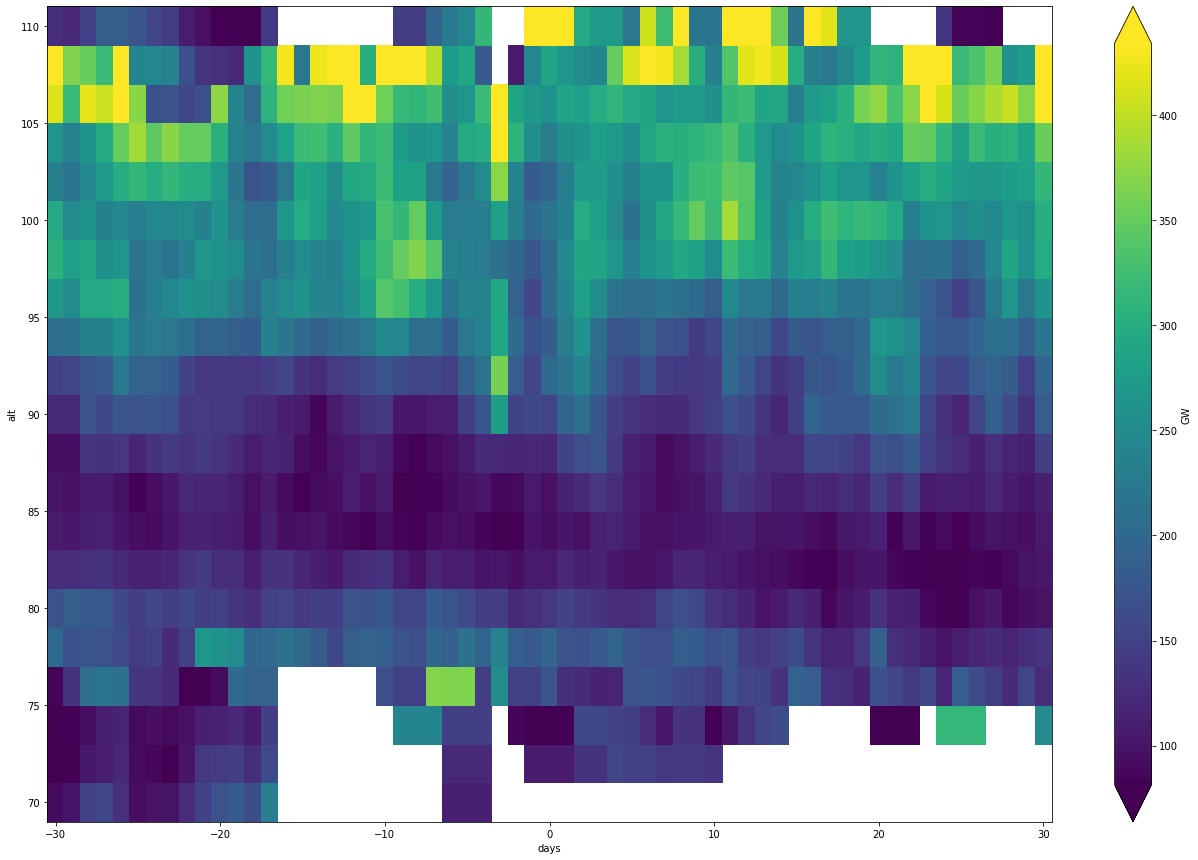

In [104]:
ax73 = sea_gw_rio.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

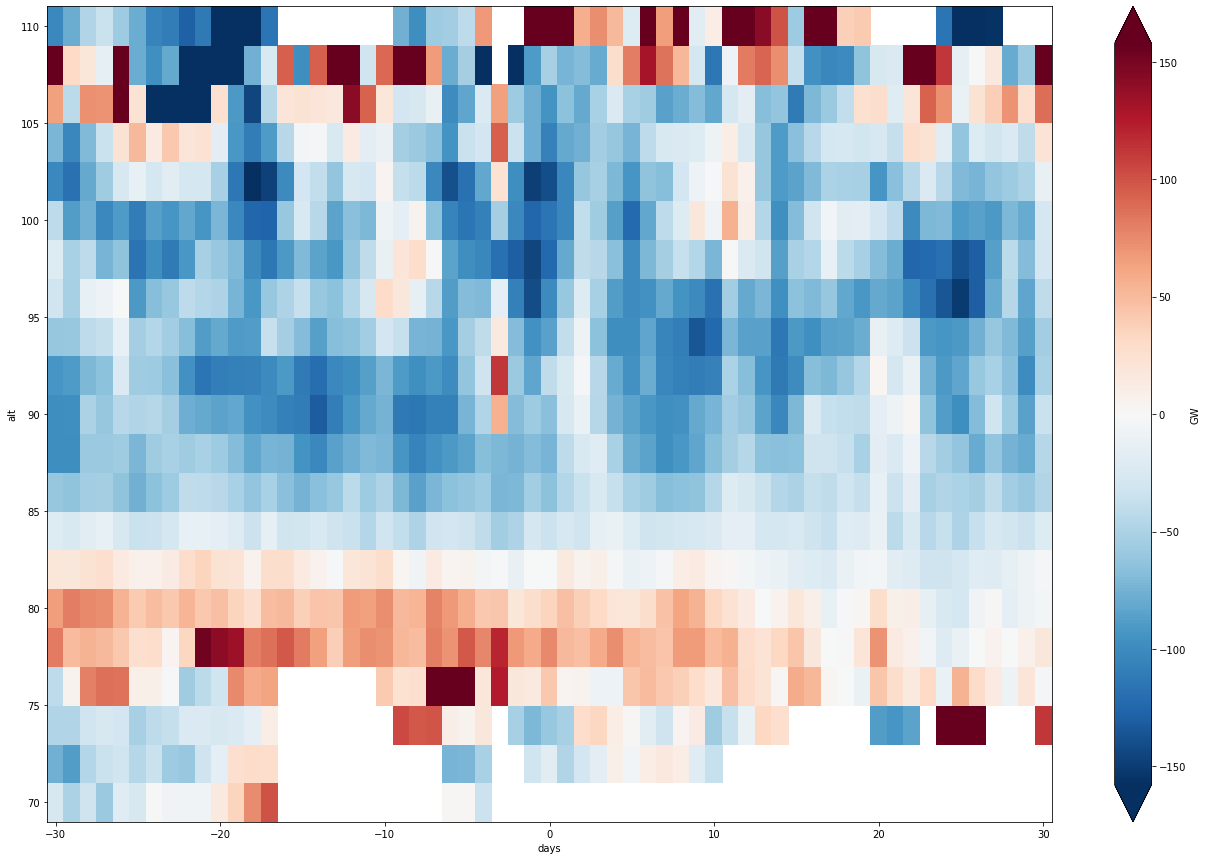

In [105]:
ax74 = sea_gw_rio_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

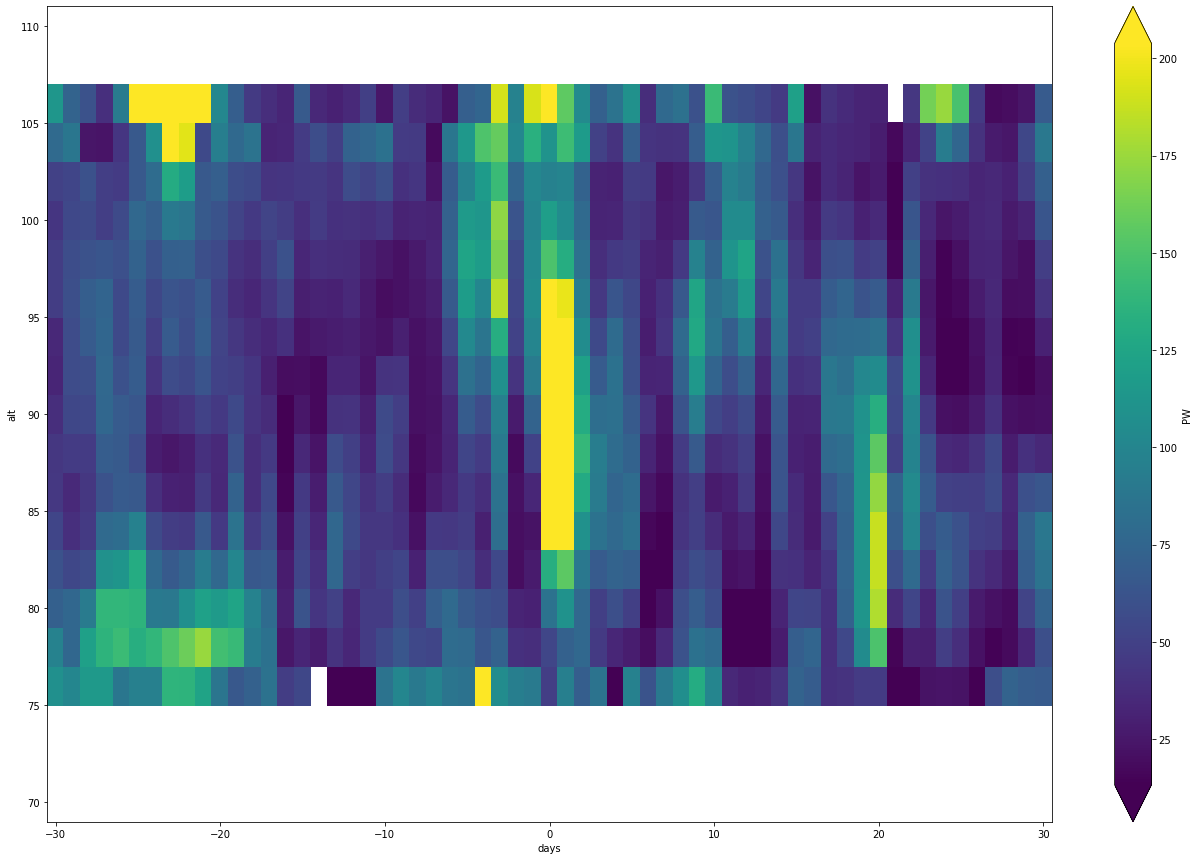

In [106]:
ax75 = sea_pw_rio.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

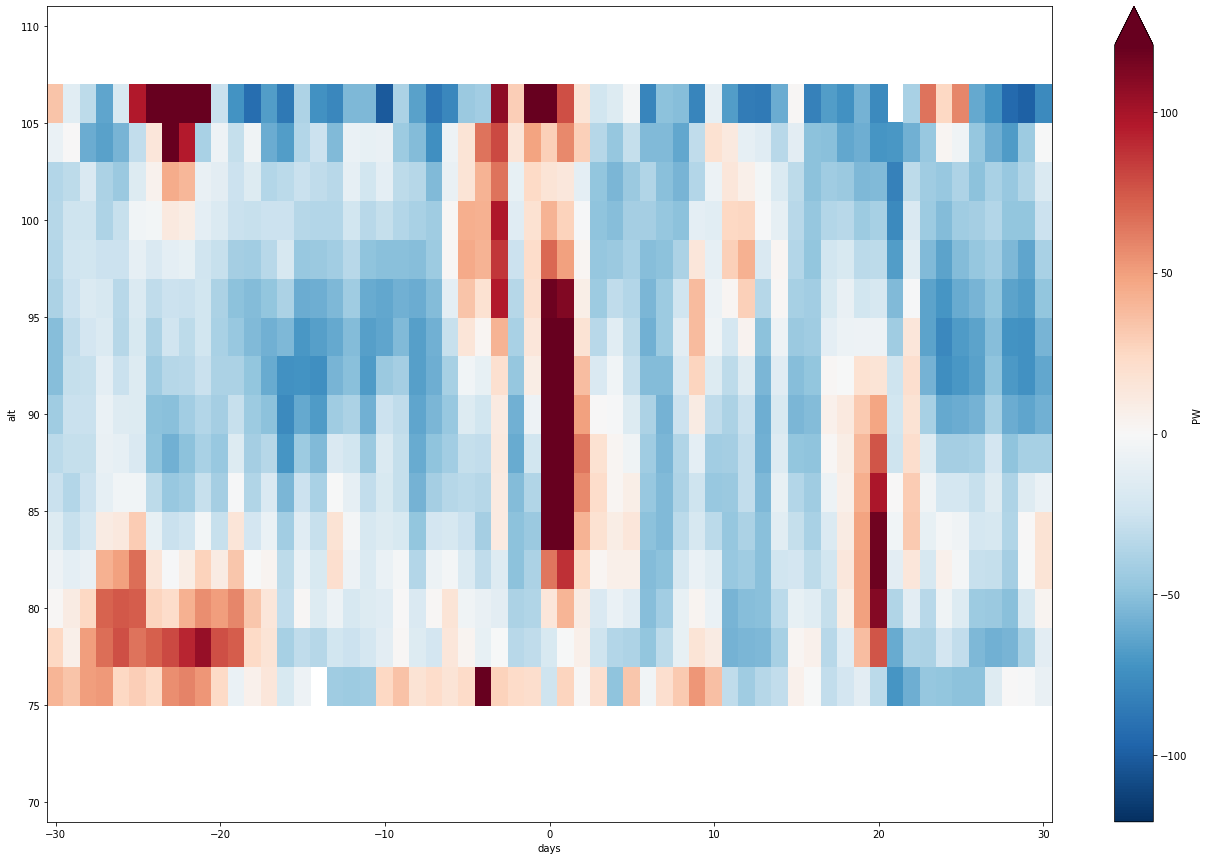

In [107]:
ax76 = sea_pw_rio_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

### CMA

In [108]:
waves_cma = read_group('waves','CMOR')
gw_cma = read_var(waves_cma,'GW')
pw_cma = read_var(waves_cma,'PW')

gw_cma_anomalie = anomalie('day',gw_cma)

pw_cma_anomalie = anomalie('day',pw_cma)

sea_gw_cma = sea(30,'CMOR',gw_cma)
sea_gw_cma_anomalie = sea(30,'CMOR',gw_cma_anomalie)

sea_pw_cma = sea(30,'CMOR',pw_cma)
sea_pw_cma_anomalie = sea(30,'CMOR',pw_cma_anomalie)

/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/hochatmstud/.conda/envs/uas/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


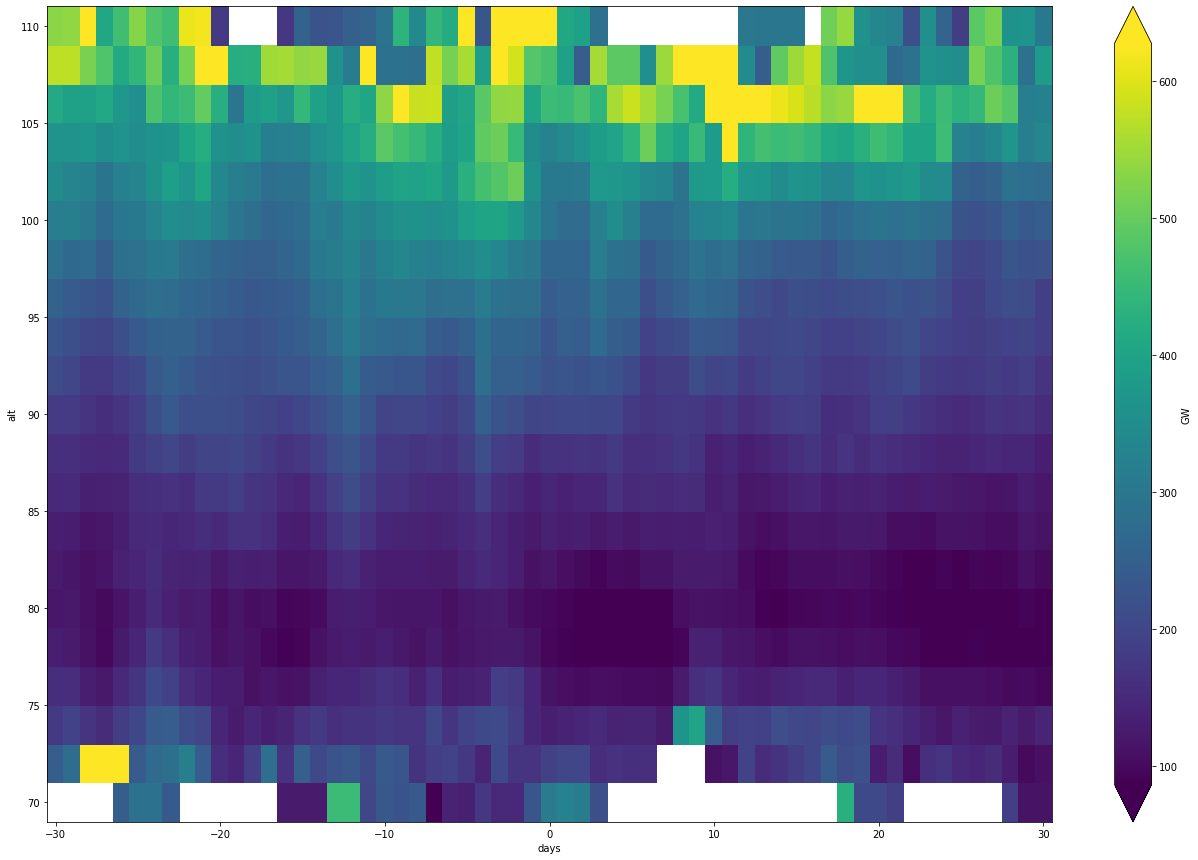

In [109]:
ax77 = sea_gw_cma.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

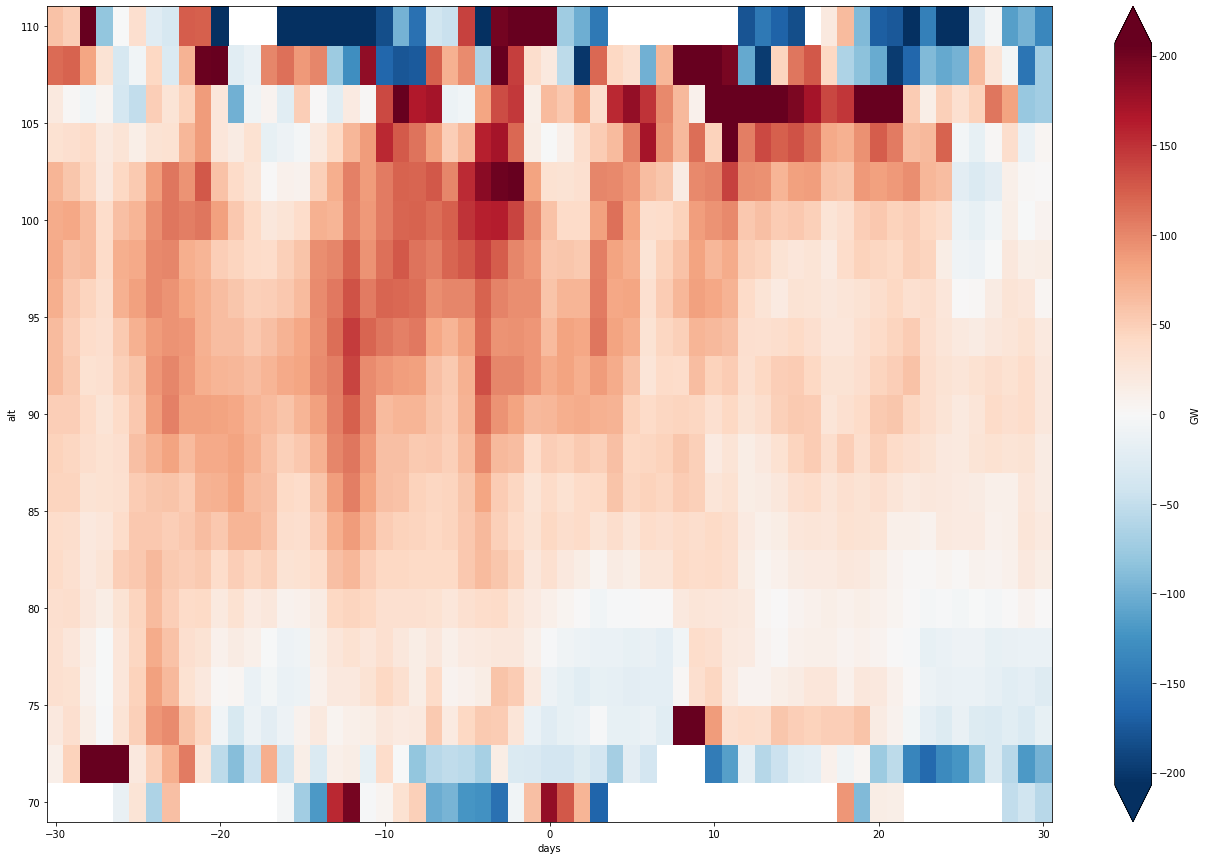

In [110]:
ax78 = sea_gw_cma_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

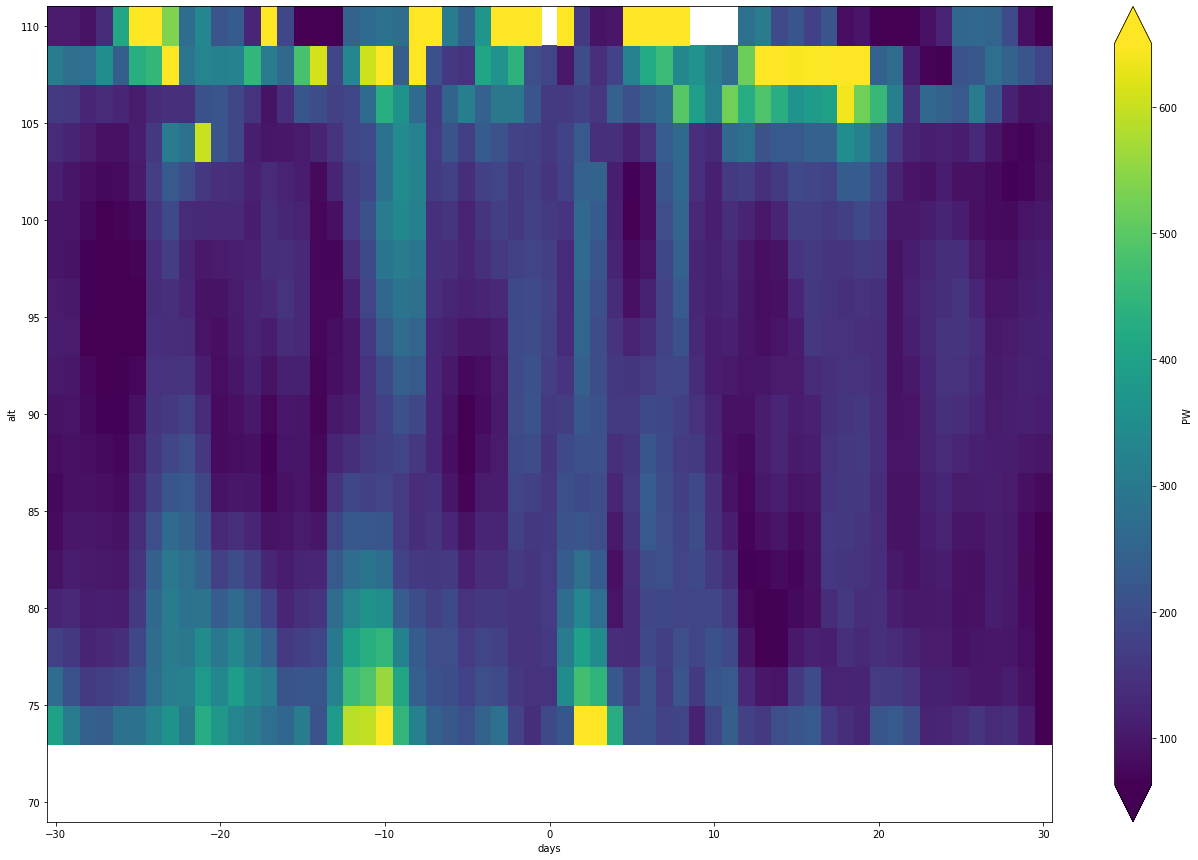

In [111]:
ax79 = sea_pw_cma.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)

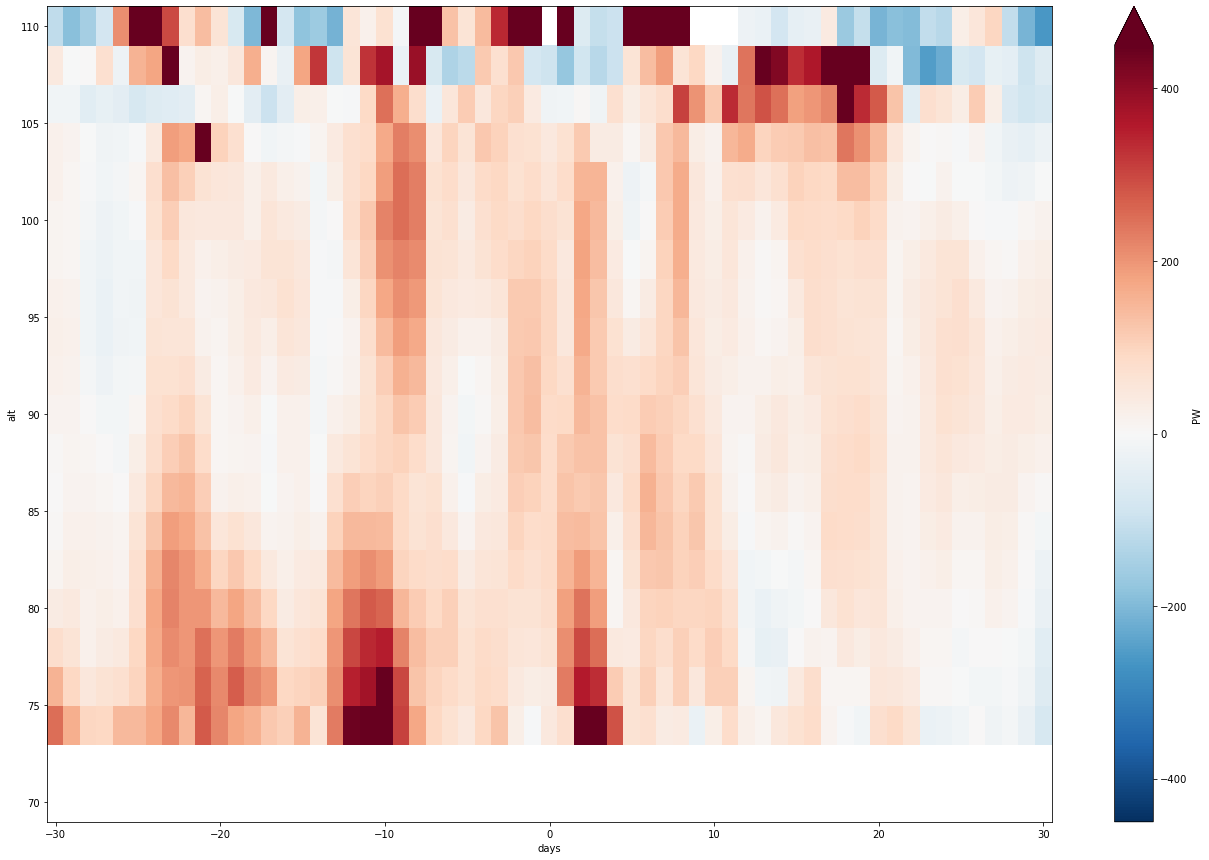

In [112]:
ax80 = sea_pw_cma_anomalie.sel(alt = slice(70,110)).plot(x='days',size=15,robust=True)